In [1]:
import os
import time
import math
import numpy as np
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import datetime
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [2]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoConfig
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
label_list = ['UNK',1,2,3,4]

In [4]:
df_train_l=pd.read_csv("../../AGNews/assigned/train_l.csv", index_col="Unnamed: 0")
df_test_l=pd.read_csv("../../AGNews/assigned/test_l.csv", index_col="Unnamed: 0")
df_u=pd.read_csv("../../AGNews/assigned/u.csv", index_col="Unnamed: 0")
df_train_u=pd.read_csv("../../AGNews/assigned/train_u.csv", index_col="Unnamed: 0")#.head(10000)
df_test_u=pd.read_csv("../../AGNews/assigned/test_u.csv", index_col="Unnamed: 0")#.head(5000)
df_all = pd.concat([df_train_l, df_test_l, df_u, df_train_u, df_test_u])

In [5]:
train_l =  list(df_train_l.to_records(index=False))
test_l = list(df_test_l.to_records(index=False))
u_list = list(df_u.to_records(index=False))
test_u = list(df_test_u.to_records(index=False))
train_u = list(df_train_u.to_records(index=False))
data_all = list(df_all["0"])

In [6]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 40
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
#num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6 #5e-6?
#learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 200
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name="google/electra-large-discriminator"
#model_name="google/electra-small-discriminator"
#model_name="microsoft/deberta-v2-xxlarge"
#model_name="microsoft/deberta-v3-base"
#model_name = "google/electra-base-discriminator" - 0.47 best when only change this line

In [7]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [9]:
def generate_data_fake(input_examples):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []

  # Tokenization 
  for text in input_examples:
    encoded_sent = tokenizer.encode(text, add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)

  # Building the DataLoader
  return input_ids, input_mask_array # Trains with this batch size.

In [10]:
#Load the examples
labeled_examples = train_l
unlabeled_examples = u_list
test_examples = test_l

In [11]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [12]:
#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [13]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
#hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
#generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  #generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

In [14]:
training_stats = []

accuracy_array=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

In [15]:
#OPTAGAN
from __future__ import absolute_import, division, print_function, unicode_literals
import argparse

import logging
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np

from torch.autograd import Variable
from modules.gan import Generator, Critic

import copy
import math
import glob
import os
import pickle
import random

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from func import GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig, BertConfig
from func import GPT2LMHeadModel, GPT2Tokenizer, GPT2ForLatentConnector, GPT2ForLatentConnectorValueHead
from func import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
from func import XLNetLMHeadModel, XLNetTokenizer
from func import TransfoXLLMHeadModel, TransfoXLTokenizer
from func import BertForLatentConnector, BertTokenizer

from collections import defaultdict
from utils import (TextDataset_Split, TextDataset_2Tokenizers, BucketingDataLoader)
import pdb
from modules.utils import (calc_blue_parallel_func, pad_seq, rollout, rollout_test)
#from transformers.modeling_utils import top_k_top_p_filtering


MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop
ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig)), ())

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2ForLatentConnectorValueHead, GPT2Tokenizer),
    'bert': (BertConfig, BertForLatentConnector, BertTokenizer)
}

num_txt = 1

def load_and_cache_examples(args, tokenizer):
    if isinstance(tokenizer, list):
        dataset = TextDataset_2Tokenizers(tokenizer, args, args.train_data_file, block_size=args.block_size)
    else:
        dataset = TextDataset_Split(tokenizer, args, args.train_data_file, block_size=args.block_size)
    return dataset

def build_dataload_and_cache_examples(args, tokenizer, num_txt):
    if isinstance(tokenizer, list):
        args.batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
        if num_txt<=8:
            concatenation="{}_{}{}".format(args.train_data_file, num_txt, ".txt")
            file_path=concatenation
            print("Train file used is number {}".format(num_txt))
            print(concatenation)
            num_txt=num_txt+1
        else:
            num_txt=1
            concatenation="{}_{}{}".format(args.train_data_file, num_txt, ".txt")
            file_path=concatenation
            print("Train file used is number {}".format(num_txt))
        dataloader = BucketingDataLoader(file_path, args.batch_size, args.max_seq_length, tokenizer, args, bucket=100, shuffle=True)
    else:
        pass 
    return dataloader, num_txt

def compute_grad_penalty(critic, real_data, fake_data):
    B = real_data.size(0)
    alpha = torch.FloatTensor(np.random.random((B, 1)))
    if args.cuda:
        alpha = alpha.cuda()
    sample = alpha*real_data + (1-alpha)*fake_data
    sample.requires_grad_(True)
    score = critic(sample)

    outputs = torch.FloatTensor(B, 1).fill_(1.0) #args.latent_size
    outputs.requires_grad_(False)
    if args.cuda:
        outputs = outputs.cuda()
    grads = autograd.grad(
        outputs=score,
        inputs=sample,
        grad_outputs=outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]
    grad_penalty = ((grads.norm(2, dim=1) - 1.) ** 2).mean()
    return grad_penalty

def train(epoch):
    model_encoder.eval()
    model_decoder.eval()
    generator.train()
    critic.train()
    c_train_loss = 0.
    g_train_loss = 0.
    g_batches = 0
    c_batches = 0
    c_loss_0 = 1
    g_loss_0 = 1
    for i, x in enumerate(train_loader):
        x = x[0]
        if args.cuda:
            x = x.cuda()
        # Generate noise
        B = args.per_gpu_train_batch_size
        noise = torch.from_numpy(np.random.normal(0, 1, (B,
                                 args.latent_size))).float()
        if args.cuda:
            noise = noise.cuda()
        # Get original text latent embeddings
        with torch.no_grad(): 
            pooled_hidden_fea = model_encoder(x, attention_mask=(x > 0).float())[1]
            mean, logvar = model_encoder.linear(pooled_hidden_fea).chunk(2, -1)
            z_real = mean.squeeze(1) 

        # Evaluate and get losses
        z_fake = generator(noise)
        real_score = critic(z_real)
        fake_score = critic(z_fake)
        grad_penalty = compute_grad_penalty(critic, z_real.data, z_fake.data)
        c_loss = -torch.mean(real_score) + torch.mean(fake_score) + \
                 args.gp_lambda*grad_penalty

        fake_score = critic(generator(noise))
        g_loss = -torch.mean(fake_score)
        
        r_g = abs(((g_loss.item() - g_loss_0) / (g_loss_0 + 0.001))) 
        r_c = abs(((c_loss.item() - c_loss_0) / (c_loss_0 + 0.001))) 
        
        # Update critic or generator
        if ((2 + epoch) / epoch) * r_c > r_g:
            c_optimizer.zero_grad()
            c_batches += 1
            c_train_loss += c_loss.item()
            c_loss.backward()
            c_optimizer.step()
        else:
            g_optimizer.zero_grad()
            g_batches += 1
            g_train_loss += g_loss.item()
            g_loss.backward()
            g_optimizer.step()

        c_loss_0 = c_loss.item()
        g_loss_0 = g_loss.item()

        if args.interval > 0 and i % args.interval == 0:
            logger.info('Epoch: {} | Batch: {}/{} ({:.0f}%) | G Loss: {:.6f} | C Loss: {:.6f}'.format(
                epoch, args.batch_size*i, len(train_loader.dataset),
                100.*(args.batch_size*i)/len(train_loader.dataset),
                g_loss.item(), c_loss.item()
            ))
            test_noise = torch.Tensor(np.random.normal(0, 1, (1, args.latent_size))).to(args.device)
            test_new_z = generator(test_noise).data
            # create new sent
            test_z = rollout_test(model_decoder, test_new_z, tokenizer_decoder, args.max_seq_length, 1, 0, 1)
            logger.info("Text: {}".format(test_z))

    c_train_loss /= c_batches + 1
    g_train_loss /= g_batches + 1
    logger.info('* (Train) Epoch: {} | G Loss: {:.4f} | C Loss: {:.4f} | Updates G: {} | Updates C: {}'.format(
        epoch, g_train_loss, c_train_loss, g_batches, c_batches
    ))
    return (g_train_loss, c_train_loss)

[nltk_data] Downloading package punkt to /home/harry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--epochs', type=int, default=15)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--gp_lambda', type=int, default=10)
    parser.add_argument('--n_layers', type=int, default=20, help="Number of layers of generator and critic")
    parser.add_argument('--block_dim', type=int, default=100)
    parser.add_argument('--interval', type=int, default=10, help="Steps before logging output")
    parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available())
    
    # Optimus parameters
    parser.add_argument("--train_data_file", default=None, type=str, required=True,
                        help="The input training data file (a text file).")
    parser.add_argument("--valid_data_file", default=None, type=str, required=True,
                        help="The input validation data file (a text file).")
    parser.add_argument("--checkpoint_dir", default=None, type=str, required=True,
                        help="The directory where checkpoints are saved.")
    parser.add_argument('--generator_dir', default=None, type=str, help="Directory where GAN models are saved")
    parser.add_argument("--output_dir", default=None, type=str, required=True,
                        help="The output directory where the model predictions and checkpoints will be written.")
    parser.add_argument("--dataset", default='Snli', type=str, help="The dataset.")    
    parser.add_argument("--latent_size", default=32, type=int, help="Latent space dimension.")
    ## Encoder options
    parser.add_argument("--encoder_model_type", default="bert", type=str,
                        help="The encoder model architecture to be fine-tuned.")
    parser.add_argument("--encoder_model_name_or_path", default="bert-base-cased", type=str,
                        help="The encoder model checkpoint for weights initialization.")
    parser.add_argument("--encoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--encoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    ## Decoder options
    parser.add_argument("--decoder_model_type", default="gpt2", type=str,
                        help="The decoder model architecture to be fine-tuned.")
    parser.add_argument("--decoder_model_name_or_path", default="bert-base-cased", type=str,
                        help="The decoder model checkpoint for weights initialization.")
    parser.add_argument("--decoder_config_name", default="", type=str,
                        help="Optional pretrained config name or path if not the same as model_name_or_path")
    parser.add_argument("--decoder_tokenizer_name", default="", type=str,
                        help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
    parser.add_argument("--per_gpu_train_batch_size", default=1, type=int,
                        help="Batch size per GPU/CPU for training.")
    parser.add_argument("--max_seq_length", default=512, type=int,
                        help="Optional input sequence length before tokenization. The sequence will be dropped if it is longer the max_seq_length")

    ## Variational auto-encoder(check this)
    parser.add_argument("--prompt", type=str, default="")
    parser.add_argument("--padding_text", type=str, default="")
    parser.add_argument("--length", type=int, default=20)
    parser.add_argument("--block_size", default=-1, type=int,
                        help="Optional input sequence length after tokenization."
                             "The training dataset will be truncated in block of this size for training."
                             "Default to the model max input length for single sentence inputs (take into account special tokens).")
    parser.add_argument("--do_lower_case", action='store_true',
                        help="Set this flag if you are using an uncased model.")
    parser.add_argument("--use_philly", action='store_true',
                        help="Use Philly for computing.")
    parser.add_argument('--gloabl_step_eval', type=int, default=661,
                        help="Evaluate the results at the given global step")
    # Reinforcement learning parameters
    parser.add_argument('--finetune_decoder', type=bool, default=True)
    parser.add_argument('--epochs_rl', type=int, default=1000)
    parser.add_argument('--batch_size_rl', type=int, default=32)
    parser.add_argument('--lr_rl', type=float, default=1e-6)


    # Load a trained Encoder model and vocabulary that you have fine-tuned
    args = parser.parse_args("--dataset EMNLP \
    --checkpoint_dir=output_dir_768_0_unsure \
    --output_dir=output_dir_768_0_unsure \
    --encoder_model_type=bert \
    --encoder_model_name_or_path=bert-base-cased \
    --decoder_model_type=gpt2 \
    --decoder_model_name_or_path=gpt2 \
    --train_data_file=../../AGNews/subdivided/train \
    --valid_data_file=../../AGNews/unlabelled/test.txt \
    --per_gpu_train_batch_size 12 \
    --block_size 100 \
    --max_seq_length 24 \
    --gloabl_step_eval 508523 \
    --latent_size 768 \
    --block_dim 100 \
    --n_layers 10 \
    --interval 50 \
    --epochs 200 \
    --finetune_decoder False \
    --lr_rl 1e-6 \
    --epochs_rl 100 \
    --batch_size_rl 32".split())
    
    print(args)

    global_step = args.gloabl_step_eval

    torch.backends.cudnn.deterministic = True
    #args.device = torch.device("cuda" if args.cuda else "cpu")
    #args.n_gpu = torch.cuda.device_count()
    args.device = torch.device("cuda:0")
    args.n_gpu=1
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)       
    
    args.encoder_model_type = args.encoder_model_type.lower()
    args.decoder_model_type = args.decoder_model_type.lower()

    output_encoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-encoder-{}'.format(global_step))
    output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step)) 
    checkpoints = [ [output_encoder_dir, output_decoder_dir] ]

    # Load a trained Encoder model and vocabulary that you have fine-tuned
    encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[args.encoder_model_type]
    model_encoder = encoder_model_class.from_pretrained(output_encoder_dir, latent_size=args.latent_size)
    tokenizer_encoder = encoder_tokenizer_class.from_pretrained(args.encoder_tokenizer_name if args.encoder_tokenizer_name else args.encoder_model_name_or_path, do_lower_case=args.do_lower_case)

    model_encoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_encoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_encoder.max_len_single_sentence)

    # Load a trained Decoder model and vocabulary that you have fine-tuned
    decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[args.decoder_model_type]
    model_decoder = decoder_model_class.from_pretrained(output_decoder_dir, latent_size=args.latent_size)
    tokenizer_decoder = decoder_tokenizer_class.from_pretrained(args.decoder_tokenizer_name if args.decoder_tokenizer_name else args.decoder_model_name_or_path, do_lower_case=args.do_lower_case)
    model_decoder.to(args.device)
    if args.block_size <= 0:
        args.block_size = tokenizer_decoder.max_len_single_sentence  # Our input block size will be the max possible for the model
    args.block_size = min(args.block_size, tokenizer_decoder.max_len_single_sentence)

    # Chunyuan: Add Padding token to GPT2
    special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
    num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
    logger.info('We have added {} tokens to GPT2'.format(num_added_toks))
    model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
    assert tokenizer_decoder.pad_token == '<PAD>'

    #train_loader, num_txt = build_dataload_and_cache_examples(args, [tokenizer_encoder, tokenizer_decoder], num_txt) 
    generator = Generator(args.n_layers, args.block_dim,args.latent_size)
    critic = Critic(args.n_layers, args.block_dim,args.latent_size)

    if args.generator_dir!=None:
        logger.info("Loading generator and critic")
        generator.load_state_dict(torch.load(args.generator_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
        critic.load_state_dict(torch.load(args.generator_dir+'/critic_'+str(args.gloabl_step_eval)+'.th'))

    g_optimizer = optim.Adam(generator.parameters(), lr=args.lr, betas=(0.5, 0.999))
    c_optimizer = optim.Adam(critic.parameters(), lr=args.lr, betas=(0.5, 0.999))
    
    if args.cuda:
        generator = generator.cuda()
        critic = critic.cuda()
    
    logger.info('G Parameters:{}'.format(sum([p.numel() for p in generator.parameters() if \
                                p.requires_grad])))
    logger.info('C Parameters:{}'.format(sum([p.numel() for p in critic.parameters() if \
                                p.requires_grad])))
    
    device = args.device
    
    best_bleu = 0
    reference = list()
    with(open(args.valid_data_file,"r")) as valid:
        for sents in valid:
            reference.append(sents.replace("\n", ""))
            
    for epoch in range(1, args.epochs + 1):
        
        #Insert GAN-BERT Code Here
        
        train_loader, num_txt = build_dataload_and_cache_examples(args, [tokenizer_encoder, tokenizer_decoder], num_txt) 
        
        print("Train classification discriminator")
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch, args.epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        tr_g_loss = 0
        tr_d_loss = 0

        # Put the model into training mode.
        transformer.train() 
        #generator.train()
        discriminator.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every print_each_n_step batches.
            if step % print_each_n_step == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            b_label_mask = batch[3].to(device)

            real_batch_size = b_input_ids.shape[0]

            # Encode real data in the Transformer
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs.last_hidden_state[:,0,:] 
            #hidden_states = model_outputs[-1]
            #print("  Number of real sentences (labelled and unlabelled): {}".format(len(hidden_states)))
            
            # Generate fake data that should have the same distribution of the ones
            # encoded by the transformer. 
            # First noisy input are used in input to the Generator
            fixed_noise = torch.Tensor(np.random.normal(0, 1, (real_batch_size, args.latent_size))).to(args.device)
            test_z_gb = generator(fixed_noise).data
            fake_sentences = rollout_test(model_decoder, test_z_gb, tokenizer_decoder, args.max_seq_length, real_batch_size, 0, 1)
            #print("  Number of generated sentences: {}".format(len(fake_sentences)))

            b_input_ids_fake, b_input_mask_fake = generate_data_fake(fake_sentences)
            model_outputs_fake = transformer(b_input_ids_fake, attention_mask=b_input_mask_fake)
            hidden_states_fake = model_outputs_fake.last_hidden_state[:,0,:] 
            #hidden_states_fake = model_outputs_fake[-1]

            #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
            # Gnerate Fake data
            #gen_rep = generator(noise)
            #print("Length of generator output {}".format(len(gen_rep)))
            #print("Length of single generator output {}".format(len(gen_rep[0])))

            # Generate the output of the Discriminator for real and fake data.
            # First, we put together the output of the tranformer and the generator
            disciminator_input = torch.cat([hidden_states, hidden_states_fake], dim=0)
            # Then, we select the output of the disciminator
            features, logits, probs = discriminator(disciminator_input)

            # Finally, we separate the discriminator's output for the real and fake
            # data
            features_list = torch.split(features, real_batch_size)
            D_real_features = features_list[0]
            D_fake_features = features_list[1]

            logits_list = torch.split(logits, real_batch_size)
            D_real_logits = logits_list[0]
            D_fake_logits = logits_list[1]

            probs_list = torch.split(probs, real_batch_size)
            D_real_probs = probs_list[0]
            D_fake_probs = probs_list[1]

            #---------------------------------
            #  LOSS evaluation
            #---------------------------------
            # Generator's LOSS estimation
            g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
            g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
            g_loss = g_loss_d + g_feat_reg

            # Disciminator's LOSS estimation
            logits = D_real_logits[:,0:-1]
            log_probs = F.log_softmax(logits, dim=-1)
            # The discriminator provides an output for labeled and unlabeled real data
            # so the loss evaluated for unlabeled data is ignored (masked)
            label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
            per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
            per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
            labeled_example_count = per_example_loss.type(torch.float32).numel()

            # It may be the case that a batch does not contain labeled examples, 
            # so the "supervised loss" in this case is not evaluated
            if labeled_example_count == 0:
              D_L_Supervised = 0
            else:
              D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

            D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
            D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
            d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

            #---------------------------------
            #  OPTIMIZATION
            #---------------------------------
            # Avoid gradient accumulation
            #gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()

            # Calculate weigth updates
            # retain_graph=True is required since the underlying graph will be deleted after backward
            g_loss.backward(retain_graph=True)
            d_loss.backward() 

            # Apply modifications
            #gen_optimizer.step()
            dis_optimizer.step()

            # A detail log of the individual losses
            #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
            #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
            #             g_loss_d, g_feat_reg))

            # Save the losses to print them later
            tr_g_loss += g_loss.item()
            tr_d_loss += d_loss.item()

            # Update the learning rate with the scheduler
            if apply_scheduler:
              scheduler_d.step()
              #scheduler_g.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss_g = tr_g_loss / len(train_dataloader)
        avg_train_loss_d = tr_d_loss / len(train_dataloader)             

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
        print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #     TEST ON THE EVALUATION DATASET
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our test set.
        print("")
        print("Running Test...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        transformer.eval() #maybe redundant
        discriminator.eval()
        #generator.eval()

        # Tracking variables 
        total_test_accuracy = 0

        total_test_loss = 0
        nb_test_steps = 0

        all_preds = []
        all_labels_ids = []

        #loss
        nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

        # Evaluate data for one epoch
        for batch in test_dataloader:

            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
                hidden_states = model_outputs.last_hidden_state[:,0,:] 
                #hidden_states = model_outputs[-1]
                _, logits, probs = discriminator(hidden_states)
                ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
                filtered_logits = logits[:,0:-1]
                # Accumulate the test loss.
                total_test_loss += nll_loss(filtered_logits, b_labels)

            # Accumulate the predictions and the input labels
            _, preds = torch.max(filtered_logits, 1)
            all_preds += preds.detach().cpu()
            all_labels_ids += b_labels.detach().cpu()

        # Report the final accuracy for this validation run.
        all_preds = torch.stack(all_preds).numpy()
        all_labels_ids = torch.stack(all_labels_ids).numpy()
        test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
        print("  Accuracy: {0:.3f}".format(test_accuracy))

        # Calculate the average loss over all of the batches.
        avg_test_loss = total_test_loss / len(test_dataloader)
        avg_test_loss = avg_test_loss.item()

        # Measure how long the validation run took.
        test_time = format_time(time.time() - t0)

        print("  Test Loss: {0:.3f}".format(avg_test_loss))
        print("  Test took: {:}".format(test_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss generator': avg_train_loss_g,
                'Training Loss discriminator': avg_train_loss_d,
                'Valid. Loss': avg_test_loss,
                'Valid. Accur.': test_accuracy,
                'Training Time': training_time,
                'Test Time': test_time
            }
        )

        accuracy_array.append(test_accuracy)
        
        #OPTAGAN Code
        
        g_loss, c_loss = train(epoch)

        data_test = list()
        for i in range(2):
            test_noise = torch.Tensor(np.random.normal(0, 1, (250, args.latent_size))).to(args.device)
            test_z = generator(test_noise).data
            new_sent = rollout_test(model_decoder, test_z, tokenizer_decoder, args.max_seq_length, 250, 0, 1)
            data_test.extend(new_sent)

        p_reference = random.sample(reference, 500)
        bleu = calc_blue_parallel_func(p_reference, data_test, 2, 500)
        b_bleu = calc_blue_parallel_func(data_test, p_reference, 2, 500)
        logger.info("Bleu-2:{:0.3f} | B-Bleu-2:{:0.3f}".format(bleu, b_bleu))
        
        print(bleu+b_bleu)
        if (bleu+b_bleu) > best_bleu:
            best_bleu = bleu + b_bleu
            logger.info('* Saving. Best Score:{:0.3f} | Bleu-2:{:0.3f} | B-Bleu-2:{:0.3f}'.format(best_bleu, bleu, b_bleu))
            torch.save(generator.state_dict(), args.output_dir+'/generator_'+str(args.gloabl_step_eval)+'.th')
            torch.save(critic.state_dict(), args.output_dir+'/critic_'+str(args.gloabl_step_eval)+'.th')
            
        

    if args.finetune_decoder: 
        logger.info("Loading generator")
        generator.load_state_dict(torch.load(args.output_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
        
        model_decoder.train()
        generator.eval()
        dec_optimizer = optim.Adam(model_decoder.parameters(), lr=1e-4, betas=(0.5, 0.999))
        value_loss = nn.L1Loss()
        B = args.batch_size_rl
        total_scores = 0
        total_entropy = 0
        total_values = 0
        total_v_loss = 0
        for epoch_ in range(args.epochs_rl):
            if epoch_ == 200:
                # Finetune decoder after training of value head
                dec_optimizer = optim.Adam(model_decoder.parameters(), lr=args.lr_rl, betas=(0.5, 0.999))
            noise = torch.from_numpy(np.random.normal(0, 1, (B, args.latent_size))).float()
            noise = noise.to(args.device)
            z_fake = generator(noise)            
            sents, logprobs, values, entropy = rollout(model_decoder, z_fake, tokenizer_decoder, args.max_seq_length, B, 1)
            p_reference = random.sample(reference, 500)

            blue = []
            for i in sents:
                blue.append(calc_blue_parallel_func(p_reference, [i], 1, 0))

            values = torch.stack(values, dim=1)
            logprobs = torch.stack(logprobs, dim=1)
            entropy = torch.stack(entropy, dim=1)

            # Get tokens and mask of batch
            toks_gpt = [([50258] + tokenizer_decoder.encode(j) + [50259]) for j in sents]
            toks_gpt, mask = pad_seq(toks_gpt, tokenizer_decoder.encode("<PAD>")[0], values.size(1)+1)
            toks_gpt = torch.tensor(toks_gpt).to(args.device)
            mask = torch.tensor(mask).to(args.device)
              
            values = values * mask[:,1:]
            logprobs = logprobs * mask[:,1:]
            entropy = entropy * mask[:,1:]
            scores = torch.tensor(blue).to(args.device)
            # Get value loss
            v_loss = value_loss(torch.sum(values, dim=1), scores) 
              
            if epoch_ >= 200:
                R = 0
                rewards = []

                # Discount future rewards back to the present using gamma
                for j in range(len(values.tolist())):
                    R = 0
                    batch_rewards = []
                    for r in reversed(values.tolist()[j]):
                        R = r + 0.99 * R
                        batch_rewards.insert(0,R)
                    rewards.append(batch_rewards)

                # Penalizing low entropy states
                rewards = torch.FloatTensor(rewards).to(args.device)
                rewards = rewards + torch.log(torch.clamp(entropy,0.2,1))
                # Calculate loss
                d_loss = torch.sum(torch.mul(logprobs, rewards.detach()).mul(-1))
            else:
                d_loss = torch.tensor(0)

            # Backpropagate losses
            loss = v_loss + d_loss              
            dec_optimizer.zero_grad()              
            loss.backward()
            dec_optimizer.step()

            total_scores += torch.mean(scores).item()
            total_values += torch.mean(torch.sum(values,-1)).item()
            total_v_loss += v_loss.item()
            total_entropy += torch.mean(torch.mean(entropy,dim=1)).item()
            if (epoch_ % args.interval) == 0:
                logger.info("Epoch {}/{} | Value Loss:{} | Mean values:{} | Mean BLEU scores:{} | Mean Entropy: {}".format(epoch_, 
                args.epochs_rl, total_v_loss/args.interval, total_values/args.interval, total_scores/args.interval, total_entropy/args.interval))
                total_scores = 0
                total_values = 0
                total_v_loss = 0
                total_entropy = 0
        logger.info("Saving decoder")
        output_decoder_dir = os.path.join(args.output_dir, 'checkpoint-decoder-{}'.format(global_step))
        if not os.path.exists(output_decoder_dir):
            os.makedirs(output_decoder_dir)
        model_decoder.save_pretrained(output_decoder_dir)
        torch.save(args, os.path.join(output_decoder_dir, 'training_encoder_args.bin'))   

07/06/2022 00:41:44 - INFO - func.configuration_utils -   loading configuration file output_dir_768_0_unsure/checkpoint-encoder-508523/config.json
07/06/2022 00:41:44 - INFO - func.configuration_utils -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

07/06/2022 00:41:44 - INFO - func.modeling_utils -   loading weights file output_dir_768_0_unsure/checkpoint-encoder-508523/pytorch_model.bin


Namespace(batch_size_rl=32, block_dim=100, block_size=100, checkpoint_dir='output_dir_768_0_unsure', cuda=True, dataset='EMNLP', decoder_config_name='', decoder_model_name_or_path='gpt2', decoder_model_type='gpt2', decoder_tokenizer_name='', do_lower_case=False, encoder_config_name='', encoder_model_name_or_path='bert-base-cased', encoder_model_type='bert', encoder_tokenizer_name='', epochs=200, epochs_rl=100, finetune_decoder=True, generator_dir=None, gloabl_step_eval=508523, gp_lambda=10, interval=50, latent_size=768, length=20, lr=0.0001, lr_rl=1e-06, max_seq_length=24, n_layers=10, output_dir='output_dir_768_0_unsure', padding_text='', per_gpu_train_batch_size=12, prompt='', seed=0, train_data_file='../../AGNews/subdivided/train', use_philly=False, valid_data_file='../../AGNews/unlabelled/test.txt')


07/06/2022 00:41:47 - INFO - func.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /home/harry/.cache/torch/pytorch_transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
07/06/2022 00:41:47 - INFO - func.configuration_utils -   loading configuration file output_dir_768_0_unsure/checkpoint-decoder-508523/config.json
07/06/2022 00:41:47 - INFO - func.configuration_utils -   Model config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "latent_size": 768,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": nul

Train file used is number 1
../../AGNews/subdivided/train_1.txt


07/06/2022 00:41:55 - INFO - utils -   The number of dropped sentences is 0
07/06/2022 00:41:55 - INFO - utils -   The number of processed sentences is 5001
07/06/2022 00:41:55 - INFO - utils -   Saving features into cached file ../../AGNews/subdivided/cached_lm_gpt_bert_100_train_1.json


Train classification discriminator

======== Epoch 1 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:12.
  Batch    20  of     65.    Elapsed: 0:00:24.
  Batch    30  of     65.    Elapsed: 0:00:33.
  Batch    40  of     65.    Elapsed: 0:00:45.
  Batch    50  of     65.    Elapsed: 0:00:53.
  Batch    60  of     65.    Elapsed: 0:01:03.

  Average training loss generetor: 0.539
  Average training loss discriminator: 2.719
  Training epcoh took: 0:01:09

Running Test...
  Accuracy: 0.394
  Test Loss: 1.411
  Test took: 0:00:00


07/06/2022 00:43:05 - INFO - __main__ -   Epoch: 1 | Batch: 0/5001 (0%) | G Loss: 0.138850 | C Loss: 1.907181
07/06/2022 00:43:05 - INFO - __main__ -   Text: ['']
07/06/2022 00:43:06 - INFO - __main__ -   Epoch: 1 | Batch: 600/5001 (12%) | G Loss: 124.408890 | C Loss: -78.955009
07/06/2022 00:43:06 - INFO - __main__ -   Text: ['from. De. 279,..H..ino. a. the.']
07/06/2022 00:43:07 - INFO - __main__ -   Epoch: 1 | Batch: 1200/5001 (24%) | G Loss: 90.565674 | C Loss: -57.773682
07/06/2022 00:43:07 - INFO - __main__ -   Text: ['']
07/06/2022 00:43:09 - INFO - __main__ -   Epoch: 1 | Batch: 1800/5001 (36%) | G Loss: 87.575546 | C Loss: -59.753609
07/06/2022 00:43:09 - INFO - __main__ -   Text: ['']
07/06/2022 00:43:10 - INFO - __main__ -   Epoch: 1 | Batch: 2400/5001 (48%) | G Loss: 61.131729 | C Loss: -45.260338
07/06/2022 00:43:10 - INFO - __main__ -   Text: ['']
07/06/2022 00:43:11 - INFO - __main__ -   Epoch: 1 | Batch: 3000/5001 (60%) | G Loss: 53.662621 | C Loss: -39.523460
07/06/202

0.2222820623616625
Train file used is number 2
../../AGNews/subdivided/train_2.txt


07/06/2022 00:43:29 - INFO - utils -   The number of dropped sentences is 0
07/06/2022 00:43:29 - INFO - utils -   The number of processed sentences is 5001
07/06/2022 00:43:29 - INFO - utils -   Saving features into cached file ../../AGNews/subdivided/cached_lm_gpt_bert_100_train_2.json


Train classification discriminator

======== Epoch 2 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:01.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.596
  Average training loss discriminator: 2.189
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.594
  Test Loss: 1.068
  Test took: 0:00:00


07/06/2022 00:45:09 - INFO - __main__ -   Epoch: 2 | Batch: 0/5001 (0%) | G Loss: 34.955498 | C Loss: -27.054560
07/06/2022 00:45:09 - INFO - __main__ -   Text: ['Acard and the, or. in throughout. ( to or Vic Stuc eventually. time spring m. first']
07/06/2022 00:45:11 - INFO - __main__ -   Epoch: 2 | Batch: 600/5001 (12%) | G Loss: 28.516476 | C Loss: -23.236904
07/06/2022 00:45:11 - INFO - __main__ -   Text: ['and and the boring forming U P the people produce. tourist ranch. He. CLR. The needing the, one']
07/06/2022 00:45:12 - INFO - __main__ -   Epoch: 2 | Batch: 1200/5001 (24%) | G Loss: 27.171158 | C Loss: -22.503805
07/06/2022 00:45:12 - INFO - __main__ -   Text: ['Ber Royal Roy Ass Al Off Common Leonard Leonard Tr Free Kiss Brook J Masters Inc. Russian Spears. sunset Club of']
07/06/2022 00:45:14 - INFO - __main__ -   Epoch: 2 | Batch: 1800/5001 (36%) | G Loss: 22.190765 | C Loss: -18.953856
07/06/2022 00:45:14 - INFO - __main__ -   Text: ['Sing Do Over']
07/06/2022 00:45:15 - I

0.4391163570922898
Train file used is number 3
../../AGNews/subdivided/train_3.txt


07/06/2022 00:45:34 - INFO - utils -   The number of dropped sentences is 0
07/06/2022 00:45:34 - INFO - utils -   The number of processed sentences is 5001
07/06/2022 00:45:34 - INFO - utils -   Saving features into cached file ../../AGNews/subdivided/cached_lm_gpt_bert_100_train_3.json


Train classification discriminator

======== Epoch 3 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:01.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.666
  Average training loss discriminator: 1.501
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.625
  Test Loss: 0.910
  Test took: 0:00:00


07/06/2022 00:47:14 - INFO - __main__ -   Epoch: 3 | Batch: 0/5001 (0%) | G Loss: 12.461880 | C Loss: -11.403620
07/06/2022 00:47:15 - INFO - __main__ -   Text: ["Canada's Ross – Grace hopes that the Grey coat market back, but Musc Anthem."]
07/06/2022 00:47:16 - INFO - __main__ -   Epoch: 3 | Batch: 600/5001 (12%) | G Loss: 9.899871 | C Loss: -9.609399
07/06/2022 00:47:16 - INFO - __main__ -   Text: ['At Al On In International ( Tr drop serve. Lebanese duty still. His office that do, Leader.']
07/06/2022 00:47:17 - INFO - __main__ -   Epoch: 3 | Batch: 1200/5001 (24%) | G Loss: 7.411003 | C Loss: -7.641876
07/06/2022 00:47:17 - INFO - __main__ -   Text: ['People The They Not Their.']
07/06/2022 00:47:19 - INFO - __main__ -   Epoch: 3 | Batch: 1800/5001 (36%) | G Loss: 5.801188 | C Loss: -6.185431
07/06/2022 00:47:19 - INFO - __main__ -   Text: ['Apps Also James D Press has yet to some U Russia, given that he sent FR to day They might cause to']
07/06/2022 00:47:20 - INFO - __main__ - 

0.5618402643425966
Train file used is number 4
../../AGNews/subdivided/train_4.txt


07/06/2022 00:47:40 - INFO - utils -   The number of dropped sentences is 0
07/06/2022 00:47:40 - INFO - utils -   The number of processed sentences is 5001
07/06/2022 00:47:40 - INFO - utils -   Saving features into cached file ../../AGNews/subdivided/cached_lm_gpt_bert_100_train_4.json


Train classification discriminator

======== Epoch 4 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:01.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.602
  Average training loss discriminator: 1.367
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.619
  Test Loss: 0.926
  Test took: 0:00:00


07/06/2022 00:49:20 - INFO - __main__ -   Epoch: 4 | Batch: 0/5001 (0%) | G Loss: 4.014861 | C Loss: -3.390203
07/06/2022 00:49:21 - INFO - __main__ -   Text: ['Stern now is hoping to force the Warriors to their pain about having the worst injury toll response to have overcome out']
07/06/2022 00:49:22 - INFO - __main__ -   Epoch: 4 | Batch: 600/5001 (12%) | G Loss: 3.674652 | C Loss: -3.041265
07/06/2022 00:49:22 - INFO - __main__ -   Text: ['Data predicts Dodo promises to SOPA warning and join others list attack links the Poy poo clients warned.']
07/06/2022 00:49:23 - INFO - __main__ -   Epoch: 4 | Batch: 1200/5001 (24%) | G Loss: 4.322885 | C Loss: -3.490401
07/06/2022 00:49:24 - INFO - __main__ -   Text: ['СО and David Silver returned home to the American story as The briefings were brought forward with the PLAN.']
07/06/2022 00:49:25 - INFO - __main__ -   Epoch: 4 | Batch: 1800/5001 (36%) | G Loss: 4.402712 | C Loss: -3.523272
07/06/2022 00:49:25 - INFO - __main__ -   Text: ['Gen

0.6018085115326579
Train file used is number 5
../../AGNews/subdivided/train_5.txt


07/06/2022 00:49:46 - INFO - utils -   The number of dropped sentences is 0
07/06/2022 00:49:46 - INFO - utils -   The number of processed sentences is 5001
07/06/2022 00:49:46 - INFO - utils -   Saving features into cached file ../../AGNews/subdivided/cached_lm_gpt_bert_100_train_5.json


Train classification discriminator

======== Epoch 5 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.647
  Average training loss discriminator: 1.112
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.619
  Test Loss: 1.007
  Test took: 0:00:00


07/06/2022 00:51:27 - INFO - __main__ -   Epoch: 5 | Batch: 0/5001 (0%) | G Loss: 5.035651 | C Loss: -4.154397
07/06/2022 00:51:27 - INFO - __main__ -   Text: ['Automobile standoffs have had little to no impact in the housing market in Los Angeles.']
07/06/2022 00:51:28 - INFO - __main__ -   Epoch: 5 | Batch: 600/5001 (12%) | G Loss: 4.879965 | C Loss: -3.968721
07/06/2022 00:51:28 - INFO - __main__ -   Text: ['ILOC also works cooperatively with other governments of other countries on electoral strategies and a democracy solution.']
07/06/2022 00:51:30 - INFO - __main__ -   Epoch: 5 | Batch: 1200/5001 (24%) | G Loss: 5.127028 | C Loss: -4.391750
07/06/2022 00:51:30 - INFO - __main__ -   Text: ['Alternatively, in the House CR text, said to never pass legislation afterwards or at least averstance; Fast View']
07/06/2022 00:51:31 - INFO - __main__ -   Epoch: 5 | Batch: 1800/5001 (36%) | G Loss: 4.847809 | C Loss: -3.997869
07/06/2022 00:51:31 - INFO - __main__ -   Text: ['In the Washingto

0.5931492008372272
Train file used is number 6
../../AGNews/subdivided/train_6.txt


07/06/2022 00:51:52 - INFO - utils -   The number of dropped sentences is 0
07/06/2022 00:51:52 - INFO - utils -   The number of processed sentences is 5001
07/06/2022 00:51:52 - INFO - utils -   Saving features into cached file ../../AGNews/subdivided/cached_lm_gpt_bert_100_train_6.json


Train classification discriminator

======== Epoch 6 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:01.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.663
  Average training loss discriminator: 1.001
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.619
  Test Loss: 1.029
  Test took: 0:00:00


07/06/2022 00:53:33 - INFO - __main__ -   Epoch: 6 | Batch: 0/5001 (0%) | G Loss: 5.027761 | C Loss: -4.384075
07/06/2022 00:53:33 - INFO - __main__ -   Text: ['He entered the final week in the MACDA, where he leads the APEC German Championships with 42 career victories,']
07/06/2022 00:53:34 - INFO - __main__ -   Epoch: 6 | Batch: 600/5001 (12%) | G Loss: 4.951998 | C Loss: -4.352122
07/06/2022 00:53:34 - INFO - __main__ -   Text: ['Shortsath and James subsequently assaulted an ESPN sports broadcast with boxer Jim Kelley.']
07/06/2022 00:53:36 - INFO - __main__ -   Epoch: 6 | Batch: 1200/5001 (24%) | G Loss: 5.303030 | C Loss: -4.612346
07/06/2022 00:53:36 - INFO - __main__ -   Text: ['Vishal travels will lose home ground if India is in second-place slacking, according to The Indian Express.']
07/06/2022 00:53:37 - INFO - __main__ -   Epoch: 6 | Batch: 1800/5001 (36%) | G Loss: 4.591185 | C Loss: -3.926213
07/06/2022 00:53:37 - INFO - __main__ -   Text: ['Wilma sought to clear the kno

0.622670074248107
Train file used is number 7
../../AGNews/subdivided/train_7.txt


07/06/2022 00:53:58 - INFO - utils -   The number of dropped sentences is 0
07/06/2022 00:53:58 - INFO - utils -   The number of processed sentences is 5001
07/06/2022 00:53:58 - INFO - utils -   Saving features into cached file ../../AGNews/subdivided/cached_lm_gpt_bert_100_train_7.json


Train classification discriminator

======== Epoch 7 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:01.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.667
  Average training loss discriminator: 0.955
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.631
  Test Loss: 1.048
  Test took: 0:00:00


07/06/2022 00:55:39 - INFO - __main__ -   Epoch: 7 | Batch: 0/5001 (0%) | G Loss: 4.879621 | C Loss: -4.164022
07/06/2022 00:55:39 - INFO - __main__ -   Text: ["Shanghai's biggest motor companies get heavy fines, and nickel being found as much as ."]
07/06/2022 00:55:40 - INFO - __main__ -   Epoch: 7 | Batch: 600/5001 (12%) | G Loss: 4.746877 | C Loss: -4.175027
07/06/2022 00:55:40 - INFO - __main__ -   Text: ['Ford has made several offers to engineers at Nissan, Montreal, ACU, ASU, and other major competitions.']
07/06/2022 00:55:42 - INFO - __main__ -   Epoch: 7 | Batch: 1200/5001 (24%) | G Loss: 5.069636 | C Loss: -4.295829
07/06/2022 00:55:42 - INFO - __main__ -   Text: ['This book; the enduring popularity that Nandi has led in is Male, Female, and Ariza voters.']
07/06/2022 00:55:43 - INFO - __main__ -   Epoch: 7 | Batch: 1800/5001 (36%) | G Loss: 4.689547 | C Loss: -3.920162
07/06/2022 00:55:43 - INFO - __main__ -   Text: ["After three years as the World Bank's economic writer no

0.6359578133262618
Train file used is number 8
../../AGNews/subdivided/train_8.txt


07/06/2022 00:56:04 - INFO - utils -   The number of dropped sentences is 0
07/06/2022 00:56:04 - INFO - utils -   The number of processed sentences is 5001
07/06/2022 00:56:04 - INFO - utils -   Saving features into cached file ../../AGNews/subdivided/cached_lm_gpt_bert_100_train_8.json


Train classification discriminator

======== Epoch 8 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.677
  Average training loss discriminator: 0.905
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.613
  Test Loss: 1.117
  Test took: 0:00:00


07/06/2022 00:57:45 - INFO - __main__ -   Epoch: 8 | Batch: 0/5001 (0%) | G Loss: 4.693635 | C Loss: -4.085783
07/06/2022 00:57:45 - INFO - __main__ -   Text: ["Three Sumitomo's defenses struggle to hold the Gulican name, though the South Carolina and Massachusetts rival"]
07/06/2022 00:57:46 - INFO - __main__ -   Epoch: 8 | Batch: 600/5001 (12%) | G Loss: 4.975798 | C Loss: -3.974666
07/06/2022 00:57:46 - INFO - __main__ -   Text: ['After an attack in Turkey in 2007 which seemed to cause Sheikhs to lose weight, the CBC was forced to']
07/06/2022 00:57:48 - INFO - __main__ -   Epoch: 8 | Batch: 1200/5001 (24%) | G Loss: 5.053393 | C Loss: -4.114212
07/06/2022 00:57:48 - INFO - __main__ -   Text: ['Dmitri’s life as a resident and as co-host Comic Night Developer are re history because during the']
07/06/2022 00:57:49 - INFO - __main__ -   Epoch: 8 | Batch: 1800/5001 (36%) | G Loss: 4.550398 | C Loss: -3.795649
07/06/2022 00:57:49 - INFO - __main__ -   Text: ["the law was threatened in 1

0.629148833223641
Train file used is number 1
Train classification discriminator

======== Epoch 9 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.683
  Average training loss discriminator: 0.877
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.637
  Test Loss: 1.132
  Test took: 0:00:00


07/06/2022 00:59:48 - INFO - __main__ -   Epoch: 9 | Batch: 0/5001 (0%) | G Loss: 4.466158 | C Loss: -3.909498
07/06/2022 00:59:48 - INFO - __main__ -   Text: ['He gave commentary on the pitch and called out fellow radio host; Axl Olson; Larry Hanser; and']
07/06/2022 00:59:50 - INFO - __main__ -   Epoch: 9 | Batch: 600/5001 (12%) | G Loss: 4.358459 | C Loss: -3.808223
07/06/2022 00:59:50 - INFO - __main__ -   Text: ['They would replace Al La Salle with Nike, in the upper bracket where competition parity treaties often allow.']
07/06/2022 00:59:51 - INFO - __main__ -   Epoch: 9 | Batch: 1200/5001 (24%) | G Loss: 4.703032 | C Loss: -3.944208
07/06/2022 00:59:51 - INFO - __main__ -   Text: ['When Syphilis gets into California, the sewers start using the Stupper from Mossville.']
07/06/2022 00:59:53 - INFO - __main__ -   Epoch: 9 | Batch: 1800/5001 (36%) | G Loss: 4.690022 | C Loss: -4.009567
07/06/2022 00:59:53 - INFO - __main__ -   Text: ['After one major overhaul plan in the early 2000

0.6163280851438793
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 10 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.691
  Average training loss discriminator: 0.844
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 1.116
  Test took: 0:00:00


07/06/2022 01:01:52 - INFO - __main__ -   Epoch: 10 | Batch: 0/5001 (0%) | G Loss: 4.363328 | C Loss: -3.552945
07/06/2022 01:01:52 - INFO - __main__ -   Text: ['" " Jacob Friedman on the debate against excessive taxes, illegal trade, or contrary marketing practices... " <BOS> being one']
07/06/2022 01:01:54 - INFO - __main__ -   Epoch: 10 | Batch: 600/5001 (12%) | G Loss: 4.168666 | C Loss: -3.468419
07/06/2022 01:01:54 - INFO - __main__ -   Text: ['FirstView hosted frequently grand finals for China, South Korea and the United States of America before being forced to pull']
07/06/2022 01:01:55 - INFO - __main__ -   Epoch: 10 | Batch: 1200/5001 (24%) | G Loss: 3.844593 | C Loss: -3.366953
07/06/2022 01:01:55 - INFO - __main__ -   Text: ['The Hurricane stayed around 25% of private ASPCO prior to ETIA becoming a state of the domain']
07/06/2022 01:01:57 - INFO - __main__ -   Epoch: 10 | Batch: 1800/5001 (36%) | G Loss: 4.496637 | C Loss: -3.556897
07/06/2022 01:01:57 - INFO - __main__ - 

0.6369736051420645
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 11 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:01.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.690
  Average training loss discriminator: 0.836
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.606
  Test Loss: 1.315
  Test took: 0:00:00


07/06/2022 01:03:56 - INFO - __main__ -   Epoch: 11 | Batch: 0/5001 (0%) | G Loss: 3.854711 | C Loss: -3.308299
07/06/2022 01:03:56 - INFO - __main__ -   Text: ['Instead of five seasons in which the airlines unsuccessfully attempted to exercise jurisdiction over Puerto Rico, Mattel decided to increase the']
07/06/2022 01:03:57 - INFO - __main__ -   Epoch: 11 | Batch: 600/5001 (12%) | G Loss: 4.190847 | C Loss: -3.572622
07/06/2022 01:03:57 - INFO - __main__ -   Text: ['A deal was reached in September 2007 that would allow 80% of WCS to be sold to Titan TV, one of']
07/06/2022 01:03:59 - INFO - __main__ -   Epoch: 11 | Batch: 1200/5001 (24%) | G Loss: 3.844721 | C Loss: -3.243733
07/06/2022 01:03:59 - INFO - __main__ -   Text: ['Will Hodgson and Tim de Blasio claim they won\'t cop the cost of "accordion" due to virus']
07/06/2022 01:04:00 - INFO - __main__ -   Epoch: 11 | Batch: 1800/5001 (36%) | G Loss: 4.049260 | C Loss: -3.473967
07/06/2022 01:04:00 - INFO - __main__ -   Text: ['In a

0.631850205463033
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 12 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:01.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.689
  Average training loss discriminator: 0.826
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.625
  Test Loss: 1.240
  Test took: 0:00:00


07/06/2022 01:05:59 - INFO - __main__ -   Epoch: 12 | Batch: 0/5001 (0%) | G Loss: 4.181709 | C Loss: -3.542890
07/06/2022 01:05:59 - INFO - __main__ -   Text: ['The number of "accredited" upon-air hits by Bunes illustrates the rock \'n roll style of his']
07/06/2022 01:06:01 - INFO - __main__ -   Epoch: 12 | Batch: 600/5001 (12%) | G Loss: 3.963240 | C Loss: -3.369763
07/06/2022 01:06:01 - INFO - __main__ -   Text: ['Her legal team, however, disputed reports that Jordan bought 5.2 million Veinor brand shares prior to March']
07/06/2022 01:06:02 - INFO - __main__ -   Epoch: 12 | Batch: 1200/5001 (24%) | G Loss: 3.701821 | C Loss: -3.121469
07/06/2022 01:06:02 - INFO - __main__ -   Text: ['It also hosts the Caribbean Thailand Competition All-Star Game, which will culminate in a nonstop,']
07/06/2022 01:06:04 - INFO - __main__ -   Epoch: 12 | Batch: 1800/5001 (36%) | G Loss: 3.634929 | C Loss: -3.042743
07/06/2022 01:06:04 - INFO - __main__ -   Text: ['Pettus claims that his staff has sh

0.6389532603050585
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 13 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.799
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 1.199
  Test took: 0:00:00


07/06/2022 01:08:03 - INFO - __main__ -   Epoch: 13 | Batch: 0/5001 (0%) | G Loss: 3.800507 | C Loss: -3.113268
07/06/2022 01:08:03 - INFO - __main__ -   Text: ['This brawl helped to reduce the death expectancy of visa holders from Bangkok for the UK and Canada, as a result of']
07/06/2022 01:08:05 - INFO - __main__ -   Epoch: 13 | Batch: 600/5001 (12%) | G Loss: 3.447623 | C Loss: -3.019920
07/06/2022 01:08:05 - INFO - __main__ -   Text: ['The deal centers on developing an improved Wakefield Airport near Sonnet for release to all Residents of the Santa Cruz County']
07/06/2022 01:08:06 - INFO - __main__ -   Epoch: 13 | Batch: 1200/5001 (24%) | G Loss: 3.498099 | C Loss: -3.029213
07/06/2022 01:08:06 - INFO - __main__ -   Text: ['At the ICC, Ashley also decried the government awarding of Belgian graduates to university candidates running on British passports "without']
07/06/2022 01:08:08 - INFO - __main__ -   Epoch: 13 | Batch: 1800/5001 (36%) | G Loss: 3.574011 | C Loss: -3.099148
07

0.6250673160888179
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 14 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.779
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.637
  Test Loss: 1.449
  Test took: 0:00:00


07/06/2022 01:12:11 - INFO - __main__ -   Epoch: 15 | Batch: 0/5001 (0%) | G Loss: 3.270842 | C Loss: -2.699382
07/06/2022 01:12:11 - INFO - __main__ -   Text: ['Subsequently branded an Australian Hero of the Week by clients including • Aretha Franklin, Legendary awards organisation • Nature Television']
07/06/2022 01:12:12 - INFO - __main__ -   Epoch: 15 | Batch: 600/5001 (12%) | G Loss: 3.196795 | C Loss: -2.807690
07/06/2022 01:12:12 - INFO - __main__ -   Text: ["Whether the probe's new headquarters in Kolkata can overcome Sri Lanka's current difficulties in the market is yet to"]
07/06/2022 01:12:14 - INFO - __main__ -   Epoch: 15 | Batch: 1200/5001 (24%) | G Loss: 3.381340 | C Loss: -2.910376
07/06/2022 01:12:14 - INFO - __main__ -   Text: ['Meetings on airline contracts to target Muslim migration crisis in Iraq have generated a record amount of press, with other press']
07/06/2022 01:12:15 - INFO - __main__ -   Epoch: 15 | Batch: 1800/5001 (36%) | G Loss: 3.220193 | C Loss: -2.75

0.6127440799242809
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 16 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.692
  Average training loss discriminator: 0.793
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.619
  Test Loss: 1.556
  Test took: 0:00:00


07/06/2022 01:14:14 - INFO - __main__ -   Epoch: 16 | Batch: 0/5001 (0%) | G Loss: 2.918335 | C Loss: -2.540471
07/06/2022 01:14:14 - INFO - __main__ -   Text: ['Films will continue to receive funding out of the Federal Employees Union to facilitate adaptation of the popular Bravo series,']
07/06/2022 01:14:16 - INFO - __main__ -   Epoch: 16 | Batch: 600/5001 (12%) | G Loss: 3.177955 | C Loss: -2.543921
07/06/2022 01:14:16 - INFO - __main__ -   Text: ['However, it has been acknowledged by most industries that the Russian blackout was likely meant to halt US presence in Europe on']
07/06/2022 01:14:17 - INFO - __main__ -   Epoch: 16 | Batch: 1200/5001 (24%) | G Loss: 2.849821 | C Loss: -2.481968
07/06/2022 01:14:17 - INFO - __main__ -   Text: ['Benton at the time had received a state pledged reward.']
07/06/2022 01:14:18 - INFO - __main__ -   Epoch: 16 | Batch: 1800/5001 (36%) | G Loss: 3.068062 | C Loss: -2.563562
07/06/2022 01:14:19 - INFO - __main__ -   Text: ['Farmer #3 talks with A

0.6608438856239789
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 17 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.765
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 1.377
  Test took: 0:00:00


07/06/2022 01:16:18 - INFO - __main__ -   Epoch: 17 | Batch: 0/5001 (0%) | G Loss: 2.840328 | C Loss: -2.471239
07/06/2022 01:16:18 - INFO - __main__ -   Text: ['In June 2008 Handley maintained a general "support" to the ISAF "Joint" against the Ansar']
07/06/2022 01:16:19 - INFO - __main__ -   Epoch: 17 | Batch: 600/5001 (12%) | G Loss: 2.776074 | C Loss: -2.333693
07/06/2022 01:16:20 - INFO - __main__ -   Text: ['Salute me as a contributor of sport to the Australian football pyramid in relation to the Five Lions.']
07/06/2022 01:16:21 - INFO - __main__ -   Epoch: 17 | Batch: 1200/5001 (24%) | G Loss: 2.794606 | C Loss: -2.377852
07/06/2022 01:16:21 - INFO - __main__ -   Text: ['The Splitstock Series was shelved as of 2017 after Malaysian investors discussed the coup as possible, despite their very different']
07/06/2022 01:16:22 - INFO - __main__ -   Epoch: 17 | Batch: 1800/5001 (36%) | G Loss: 2.740732 | C Loss: -2.328542
07/06/2022 01:16:23 - INFO - __main__ -   Text: ['Dahl recent

0.6459935623440896
Train file used is number 1
Train classification discriminator

======== Epoch 18 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.767
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 1.553
  Test took: 0:00:00


07/06/2022 01:18:21 - INFO - __main__ -   Epoch: 18 | Batch: 0/5001 (0%) | G Loss: 2.589308 | C Loss: -2.077696
07/06/2022 01:18:22 - INFO - __main__ -   Text: ['In 1993, Toyota Technology Group quickly shifted its focus to the Federal Highway Administration (FHWA) and a nationwide effort']
07/06/2022 01:18:23 - INFO - __main__ -   Epoch: 18 | Batch: 600/5001 (12%) | G Loss: 2.634575 | C Loss: -2.296613
07/06/2022 01:18:23 - INFO - __main__ -   Text: ['The foundation was to move the restaurant Promy Delión of the San Francisco Bay Area, which was underway towards']
07/06/2022 01:18:24 - INFO - __main__ -   Epoch: 18 | Batch: 1200/5001 (24%) | G Loss: 2.780891 | C Loss: -2.295752
07/06/2022 01:18:25 - INFO - __main__ -   Text: ['Senior officials from the New Delhi Gay and Lesbian Alliance (NFGA) are searching for diversity in how the NYPD respond']
07/06/2022 01:18:26 - INFO - __main__ -   Epoch: 18 | Batch: 1800/5001 (36%) | G Loss: 2.552004 | C Loss: -2.098170
07/06/2022 01:18:26 - IN

0.6371799355046438
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 19 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.702
  Average training loss discriminator: 0.751
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.637
  Test Loss: 1.604
  Test took: 0:00:00


07/06/2022 01:20:25 - INFO - __main__ -   Epoch: 19 | Batch: 0/5001 (0%) | G Loss: 2.386576 | C Loss: -2.034064
07/06/2022 01:20:26 - INFO - __main__ -   Text: ['Commissioner Peter KoldIn has stated that the tournament will do competing getting up to 5 wins this year and 2016,']
07/06/2022 01:20:27 - INFO - __main__ -   Epoch: 19 | Batch: 600/5001 (12%) | G Loss: 2.598190 | C Loss: -2.060038
07/06/2022 01:20:27 - INFO - __main__ -   Text: ["2018 year-end financial results, with auction prices as high as Prime Rupert Murdoch, 'weird' as that"]
07/06/2022 01:20:28 - INFO - __main__ -   Epoch: 19 | Batch: 1200/5001 (24%) | G Loss: 2.390084 | C Loss: -2.047028
07/06/2022 01:20:29 - INFO - __main__ -   Text: ['The company has launched "Foxchester", a messenger network product featuring international students and alumni who are hopeful for better conditions']
07/06/2022 01:20:30 - INFO - __main__ -   Epoch: 19 | Batch: 1800/5001 (36%) | G Loss: 2.464510 | C Loss: -1.945238
07/06/2022 01:20:3

0.6283848629932638
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 20 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.760
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.637
  Test Loss: 1.545
  Test took: 0:00:00


07/06/2022 01:22:29 - INFO - __main__ -   Epoch: 20 | Batch: 0/5001 (0%) | G Loss: 2.329277 | C Loss: -1.956301
07/06/2022 01:22:29 - INFO - __main__ -   Text: ['A Board of Directors appoints Leung Bin, policy director at $10,000 per year, and then puts']
07/06/2022 01:22:31 - INFO - __main__ -   Epoch: 20 | Batch: 600/5001 (12%) | G Loss: 2.241488 | C Loss: -1.932619
07/06/2022 01:22:31 - INFO - __main__ -   Text: ["Previously, Betty B'Kara performed in Fort Sumter with eight other law entities, including Emotrix"]
07/06/2022 01:22:32 - INFO - __main__ -   Epoch: 20 | Batch: 1200/5001 (24%) | G Loss: 2.408976 | C Loss: -1.960554
07/06/2022 01:22:32 - INFO - __main__ -   Text: ['A plan also announced by UWF made it easier for Prince George students to participate in UEF and local tournaments']
07/06/2022 01:22:34 - INFO - __main__ -   Epoch: 20 | Batch: 1800/5001 (36%) | G Loss: 2.360308 | C Loss: -1.925460
07/06/2022 01:22:34 - INFO - __main__ -   Text: ['Just more than three months a

0.6413403831909249
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 21 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.747
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 1.632
  Test took: 0:00:00


07/06/2022 01:24:33 - INFO - __main__ -   Epoch: 21 | Batch: 0/5001 (0%) | G Loss: 2.197753 | C Loss: -1.823572
07/06/2022 01:24:33 - INFO - __main__ -   Text: ['Energizer Harbin felt inspired when Trojan figure-head Princess Zelda suddenly disappears from the Tiagra and']
07/06/2022 01:24:34 - INFO - __main__ -   Epoch: 21 | Batch: 600/5001 (12%) | G Loss: 2.017639 | C Loss: -1.664512
07/06/2022 01:24:35 - INFO - __main__ -   Text: ["As reports increased in recent months about Duck Dynasty's near-missed international ratings, Nance questioned the database of"]
07/06/2022 01:24:36 - INFO - __main__ -   Epoch: 21 | Batch: 1200/5001 (24%) | G Loss: 2.341393 | C Loss: -1.869868
07/06/2022 01:24:36 - INFO - __main__ -   Text: ['Although the New York state Department of Capital Engineering went out of business earlier this year with its marketing suggestion that the best']
07/06/2022 01:24:37 - INFO - __main__ -   Epoch: 21 | Batch: 1800/5001 (36%) | G Loss: 2.222584 | C Loss: -1.695458
07/

0.6342741133890849
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 22 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.749
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.637
  Test Loss: 1.706
  Test took: 0:00:00


07/06/2022 01:26:37 - INFO - __main__ -   Epoch: 22 | Batch: 0/5001 (0%) | G Loss: 1.906084 | C Loss: -1.498552
07/06/2022 01:26:37 - INFO - __main__ -   Text: ['The FCC is not doing an official analysis and would deny that cost shifting in the last four decades "will devastate']
07/06/2022 01:26:38 - INFO - __main__ -   Epoch: 22 | Batch: 600/5001 (12%) | G Loss: 1.950021 | C Loss: -1.498040
07/06/2022 01:26:38 - INFO - __main__ -   Text: ['On the evening of February 6, 2014 Slingtel announced plans to begin high-speed trading of Australian dollar for']
07/06/2022 01:26:40 - INFO - __main__ -   Epoch: 22 | Batch: 1200/5001 (24%) | G Loss: 2.195794 | C Loss: -1.803677
07/06/2022 01:26:40 - INFO - __main__ -   Text: ["The Premier League finishes in fifth place in terms of consumers' takes and scores and the Premier League is second in qualifications"]
07/06/2022 01:26:41 - INFO - __main__ -   Epoch: 22 | Batch: 1800/5001 (36%) | G Loss: 2.425412 | C Loss: -1.834637
07/06/2022 01:26:41 -

0.6406601768392495
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 23 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.748
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 1.625
  Test took: 0:00:00


07/06/2022 01:28:41 - INFO - __main__ -   Epoch: 23 | Batch: 0/5001 (0%) | G Loss: 1.894124 | C Loss: -1.584646
07/06/2022 01:28:41 - INFO - __main__ -   Text: ['She added an extra two million dollars to Yantasia electricity contracts because of her two recent wins in Australia and a']
07/06/2022 01:28:42 - INFO - __main__ -   Epoch: 23 | Batch: 600/5001 (12%) | G Loss: 2.298701 | C Loss: -1.718041
07/06/2022 01:28:42 - INFO - __main__ -   Text: ["They later updated their blog when—and only require—Jake Silver's data market rate crashed."]
07/06/2022 01:28:44 - INFO - __main__ -   Epoch: 23 | Batch: 1200/5001 (24%) | G Loss: 2.098122 | C Loss: -1.653485
07/06/2022 01:28:44 - INFO - __main__ -   Text: ['By January 2008, MGM Flight 61, replacing the Dreamer flight, open to international flights of around 2,000']
07/06/2022 01:28:45 - INFO - __main__ -   Epoch: 23 | Batch: 1800/5001 (36%) | G Loss: 2.210316 | C Loss: -1.750092
07/06/2022 01:28:45 - INFO - __main__ -   Text: ['When asked o

0.6433331650201035
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 24 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.740
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 1.698
  Test took: 0:00:00


07/06/2022 01:30:44 - INFO - __main__ -   Epoch: 24 | Batch: 0/5001 (0%) | G Loss: 1.997257 | C Loss: -1.448014
07/06/2022 01:30:45 - INFO - __main__ -   Text: ['On April 28, 2016, the NTSB announced plans going forward to repair garbage cans lying in a garbage dump through']
07/06/2022 01:30:46 - INFO - __main__ -   Epoch: 24 | Batch: 600/5001 (12%) | G Loss: 1.917021 | C Loss: -1.479638
07/06/2022 01:30:46 - INFO - __main__ -   Text: ['The mishandled lawyer Ryan Gillman, in addition to receiving a $100,000 loan, headed news jet for']
07/06/2022 01:30:48 - INFO - __main__ -   Epoch: 24 | Batch: 1200/5001 (24%) | G Loss: 1.993113 | C Loss: -1.381864
07/06/2022 01:30:48 - INFO - __main__ -   Text: ["Whenever ESPN The Players, the program's parent company, was criticized for having turned a blind eye to sexual minorities,"]
07/06/2022 01:30:49 - INFO - __main__ -   Epoch: 24 | Batch: 1800/5001 (36%) | G Loss: 2.122585 | C Loss: -1.488944
07/06/2022 01:30:49 - INFO - __main__ -   Text: ['

0.6359905095074665
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 25 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.741
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 1.776
  Test took: 0:00:00


07/06/2022 01:32:48 - INFO - __main__ -   Epoch: 25 | Batch: 0/5001 (0%) | G Loss: 1.845407 | C Loss: -1.233354
07/06/2022 01:32:49 - INFO - __main__ -   Text: ['In May, Alexander announced that at least 12 Austrian students will head to state colleges, and plans to hire 35 current']
07/06/2022 01:32:50 - INFO - __main__ -   Epoch: 25 | Batch: 600/5001 (12%) | G Loss: 1.802506 | C Loss: -1.365167
07/06/2022 01:32:50 - INFO - __main__ -   Text: ["He has also faced accusations of illegal dealings and interference in elections by [USA Hockey's Strikers Movement], who"]
07/06/2022 01:32:51 - INFO - __main__ -   Epoch: 25 | Batch: 1200/5001 (24%) | G Loss: 1.855117 | C Loss: -1.411725
07/06/2022 01:32:51 - INFO - __main__ -   Text: ["That tie-breaking Williams darkening auction yet repeated opportunities for Parker's international critics, was spent by new Nigerian"]
07/06/2022 01:32:53 - INFO - __main__ -   Epoch: 25 | Batch: 1800/5001 (36%) | G Loss: 1.694650 | C Loss: -1.347890
07/06/202

0.6381460740646117
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 26 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.740
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 1.885
  Test took: 0:00:00


07/06/2022 01:34:52 - INFO - __main__ -   Epoch: 26 | Batch: 0/5001 (0%) | G Loss: 1.696127 | C Loss: -1.307492
07/06/2022 01:34:52 - INFO - __main__ -   Text: ['They have also added the idea that Crikey would rather spend millions of dollars, rather than cruise the']
07/06/2022 01:34:54 - INFO - __main__ -   Epoch: 26 | Batch: 600/5001 (12%) | G Loss: 1.728062 | C Loss: -1.187997
07/06/2022 01:34:54 - INFO - __main__ -   Text: ['Despite the government ignoring the surge in property divestitures due to Hurricane Sandy, DeWalt saw a windfall that']
07/06/2022 01:34:55 - INFO - __main__ -   Epoch: 26 | Batch: 1200/5001 (24%) | G Loss: 1.807619 | C Loss: -1.277014
07/06/2022 01:34:55 - INFO - __main__ -   Text: ['As of March 2014, the New Hampshire Republican Party officially announces that it is no longer endorsing the Dickinson 25']
07/06/2022 01:34:57 - INFO - __main__ -   Epoch: 26 | Batch: 1800/5001 (36%) | G Loss: 1.845569 | C Loss: -1.364158
07/06/2022 01:34:57 - INFO - __main__ - 

0.6383732413969447
Train file used is number 1
Train classification discriminator

======== Epoch 27 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.730
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.650
  Test Loss: 1.712
  Test took: 0:00:00


07/06/2022 01:36:56 - INFO - __main__ -   Epoch: 27 | Batch: 0/5001 (0%) | G Loss: 1.859997 | C Loss: -1.355683
07/06/2022 01:36:56 - INFO - __main__ -   Text: ['The video goes to lengths to allege that President Donald Trump is lying, and states that Kendrick has "disgraced']
07/06/2022 01:36:57 - INFO - __main__ -   Epoch: 27 | Batch: 600/5001 (12%) | G Loss: 1.733140 | C Loss: -1.242308
07/06/2022 01:36:58 - INFO - __main__ -   Text: ['By 2004 all pro athletics associations had fully profiled the Olympic Gateway to Putnam and reopened the tunnels to']
07/06/2022 01:36:59 - INFO - __main__ -   Epoch: 27 | Batch: 1200/5001 (24%) | G Loss: 1.845026 | C Loss: -1.324453
07/06/2022 01:36:59 - INFO - __main__ -   Text: ['The abbreviation "SARatch Holly USA" falls short of receiving the SECA commission in November.']
07/06/2022 01:37:00 - INFO - __main__ -   Epoch: 27 | Batch: 1800/5001 (36%) | G Loss: 1.772257 | C Loss: -1.214362
07/06/2022 01:37:01 - INFO - __main__ -   Text: ['Despite be

0.6485336402110409
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 28 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.737
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.631
  Test Loss: 1.920
  Test took: 0:00:00


07/06/2022 01:39:00 - INFO - __main__ -   Epoch: 28 | Batch: 0/5001 (0%) | G Loss: 1.774365 | C Loss: -1.284537
07/06/2022 01:39:00 - INFO - __main__ -   Text: ["Two months later, On Star TV announced they would move Smith's fast food restaurant out from their New York City headquarters"]
07/06/2022 01:39:01 - INFO - __main__ -   Epoch: 28 | Batch: 600/5001 (12%) | G Loss: 1.561257 | C Loss: -1.140266
07/06/2022 01:39:01 - INFO - __main__ -   Text: ['The match in Ferguson draws record numbers of visitors to concert hall, club, basketball arena, rugby league and official basketball']
07/06/2022 01:39:03 - INFO - __main__ -   Epoch: 28 | Batch: 1200/5001 (24%) | G Loss: 1.655256 | C Loss: -1.217303
07/06/2022 01:39:03 - INFO - __main__ -   Text: ['This is an ongoing debate all about whether or not to make separation trains in San Francisco a permanent feature in the']
07/06/2022 01:39:04 - INFO - __main__ -   Epoch: 28 | Batch: 1800/5001 (36%) | G Loss: 1.632104 | C Loss: -1.166836
07/06

0.6416587481978079
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 29 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.734
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.650
  Test Loss: 1.893
  Test took: 0:00:00


07/06/2022 01:41:04 - INFO - __main__ -   Epoch: 29 | Batch: 0/5001 (0%) | G Loss: 1.650740 | C Loss: -1.220727
07/06/2022 01:41:04 - INFO - __main__ -   Text: ['After over 9 months of producing a studio piece for Dollar General, USA, Patrick "Poe" Thomas decided to']
07/06/2022 01:41:05 - INFO - __main__ -   Epoch: 29 | Batch: 600/5001 (12%) | G Loss: 1.671712 | C Loss: -1.113459
07/06/2022 01:41:05 - INFO - __main__ -   Text: ["In July 2016, Australia's TV mogul Sky is expected to launch an original story on the replacement of meekine"]
07/06/2022 01:41:07 - INFO - __main__ -   Epoch: 29 | Batch: 1200/5001 (24%) | G Loss: 1.573823 | C Loss: -1.106868
07/06/2022 01:41:07 - INFO - __main__ -   Text: ['The marketing blackout for Veolia One have also disabled the PepsiCo, leading both PepsiCo and PepsiCo Diet']
07/06/2022 01:41:08 - INFO - __main__ -   Epoch: 29 | Batch: 1800/5001 (36%) | G Loss: 1.585443 | C Loss: -1.102842
07/06/2022 01:41:08 - INFO - __main__ -   Text: ['Its news atte

0.6219903597930647
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 30 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.728
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 1.867
  Test took: 0:00:00


07/06/2022 01:43:07 - INFO - __main__ -   Epoch: 30 | Batch: 0/5001 (0%) | G Loss: 1.482867 | C Loss: -0.992806
07/06/2022 01:43:08 - INFO - __main__ -   Text: ["Close to seventy reports of allegations have surfaced out of the way of Hollywood's annual bid for OHSI, the"]
07/06/2022 01:43:09 - INFO - __main__ -   Epoch: 30 | Batch: 600/5001 (12%) | G Loss: 1.556178 | C Loss: -1.034664
07/06/2022 01:43:09 - INFO - __main__ -   Text: ['Bhams lands a beat on his prime competition, "Fredbeake", by garnering more fan-base']
07/06/2022 01:43:10 - INFO - __main__ -   Epoch: 30 | Batch: 1200/5001 (24%) | G Loss: 1.421663 | C Loss: -1.017993
07/06/2022 01:43:11 - INFO - __main__ -   Text: ['The board said it disapproved of hiring Staibel in time for the 2014 Cotton Bowl season as the company needed time']
07/06/2022 01:43:12 - INFO - __main__ -   Epoch: 30 | Batch: 1800/5001 (36%) | G Loss: 1.552824 | C Loss: -1.006728
07/06/2022 01:43:12 - INFO - __main__ -   Text: ['Georgi is now delisted fro

0.644183943722741
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 31 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.732
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 1.746
  Test took: 0:00:00


07/06/2022 01:45:11 - INFO - __main__ -   Epoch: 31 | Batch: 0/5001 (0%) | G Loss: 1.530177 | C Loss: -1.079113
07/06/2022 01:45:11 - INFO - __main__ -   Text: ["This is a significant increase from the six selected players selected by the Lakley's branding board last year to"]
07/06/2022 01:45:13 - INFO - __main__ -   Epoch: 31 | Batch: 600/5001 (12%) | G Loss: 1.379676 | C Loss: -0.930703
07/06/2022 01:45:13 - INFO - __main__ -   Text: ['She believes that the Amway Network government lets the home chain attract and retain the well-known American Overnight effects']
07/06/2022 01:45:14 - INFO - __main__ -   Epoch: 31 | Batch: 1200/5001 (24%) | G Loss: 1.428113 | C Loss: -0.989839
07/06/2022 01:45:14 - INFO - __main__ -   Text: ['The United HealthCare lawsuit claims Adelson violated the terms of the Deficit Relief Plan, but the court disagreed and']
07/06/2022 01:45:16 - INFO - __main__ -   Epoch: 31 | Batch: 1800/5001 (36%) | G Loss: 1.285128 | C Loss: -0.845748
07/06/2022 01:45:16 - I

0.6372222300410625
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 32 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.723
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.650
  Test Loss: 2.022
  Test took: 0:00:00


07/06/2022 01:47:15 - INFO - __main__ -   Epoch: 32 | Batch: 0/5001 (0%) | G Loss: 1.318242 | C Loss: -0.907869
07/06/2022 01:47:15 - INFO - __main__ -   Text: ['Today, manga has become known as a "loon sniping ground dance" as Europeans decided to stop reading them']
07/06/2022 01:47:17 - INFO - __main__ -   Epoch: 32 | Batch: 600/5001 (12%) | G Loss: 1.624974 | C Loss: -1.059251
07/06/2022 01:47:17 - INFO - __main__ -   Text: ['Its Web site comments that, in addition to being listed as "UFO for Life", it has chosen']
07/06/2022 01:47:18 - INFO - __main__ -   Epoch: 32 | Batch: 1200/5001 (24%) | G Loss: 1.346595 | C Loss: -0.912232
07/06/2022 01:47:18 - INFO - __main__ -   Text: ["The eventual contender for the League commissioner's race is CFL West heavyweight Daniel Donnelly, who found himself third in 1999"]
07/06/2022 01:47:20 - INFO - __main__ -   Epoch: 32 | Batch: 1800/5001 (36%) | G Loss: 1.174978 | C Loss: -0.756855
07/06/2022 01:47:20 - INFO - __main__ -   Text: ['The tourna

0.6298520325116452
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 33 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.724
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.600
  Test Loss: 2.489
  Test took: 0:00:00


07/06/2022 01:49:19 - INFO - __main__ -   Epoch: 33 | Batch: 0/5001 (0%) | G Loss: 1.287307 | C Loss: -0.810965
07/06/2022 01:49:19 - INFO - __main__ -   Text: ['For the United States, National Popularity was a success–Martinez won, Coleman secured the presidency–Tee']
07/06/2022 01:49:21 - INFO - __main__ -   Epoch: 33 | Batch: 600/5001 (12%) | G Loss: 0.931204 | C Loss: -0.616665
07/06/2022 01:49:21 - INFO - __main__ -   Text: ['In January 2013, Warner Bros. announced plans to market its brand Chas Ramsay to Canadian-TV buyers and']
07/06/2022 01:49:22 - INFO - __main__ -   Epoch: 33 | Batch: 1200/5001 (24%) | G Loss: 2.005103 | C Loss: -1.436998
07/06/2022 01:49:22 - INFO - __main__ -   Text: ['The incident was deemed "the most controversial and productive" British fruit flight of the decade for Lee\'s crew.']
07/06/2022 01:49:24 - INFO - __main__ -   Epoch: 33 | Batch: 1800/5001 (36%) | G Loss: 0.919296 | C Loss: -0.534306
07/06/2022 01:49:24 - INFO - __main__ -   Text: ['As it at 

0.6273803261633156
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 34 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.726
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 2.156
  Test took: 0:00:00


07/06/2022 01:51:23 - INFO - __main__ -   Epoch: 34 | Batch: 0/5001 (0%) | G Loss: 1.356088 | C Loss: -0.981760
07/06/2022 01:51:23 - INFO - __main__ -   Text: ["He Promises More Innovation Specialicù Solar's board of directors recently considered giving the new JBLN"]
07/06/2022 01:51:25 - INFO - __main__ -   Epoch: 34 | Batch: 600/5001 (12%) | G Loss: 1.024871 | C Loss: -0.691835
07/06/2022 01:51:25 - INFO - __main__ -   Text: ['There, she hopes England will build more international outrage after the Englewood Clipper lost its Test wager in']
07/06/2022 01:51:26 - INFO - __main__ -   Epoch: 34 | Batch: 1200/5001 (24%) | G Loss: 1.392976 | C Loss: -0.954198
07/06/2022 01:51:26 - INFO - __main__ -   Text: ['Between October 2004 and 30 June 2007, the Swords and Masters Muammar, led by Sam Furop the']
07/06/2022 01:51:28 - INFO - __main__ -   Epoch: 34 | Batch: 1800/5001 (36%) | G Loss: 1.256642 | C Loss: -0.800767
07/06/2022 01:51:28 - INFO - __main__ -   Text: ["Cheezy agrees, calling 

0.6317248676570397
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 35 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.700
  Average training loss discriminator: 0.724
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 1.981
  Test took: 0:00:00


07/06/2022 01:53:27 - INFO - __main__ -   Epoch: 35 | Batch: 0/5001 (0%) | G Loss: 1.246465 | C Loss: -0.835976
07/06/2022 01:53:27 - INFO - __main__ -   Text: ['To celebrate, Paul and his team participated in the "White has Down" Contest on Long Island, the White Sox']
07/06/2022 01:53:29 - INFO - __main__ -   Epoch: 35 | Batch: 600/5001 (12%) | G Loss: 1.159200 | C Loss: -0.692758
07/06/2022 01:53:29 - INFO - __main__ -   Text: ["Agreeing to contribute millions to the university's Fodor prize and providing a ring of protection to"]
07/06/2022 01:53:30 - INFO - __main__ -   Epoch: 35 | Batch: 1200/5001 (24%) | G Loss: 1.284615 | C Loss: -0.872706
07/06/2022 01:53:30 - INFO - __main__ -   Text: ['The newly announced initiative raised over $15 million from Lafayette Chamber City-sponsored Don Hertz donors and American']
07/06/2022 01:53:32 - INFO - __main__ -   Epoch: 35 | Batch: 1800/5001 (36%) | G Loss: 1.290392 | C Loss: -0.734889
07/06/2022 01:53:32 - INFO - __main__ -   Text: ["Fol

0.6244007152263926
Train file used is number 1
Train classification discriminator

======== Epoch 36 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.718
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 2.240
  Test took: 0:00:00


07/06/2022 01:55:31 - INFO - __main__ -   Epoch: 36 | Batch: 0/5001 (0%) | G Loss: 1.062460 | C Loss: -0.651340
07/06/2022 01:55:31 - INFO - __main__ -   Text: ["Companies began looking for a new company when Mitsubishi Motors announced in October they would participate in McNally Research's"]
07/06/2022 01:55:33 - INFO - __main__ -   Epoch: 36 | Batch: 600/5001 (12%) | G Loss: 1.559555 | C Loss: -1.084878
07/06/2022 01:55:33 - INFO - __main__ -   Text: ['In September 2017, JOHNS announced that they had purchased Cornwall Strait to share variant knee-jerk reactions amongst']
07/06/2022 01:55:34 - INFO - __main__ -   Epoch: 36 | Batch: 1200/5001 (24%) | G Loss: 1.000512 | C Loss: -0.441086
07/06/2022 01:55:34 - INFO - __main__ -   Text: ['The Enclave shipped 93 portable digital natives to Malaya on the campaign trail, among others.']
07/06/2022 01:55:36 - INFO - __main__ -   Epoch: 36 | Batch: 1800/5001 (36%) | G Loss: 1.734026 | C Loss: -1.228159
07/06/2022 01:55:36 - INFO - __main__ -

0.6276374506379181
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 37 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.715
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.080
  Test took: 0:00:00


07/06/2022 01:57:35 - INFO - __main__ -   Epoch: 37 | Batch: 0/5001 (0%) | G Loss: 1.119006 | C Loss: -0.661187
07/06/2022 01:57:36 - INFO - __main__ -   Text: ['Upon being acquired by Sabotage, the title "The Trickster Wars" was crossed over to have the nickname']
07/06/2022 01:57:37 - INFO - __main__ -   Epoch: 37 | Batch: 600/5001 (12%) | G Loss: 1.120921 | C Loss: -0.716683
07/06/2022 01:57:37 - INFO - __main__ -   Text: ["The CRTC highlighted the trends affecting U.S. consumer debt that indicated by the World Health Organization's"]
07/06/2022 01:57:38 - INFO - __main__ -   Epoch: 37 | Batch: 1200/5001 (24%) | G Loss: 1.171817 | C Loss: -0.795009
07/06/2022 01:57:38 - INFO - __main__ -   Text: ['She previously served as a Latina model for shows performed in an educational community with Urban Outreach Illinois, but has']
07/06/2022 01:57:40 - INFO - __main__ -   Epoch: 37 | Batch: 1800/5001 (36%) | G Loss: 0.866040 | C Loss: -0.418834
07/06/2022 01:57:40 - INFO - __main__ -   Text

0.6136486989355341
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 38 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.721
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.286
  Test took: 0:00:00


07/06/2022 01:59:39 - INFO - __main__ -   Epoch: 38 | Batch: 0/5001 (0%) | G Loss: 1.062412 | C Loss: -0.725528
07/06/2022 01:59:40 - INFO - __main__ -   Text: ['Although the network surprised many European reporters, including Daygarten, a UC Berkeley analyst who alerted BWI News to']
07/06/2022 01:59:41 - INFO - __main__ -   Epoch: 38 | Batch: 600/5001 (12%) | G Loss: 0.957882 | C Loss: -0.626608
07/06/2022 01:59:41 - INFO - __main__ -   Text: ["A prior high achieving Typhoons' competition at Heinz Field featured naming the airports Heinz Field, Northrop,"]
07/06/2022 01:59:42 - INFO - __main__ -   Epoch: 38 | Batch: 1200/5001 (24%) | G Loss: 1.276219 | C Loss: -0.870972
07/06/2022 01:59:42 - INFO - __main__ -   Text: ['The incumbent San Francisco Giants also need to amend their parameters to allow fans to comment on whom they are voting for']
07/06/2022 01:59:44 - INFO - __main__ -   Epoch: 38 | Batch: 1800/5001 (36%) | G Loss: 1.197706 | C Loss: -0.778090
07/06/2022 01:59:44 - INFO

0.6215593151275969
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 39 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.716
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.153
  Test took: 0:00:00


07/06/2022 02:01:43 - INFO - __main__ -   Epoch: 39 | Batch: 0/5001 (0%) | G Loss: 1.390327 | C Loss: -0.864810
07/06/2022 02:01:44 - INFO - __main__ -   Text: ['In addition, California Life Insurance lost to the Great American Taxpayer Alliance called "California Puts Gold on the']
07/06/2022 02:01:45 - INFO - __main__ -   Epoch: 39 | Batch: 600/5001 (12%) | G Loss: 1.090789 | C Loss: -0.665982
07/06/2022 02:01:45 - INFO - __main__ -   Text: ['Kayden visited the tower and posted an image of three snowboarders exclaiming "I love Jeff']
07/06/2022 02:01:46 - INFO - __main__ -   Epoch: 39 | Batch: 1200/5001 (24%) | G Loss: 0.809601 | C Loss: -0.463011
07/06/2022 02:01:47 - INFO - __main__ -   Text: ['Lawmaker Mike Sidingh Forcing Nodules to Say "We Now Have A Ranch For Secretary Of']
07/06/2022 02:01:48 - INFO - __main__ -   Epoch: 39 | Batch: 1800/5001 (36%) | G Loss: 1.110503 | C Loss: -0.651990
07/06/2022 02:01:48 - INFO - __main__ -   Text: ['In addition to winning 2010 state convent

0.6280967977288014
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 40 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.722
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.160
  Test took: 0:00:00


07/06/2022 02:03:47 - INFO - __main__ -   Epoch: 40 | Batch: 0/5001 (0%) | G Loss: 1.081923 | C Loss: -0.699843
07/06/2022 02:03:47 - INFO - __main__ -   Text: ['However, the trend has returned with Flint miners ("competition") getting an omelette with the Nemens\'']
07/06/2022 02:03:49 - INFO - __main__ -   Epoch: 40 | Batch: 600/5001 (12%) | G Loss: 1.032765 | C Loss: -0.620459
07/06/2022 02:03:49 - INFO - __main__ -   Text: ["Since then, Inkelly has been considering shedding a sponsorship deal with CLI's flagship sportswear chain"]
07/06/2022 02:03:50 - INFO - __main__ -   Epoch: 40 | Batch: 1200/5001 (24%) | G Loss: 0.997774 | C Loss: -0.537890
07/06/2022 02:03:50 - INFO - __main__ -   Text: ['In thelocal newspaper today, the group went cycling route after "The Life and Times of Bella Vista″ and profits']
07/06/2022 02:03:52 - INFO - __main__ -   Epoch: 40 | Batch: 1800/5001 (36%) | G Loss: 1.238361 | C Loss: -0.763897
07/06/2022 02:03:52 - INFO - __main__ -   Text: ['It enabled Tr

0.632512519281915
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 41 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.716
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.650
  Test Loss: 2.310
  Test took: 0:00:00


07/06/2022 02:05:51 - INFO - __main__ -   Epoch: 41 | Batch: 0/5001 (0%) | G Loss: 1.124369 | C Loss: -0.780238
07/06/2022 02:05:52 - INFO - __main__ -   Text: ['Keynote speakers said the SAPAR program could involve "a profound impact" on rank and file US businesses as']
07/06/2022 02:05:53 - INFO - __main__ -   Epoch: 41 | Batch: 600/5001 (12%) | G Loss: 0.813629 | C Loss: -0.488872
07/06/2022 02:05:53 - INFO - __main__ -   Text: ['The new ad campaign was intended to help McCain\'s supporters prove Cyprus\' effectiveness in Syria in "rocket launching", a']
07/06/2022 02:05:54 - INFO - __main__ -   Epoch: 41 | Batch: 1200/5001 (24%) | G Loss: 1.035406 | C Loss: -0.623094
07/06/2022 02:05:55 - INFO - __main__ -   Text: ['"Summer for MTV": MTV announced its host for another MTV2 award, "Summer for MTV+", which is']
07/06/2022 02:05:56 - INFO - __main__ -   Epoch: 41 | Batch: 1800/5001 (36%) | G Loss: 1.024745 | C Loss: -0.662652
07/06/2022 02:05:56 - INFO - __main__ -   Text: ['The plan 

0.6258345657349429
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 42 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.716
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.625
  Test Loss: 2.554
  Test took: 0:00:00


07/06/2022 02:07:56 - INFO - __main__ -   Epoch: 42 | Batch: 0/5001 (0%) | G Loss: 0.755822 | C Loss: -0.458031
07/06/2022 02:07:56 - INFO - __main__ -   Text: ['As anticipate, by the end of the offseason Sanders\' campaign had been receiving an average of incorrectly labeled "Ozone']
07/06/2022 02:07:57 - INFO - __main__ -   Epoch: 42 | Batch: 600/5001 (12%) | G Loss: 0.995663 | C Loss: -0.638950
07/06/2022 02:07:57 - INFO - __main__ -   Text: ['In response, Jenny Johnson of The Boston Globe wrote, "Today\'s signatories to the U.S. Joint']
07/06/2022 02:07:59 - INFO - __main__ -   Epoch: 42 | Batch: 1200/5001 (24%) | G Loss: 0.838077 | C Loss: -0.493075
07/06/2022 02:07:59 - INFO - __main__ -   Text: ['When MTV Network renews its second contract, the network argues that the cable giant should continue hosting parties worldwide, following']
07/06/2022 02:08:00 - INFO - __main__ -   Epoch: 42 | Batch: 1800/5001 (36%) | G Loss: 0.929088 | C Loss: -0.539633
07/06/2022 02:08:00 - INFO - __

0.6330119554546322
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 43 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.718
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.153
  Test took: 0:00:00


07/06/2022 02:12:04 - INFO - __main__ -   Epoch: 44 | Batch: 0/5001 (0%) | G Loss: 0.559955 | C Loss: -0.204830
07/06/2022 02:12:04 - INFO - __main__ -   Text: ['After rumors and holding meetings in Dallas but continued within the San Francisco department of transportation, Gregory insisted the TDLA halt']
07/06/2022 02:12:05 - INFO - __main__ -   Epoch: 44 | Batch: 600/5001 (12%) | G Loss: 0.973850 | C Loss: -0.609753
07/06/2022 02:12:06 - INFO - __main__ -   Text: ["These changes provide the Rams' stadium an opportunity to impress parents in Texas and Wales by signing pre-existing USCC"]
07/06/2022 02:12:07 - INFO - __main__ -   Epoch: 44 | Batch: 1200/5001 (24%) | G Loss: 0.955123 | C Loss: -0.638375
07/06/2022 02:12:07 - INFO - __main__ -   Text: ['The race for the 2011 WSOP city championship was punctuated with radio call-in an appearance by Sheldon Adelson']
07/06/2022 02:12:08 - INFO - __main__ -   Epoch: 44 | Batch: 1800/5001 (36%) | G Loss: 1.343778 | C Loss: -0.496496
07/06/2

0.6351568296769623
Train file used is number 1
Train classification discriminator

======== Epoch 45 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.714
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.637
  Test Loss: 2.475
  Test took: 0:00:00


07/06/2022 02:14:08 - INFO - __main__ -   Epoch: 45 | Batch: 0/5001 (0%) | G Loss: 0.821516 | C Loss: -0.428925
07/06/2022 02:14:08 - INFO - __main__ -   Text: ['In October 2014, the Ice Hawks marketed Oceanside BBQ dresses, which invite draft picks and presidential candidates to']
07/06/2022 02:14:09 - INFO - __main__ -   Epoch: 45 | Batch: 600/5001 (12%) | G Loss: 0.729020 | C Loss: -0.412875
07/06/2022 02:14:10 - INFO - __main__ -   Text: ['While the announcement was widely reported by both The Free Press and The Times of India in the United States, attendance at']
07/06/2022 02:14:11 - INFO - __main__ -   Epoch: 45 | Batch: 1200/5001 (24%) | G Loss: 0.974707 | C Loss: -0.522702
07/06/2022 02:14:11 - INFO - __main__ -   Text: ['The most tornadoes in Texas were the tornado Memorial Test, which injured at least 1,500 people in Houston and']
07/06/2022 02:14:12 - INFO - __main__ -   Epoch: 45 | Batch: 1800/5001 (36%) | G Loss: 0.781328 | C Loss: -0.425715
07/06/2022 02:14:13 - INFO - _

0.6422569829185936
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 46 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.714
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.631
  Test Loss: 2.489
  Test took: 0:00:00


07/06/2022 02:16:12 - INFO - __main__ -   Epoch: 46 | Batch: 0/5001 (0%) | G Loss: 0.641786 | C Loss: -0.372455
07/06/2022 02:16:12 - INFO - __main__ -   Text: ['To date there has been nothing to counter allegations of tourism discrimination against Muslims in Trinidad-Tobago, who have']
07/06/2022 02:16:13 - INFO - __main__ -   Epoch: 46 | Batch: 600/5001 (12%) | G Loss: 0.997874 | C Loss: -0.494615
07/06/2022 02:16:14 - INFO - __main__ -   Text: ['that day, the Emirates Airline was also considering abandoning Carnival as its long distance flights to Dubai crashed on the']
07/06/2022 02:16:15 - INFO - __main__ -   Epoch: 46 | Batch: 1200/5001 (24%) | G Loss: 0.700566 | C Loss: -0.318283
07/06/2022 02:16:15 - INFO - __main__ -   Text: ['Alston said it would take four weeks to obtain Federal assistance" from Offer, China\'s Premier Shipping Authority']
07/06/2022 02:16:16 - INFO - __main__ -   Epoch: 46 | Batch: 1800/5001 (36%) | G Loss: 0.683746 | C Loss: -0.354282
07/06/2022 02:16:17 

0.641389368385995
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 47 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.726
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 1.974
  Test took: 0:00:00


07/06/2022 02:18:16 - INFO - __main__ -   Epoch: 47 | Batch: 0/5001 (0%) | G Loss: 0.808826 | C Loss: -0.466831
07/06/2022 02:18:16 - INFO - __main__ -   Text: ["Many people have commented on LaTourism Region Algerian Golf Central's well-regarded announcement, because it stated"]
07/06/2022 02:18:17 - INFO - __main__ -   Epoch: 47 | Batch: 600/5001 (12%) | G Loss: 0.687792 | C Loss: -0.349926
07/06/2022 02:18:17 - INFO - __main__ -   Text: ['The "World News 55" is believed to have been on tip-off that Sugarplum would be launching its']
07/06/2022 02:18:19 - INFO - __main__ -   Epoch: 47 | Batch: 1200/5001 (24%) | G Loss: 0.706563 | C Loss: -0.429049
07/06/2022 02:18:19 - INFO - __main__ -   Text: ['During the 11th hour of the August 9th, 2016 postelection polls, Hatch was quoted "via myself as']
07/06/2022 02:18:20 - INFO - __main__ -   Epoch: 47 | Batch: 1800/5001 (36%) | G Loss: 0.688991 | C Loss: -0.362677
07/06/2022 02:18:20 - INFO - __main__ -   Text: ['When USCI initiated "Hornet

0.6293737154078191
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 48 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.713
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 2.358
  Test took: 0:00:00


07/06/2022 02:20:20 - INFO - __main__ -   Epoch: 48 | Batch: 0/5001 (0%) | G Loss: 0.716754 | C Loss: -0.404792
07/06/2022 02:20:20 - INFO - __main__ -   Text: ['In pre-election polls, the Koch brothers made $107 million short-changing Chris Simpson, who was due to']
07/06/2022 02:20:21 - INFO - __main__ -   Epoch: 48 | Batch: 600/5001 (12%) | G Loss: 0.758219 | C Loss: -0.305586
07/06/2022 02:20:22 - INFO - __main__ -   Text: ['An ABC News investigation conducted by Fox News determined that Fox News aired roughly half of "Nightly News" on TV']
07/06/2022 02:20:23 - INFO - __main__ -   Epoch: 48 | Batch: 1200/5001 (24%) | G Loss: 0.697872 | C Loss: -0.284541
07/06/2022 02:20:23 - INFO - __main__ -   Text: ['The FiveThirtyEight national ratings website reports that the White House has no plans to close the Trump International Airport since President']
07/06/2022 02:20:24 - INFO - __main__ -   Epoch: 48 | Batch: 1800/5001 (36%) | G Loss: 0.929594 | C Loss: -0.422028
07/06/2022 02:20:25 -

0.6453030057583093
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 49 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.701
  Average training loss discriminator: 0.766
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.719
  Test Loss: 1.296
  Test took: 0:00:00


07/06/2022 02:22:24 - INFO - __main__ -   Epoch: 49 | Batch: 0/5001 (0%) | G Loss: 0.575778 | C Loss: -0.261999
07/06/2022 02:22:24 - INFO - __main__ -   Text: ['Real Madrid encourages fans to immediately purchase tickets to Pau to continue fighting for their position, but includes the']
07/06/2022 02:22:25 - INFO - __main__ -   Epoch: 49 | Batch: 600/5001 (12%) | G Loss: 0.538188 | C Loss: -0.277619
07/06/2022 02:22:26 - INFO - __main__ -   Text: ['The whistle blowing addition of ABS-CBN coverage of Game 4 kicked off a state of flux in the national Popular']
07/06/2022 02:22:27 - INFO - __main__ -   Epoch: 49 | Batch: 1200/5001 (24%) | G Loss: 0.955175 | C Loss: -0.421222
07/06/2022 02:22:27 - INFO - __main__ -   Text: ['Indochitas used Windows Server 2008 as an example of a strategy these days: Many people watching this news, including']
07/06/2022 02:22:28 - INFO - __main__ -   Epoch: 49 | Batch: 1800/5001 (36%) | G Loss: 0.585277 | C Loss: -0.265198
07/06/2022 02:22:29 - INFO - __m

0.6290544190461265
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 50 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.722
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.731
  Test Loss: 1.342
  Test took: 0:00:00


07/06/2022 02:24:28 - INFO - __main__ -   Epoch: 50 | Batch: 0/5001 (0%) | G Loss: 0.659123 | C Loss: -0.308472
07/06/2022 02:24:28 - INFO - __main__ -   Text: ['In 2011 AM Prime Minister Narendra Modi partnered with India’s Renewable Energy Authority, who is also known as']
07/06/2022 02:24:30 - INFO - __main__ -   Epoch: 50 | Batch: 600/5001 (12%) | G Loss: 1.031914 | C Loss: -0.560538
07/06/2022 02:24:30 - INFO - __main__ -   Text: ['Using LiveNet to create scoring equations from which to judge the match between Wes Seeley and Dave Ramsey, Harris,']
07/06/2022 02:24:31 - INFO - __main__ -   Epoch: 50 | Batch: 1200/5001 (24%) | G Loss: 0.460248 | C Loss: -0.114345
07/06/2022 02:24:31 - INFO - __main__ -   Text: ['In 2012, United States President Barack Obama sought to maintain support for "The Red Threat", controversial D.C.']
07/06/2022 02:24:33 - INFO - __main__ -   Epoch: 50 | Batch: 1800/5001 (36%) | G Loss: 0.586171 | C Loss: -0.251280
07/06/2022 02:24:33 - INFO - __main__ -   T

0.635259705714228
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 51 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.716
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.713
  Test Loss: 1.496
  Test took: 0:00:00


07/06/2022 02:26:32 - INFO - __main__ -   Epoch: 51 | Batch: 0/5001 (0%) | G Loss: 0.740894 | C Loss: -0.342354
07/06/2022 02:26:32 - INFO - __main__ -   Text: ["The two Super Bowl Expos also raised concerns due to UNLV's footballing ethics violations and a church tour"]
07/06/2022 02:26:34 - INFO - __main__ -   Epoch: 51 | Batch: 600/5001 (12%) | G Loss: 0.552917 | C Loss: -0.244695
07/06/2022 02:26:34 - INFO - __main__ -   Text: ['Administration officials argue that "The Secret Coast is one of the cheapest systems on the east coast and one of the most']
07/06/2022 02:26:35 - INFO - __main__ -   Epoch: 51 | Batch: 1200/5001 (24%) | G Loss: 0.716891 | C Loss: -0.371388
07/06/2022 02:26:35 - INFO - __main__ -   Text: ['There are several major events in Sandy Hook, just for Newtown — the 2012 Sandy Hook Elementary School shooting itself was held']
07/06/2022 02:26:37 - INFO - __main__ -   Epoch: 51 | Batch: 1800/5001 (36%) | G Loss: 0.778031 | C Loss: -0.360361
07/06/2022 02:26:37 - INFO

0.6305970006764434
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 52 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.720
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.725
  Test Loss: 1.539
  Test took: 0:00:00


07/06/2022 02:28:36 - INFO - __main__ -   Epoch: 52 | Batch: 0/5001 (0%) | G Loss: 0.630118 | C Loss: -0.223024
07/06/2022 02:28:36 - INFO - __main__ -   Text: ['In October 2016, television anchor Jim Callis announced that he would leave Southwestern Broadcasting Company and expand cable television into']
07/06/2022 02:28:38 - INFO - __main__ -   Epoch: 52 | Batch: 600/5001 (12%) | G Loss: 0.541221 | C Loss: -0.061141
07/06/2022 02:28:38 - INFO - __main__ -   Text: ['", cites the opportunity for Kenya\'s partners to gain control of the television network, CNN, which is run by an']
07/06/2022 02:28:39 - INFO - __main__ -   Epoch: 52 | Batch: 1200/5001 (24%) | G Loss: 0.847575 | C Loss: -0.350775
07/06/2022 02:28:39 - INFO - __main__ -   Text: ['The film, serving as a rare reminder to Hollywood, launched the "Drive Campaign" which has secured a select rating']
07/06/2022 02:28:41 - INFO - __main__ -   Epoch: 52 | Batch: 1800/5001 (36%) | G Loss: 0.786175 | C Loss: -0.318951
07/06/2022 02

0.6361274468360955
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 53 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.714
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.719
  Test Loss: 1.578
  Test took: 0:00:00


07/06/2022 02:30:41 - INFO - __main__ -   Epoch: 53 | Batch: 0/5001 (0%) | G Loss: 0.625232 | C Loss: -0.275427
07/06/2022 02:30:41 - INFO - __main__ -   Text: ['Their aim was to challenge CRTC Ajamu Open Markets, Inc. standards in a competition to boost the enrollment']
07/06/2022 02:30:42 - INFO - __main__ -   Epoch: 53 | Batch: 600/5001 (12%) | G Loss: 0.582150 | C Loss: -0.148848
07/06/2022 02:30:42 - INFO - __main__ -   Text: ['The Intercept reported that the Clinton presidential campaign, after some huge amounts of cash saved by the interest-free Visa and']
07/06/2022 02:30:44 - INFO - __main__ -   Epoch: 53 | Batch: 1200/5001 (24%) | G Loss: 1.013034 | C Loss: -0.590095
07/06/2022 02:30:44 - INFO - __main__ -   Text: ['In February 2015, Olympus unveiled the new security policy for the Pan American Health Organization on its website specifically praising']
07/06/2022 02:30:45 - INFO - __main__ -   Epoch: 53 | Batch: 1800/5001 (36%) | G Loss: 0.453637 | C Loss: -0.167977
07/06/202

0.6449129742746275
Train file used is number 1
Train classification discriminator

======== Epoch 54 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.714
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.713
  Test Loss: 1.586
  Test took: 0:00:00


07/06/2022 02:32:45 - INFO - __main__ -   Epoch: 54 | Batch: 0/5001 (0%) | G Loss: 0.754042 | C Loss: -0.354800
07/06/2022 02:32:45 - INFO - __main__ -   Text: ['The CBSE also stated earlier this month that "2 million of them are actually Americans vs. Canada" and that']
07/06/2022 02:32:46 - INFO - __main__ -   Epoch: 54 | Batch: 600/5001 (12%) | G Loss: 0.443598 | C Loss: -0.104642
07/06/2022 02:32:46 - INFO - __main__ -   Text: ['This prompted Larry Krantz to write: "If May is to be defined, a world of deep recessionuality']
07/06/2022 02:32:48 - INFO - __main__ -   Epoch: 54 | Batch: 1200/5001 (24%) | G Loss: 0.854200 | C Loss: -0.360802
07/06/2022 02:32:48 - INFO - __main__ -   Text: ['Ishmingling says the scale of the project created a significant lack of enthusiasm for the "real world market" on']
07/06/2022 02:32:49 - INFO - __main__ -   Epoch: 54 | Batch: 1800/5001 (36%) | G Loss: 0.563500 | C Loss: -0.195987
07/06/2022 02:32:49 - INFO - __main__ -   Text: ['Under Republican P

0.643331519197687
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 55 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.715
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.713
  Test Loss: 1.638
  Test took: 0:00:00


07/06/2022 02:34:49 - INFO - __main__ -   Epoch: 55 | Batch: 0/5001 (0%) | G Loss: 0.457357 | C Loss: -0.125409
07/06/2022 02:34:49 - INFO - __main__ -   Text: ['But the foundation\'s communications chief Keith McCarthy admits that the competition is over getting rid of the term "Tag Team']
07/06/2022 02:34:50 - INFO - __main__ -   Epoch: 55 | Batch: 600/5001 (12%) | G Loss: 0.871473 | C Loss: -0.395448
07/06/2022 02:34:50 - INFO - __main__ -   Text: ['In November 2012, Oberndorf announced the demise of the art gallery, arguing that the Art Gallery venture -- locally']
07/06/2022 02:34:52 - INFO - __main__ -   Epoch: 55 | Batch: 1200/5001 (24%) | G Loss: 0.553470 | C Loss: -0.164782
07/06/2022 02:34:52 - INFO - __main__ -   Text: ['During CPAC, Watson did enough to appear on the Washington Post-ABC Shopping News Program where he was told that']
07/06/2022 02:34:53 - INFO - __main__ -   Epoch: 55 | Batch: 1800/5001 (36%) | G Loss: 0.493046 | C Loss: -0.095969
07/06/2022 02:34:53 - INFO 

0.6440653789703218
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 56 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.714
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.706
  Test Loss: 1.685
  Test took: 0:00:00


07/06/2022 02:36:53 - INFO - __main__ -   Epoch: 56 | Batch: 0/5001 (0%) | G Loss: 0.721173 | C Loss: -0.250599
07/06/2022 02:36:53 - INFO - __main__ -   Text: ["The world's leading telephone market examiner determined that Biscayne had prevailed in the exit polls, inspiring Hong Kong Prep"]
07/06/2022 02:36:54 - INFO - __main__ -   Epoch: 56 | Batch: 600/5001 (12%) | G Loss: 0.458037 | C Loss: -0.188074
07/06/2022 02:36:54 - INFO - __main__ -   Text: ['In June of 2014, the Interactive Media Group (MGM) leapt in with the appointment of former entrepreneur Meryl']
07/06/2022 02:36:56 - INFO - __main__ -   Epoch: 56 | Batch: 1200/5001 (24%) | G Loss: 0.424552 | C Loss: -0.118879
07/06/2022 02:36:56 - INFO - __main__ -   Text: ['The "WESTPAC" crowded out Chris Hayes for "Does the U.S. Pay Even For Productions"']
07/06/2022 02:36:57 - INFO - __main__ -   Epoch: 56 | Batch: 1800/5001 (36%) | G Loss: 0.561896 | C Loss: -0.218729
07/06/2022 02:36:57 - INFO - __main__ -   Text: ['The Weeklies 

0.6282388267388186
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 57 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.711
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.706
  Test Loss: 1.725
  Test took: 0:00:00


07/06/2022 02:38:57 - INFO - __main__ -   Epoch: 57 | Batch: 0/5001 (0%) | G Loss: 0.408968 | C Loss: -0.186108
07/06/2022 02:38:57 - INFO - __main__ -   Text: ['The stakeouts from Porsche Africa declined to comment on the individual stories yet, but had previously mentioned Lamborghini as']
07/06/2022 02:38:58 - INFO - __main__ -   Epoch: 57 | Batch: 600/5001 (12%) | G Loss: 0.681171 | C Loss: -0.339604
07/06/2022 02:38:58 - INFO - __main__ -   Text: ["While a Trans-Pacific Partnership deal would've required a $2.9 billion adjustment in feed subsidy between two Vietnam"]
07/06/2022 02:39:00 - INFO - __main__ -   Epoch: 57 | Batch: 1200/5001 (24%) | G Loss: 0.338195 | C Loss: -0.095106
07/06/2022 02:39:00 - INFO - __main__ -   Text: ['One way to reduce the financial burden of tracing Kowkopters is to expel Kowkopters from']
07/06/2022 02:39:01 - INFO - __main__ -   Epoch: 57 | Batch: 1800/5001 (36%) | G Loss: 0.544616 | C Loss: -0.193152
07/06/2022 02:39:02 - INFO - __main__ -   Text: 

0.62492693682733
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 58 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 1.844
  Test took: 0:00:00


07/06/2022 02:41:01 - INFO - __main__ -   Epoch: 58 | Batch: 0/5001 (0%) | G Loss: 0.430513 | C Loss: -0.099298
07/06/2022 02:41:01 - INFO - __main__ -   Text: ['Markeloff also confirmed that Henson\'s security renewals must begin within a week "candidly so we']
07/06/2022 02:41:02 - INFO - __main__ -   Epoch: 58 | Batch: 600/5001 (12%) | G Loss: 0.401464 | C Loss: -0.006618
07/06/2022 02:41:03 - INFO - __main__ -   Text: ['The ULI boasts that billionaire developer Hov Prop on his return made a $35 million commitment to construct the complex']
07/06/2022 02:41:04 - INFO - __main__ -   Epoch: 58 | Batch: 1200/5001 (24%) | G Loss: 0.648636 | C Loss: -0.228574
07/06/2022 02:41:04 - INFO - __main__ -   Text: ["On July 6, 2017, one of the victims' lobby groups asked NYU Community College to accept an honorary doctorate"]
07/06/2022 02:41:06 - INFO - __main__ -   Epoch: 58 | Batch: 1800/5001 (36%) | G Loss: 0.686340 | C Loss: -0.291720
07/06/2022 02:41:06 - INFO - __main__ -   Text: ['Frank 

0.6230495034272665
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 59 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.713
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.706
  Test Loss: 1.864
  Test took: 0:00:00


07/06/2022 02:43:05 - INFO - __main__ -   Epoch: 59 | Batch: 0/5001 (0%) | G Loss: 0.560150 | C Loss: -0.236791
07/06/2022 02:43:05 - INFO - __main__ -   Text: ['The domestic rating of "Maddows" would be placed in high regard before the White House calculate a new option']
07/06/2022 02:43:07 - INFO - __main__ -   Epoch: 59 | Batch: 600/5001 (12%) | G Loss: 0.501391 | C Loss: -0.086887
07/06/2022 02:43:07 - INFO - __main__ -   Text: ['It is not clear whether a change would be made in the ruling to ban "Trial on Male Men"" from']
07/06/2022 02:43:08 - INFO - __main__ -   Epoch: 59 | Batch: 1200/5001 (24%) | G Loss: 0.526524 | C Loss: -0.195018
07/06/2022 02:43:08 - INFO - __main__ -   Text: ['On Wednesday, NBC Universal delayed its decision to reroll Boulevard and determinant "The Relfar" to 11']
07/06/2022 02:43:10 - INFO - __main__ -   Epoch: 59 | Batch: 1800/5001 (36%) | G Loss: 0.747910 | C Loss: -0.334761
07/06/2022 02:43:10 - INFO - __main__ -   Text: ['Several rumors about beer f

0.6380382061553719
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 60 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.714
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 1.859
  Test took: 0:00:00


07/06/2022 02:45:09 - INFO - __main__ -   Epoch: 60 | Batch: 0/5001 (0%) | G Loss: 0.560579 | C Loss: -0.161720
07/06/2022 02:45:10 - INFO - __main__ -   Text: ['The merger was supposed to be a partnership between Microsoft and NetConnect, another Redmond, Wash., startup known for being']
07/06/2022 02:45:11 - INFO - __main__ -   Epoch: 60 | Batch: 600/5001 (12%) | G Loss: 0.894477 | C Loss: -0.289097
07/06/2022 02:45:11 - INFO - __main__ -   Text: ['In a statement MacIsaac acknowledged, "Many clubs at the risk of regulation are busy with the green revolution prevention']
07/06/2022 02:45:12 - INFO - __main__ -   Epoch: 60 | Batch: 1200/5001 (24%) | G Loss: 1.336151 | C Loss: -0.371471
07/06/2022 02:45:13 - INFO - __main__ -   Text: ['How fair is Diversify?']
07/06/2022 02:45:14 - INFO - __main__ -   Epoch: 60 | Batch: 1800/5001 (36%) | G Loss: 0.257845 | C Loss: -0.073962
07/06/2022 02:45:14 - INFO - __main__ -   Text: ['This competition goes against all official United States legal s

0.6303856793091145
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 61 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.711
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 1.943
  Test took: 0:00:00


07/06/2022 02:47:14 - INFO - __main__ -   Epoch: 61 | Batch: 0/5001 (0%) | G Loss: 0.575291 | C Loss: -0.218581
07/06/2022 02:47:14 - INFO - __main__ -   Text: ["In January 2017, SAF found itself playing down Parsons' possible candidacy and announced he would be Kentucky Governor."]
07/06/2022 02:47:15 - INFO - __main__ -   Epoch: 61 | Batch: 600/5001 (12%) | G Loss: 0.450957 | C Loss: -0.257061
07/06/2022 02:47:15 - INFO - __main__ -   Text: ['Yagen noted that its pilot project estimates that the airport will cost $230 million to operate within 100 days of taking']
07/06/2022 02:47:17 - INFO - __main__ -   Epoch: 61 | Batch: 1200/5001 (24%) | G Loss: 1.071319 | C Loss: -0.459377
07/06/2022 02:47:17 - INFO - __main__ -   Text: ['Richmond\'s venture-capital firm confirmed the Withdrawal Funds statement, stating, "SEC Funding has been at trusted']
07/06/2022 02:47:18 - INFO - __main__ -   Epoch: 61 | Batch: 1800/5001 (36%) | G Loss: 1.238625 | C Loss: -0.463326
07/06/2022 02:47:18 - INFO

0.6529395946688572
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 62 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 1.908
  Test took: 0:00:00


07/06/2022 02:49:18 - INFO - __main__ -   Epoch: 62 | Batch: 0/5001 (0%) | G Loss: 0.277312 | C Loss: -0.063575
07/06/2022 02:49:18 - INFO - __main__ -   Text: ['In 2001, seven CFL players sued former NFL Players Association president Glenn Dodge (who spent $6,000).']
07/06/2022 02:49:19 - INFO - __main__ -   Epoch: 62 | Batch: 600/5001 (12%) | G Loss: 0.414495 | C Loss: -0.135239
07/06/2022 02:49:19 - INFO - __main__ -   Text: ["In 2014 Bluestorm announced the launch of a conservation initiative called RAUPT Peresyden's Union (for"]
07/06/2022 02:49:21 - INFO - __main__ -   Epoch: 62 | Batch: 1200/5001 (24%) | G Loss: 0.596466 | C Loss: -0.262632
07/06/2022 02:49:21 - INFO - __main__ -   Text: ["Almost everyone in DC spends a week or so discussing the possibility of DC Interconnect's becoming a pioneer network as LAN"]
07/06/2022 02:49:22 - INFO - __main__ -   Epoch: 62 | Batch: 1800/5001 (36%) | G Loss: 0.374268 | C Loss: -0.175518
07/06/2022 02:49:22 - INFO - __main__ -   Text: ['Ju

0.6491051283153249
Train file used is number 1
Train classification discriminator

======== Epoch 63 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 1.994
  Test took: 0:00:00


07/06/2022 02:51:22 - INFO - __main__ -   Epoch: 63 | Batch: 0/5001 (0%) | G Loss: 0.450451 | C Loss: -0.109190
07/06/2022 02:51:22 - INFO - __main__ -   Text: ['The Washington Post writer Thanaton Ribert reported, "Most South Africans are still interested in an NBA-branded']
07/06/2022 02:51:23 - INFO - __main__ -   Epoch: 63 | Batch: 600/5001 (12%) | G Loss: 0.640312 | C Loss: -0.278241
07/06/2022 02:51:23 - INFO - __main__ -   Text: ['Waront soon stepped up lobbying to open open illegal-trafico-gas market in Chicago, Michigan.']
07/06/2022 02:51:25 - INFO - __main__ -   Epoch: 63 | Batch: 1200/5001 (24%) | G Loss: 0.826705 | C Loss: -0.387590
07/06/2022 02:51:25 - INFO - __main__ -   Text: ['Draincliff offered to help curb this crisis and components of the twelve board games has been targeted for eradication by']
07/06/2022 02:51:26 - INFO - __main__ -   Epoch: 63 | Batch: 1800/5001 (36%) | G Loss: 0.553506 | C Loss: -0.150396
07/06/2022 02:51:26 - INFO - __main__ -   Text: ['They d

0.6178853246936431
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 64 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 1.845
  Test took: 0:00:00


07/06/2022 02:53:26 - INFO - __main__ -   Epoch: 64 | Batch: 0/5001 (0%) | G Loss: 0.345311 | C Loss: -0.076800
07/06/2022 02:53:26 - INFO - __main__ -   Text: ['Exchanges between Elon Musk and Virgin Atlantic, for instance, allowed an analyst to direct what amounted to an']
07/06/2022 02:53:27 - INFO - __main__ -   Epoch: 64 | Batch: 600/5001 (12%) | G Loss: 0.358436 | C Loss: -0.154869
07/06/2022 02:53:28 - INFO - __main__ -   Text: ['This exchange has led former Prime Minister Bill Blair to call it a reversion due to the influx of new refugees fleeing']
07/06/2022 02:53:29 - INFO - __main__ -   Epoch: 64 | Batch: 1200/5001 (24%) | G Loss: 0.478971 | C Loss: -0.199358
07/06/2022 02:53:29 - INFO - __main__ -   Text: ['But the news that AutoSpot Machines won the coveted fourth-term Republican Presidential bid came from the advertising agency, American']
07/06/2022 02:53:30 - INFO - __main__ -   Epoch: 64 | Batch: 1800/5001 (36%) | G Loss: 0.522028 | C Loss: -0.138900
07/06/2022 02:53:3

0.6288654689503068
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 65 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.713
  Test Loss: 1.842
  Test took: 0:00:00


07/06/2022 02:55:30 - INFO - __main__ -   Epoch: 65 | Batch: 0/5001 (0%) | G Loss: 0.320174 | C Loss: -0.030372
07/06/2022 02:55:30 - INFO - __main__ -   Text: ['The New York Film Festival is hardly the only program involved in this controversy through its self-immolated debates with Nintendo']
07/06/2022 02:55:31 - INFO - __main__ -   Epoch: 65 | Batch: 600/5001 (12%) | G Loss: 0.307345 | C Loss: -0.093685
07/06/2022 02:55:32 - INFO - __main__ -   Text: ['His presence at a fundraising event had led to an increase in downloads to Inconica 79, a Sports Net shopping mall']
07/06/2022 02:55:33 - INFO - __main__ -   Epoch: 65 | Batch: 1200/5001 (24%) | G Loss: 0.456333 | C Loss: -0.263467
07/06/2022 02:55:33 - INFO - __main__ -   Text: ['The Norwegian Broadcasting Company, expecting the new signal, expected to cut the number of country journalists from 411 to 114 in']
07/06/2022 02:55:34 - INFO - __main__ -   Epoch: 65 | Batch: 1800/5001 (36%) | G Loss: 0.507154 | C Loss: -0.228253
07/06/2

0.6306591003989402
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 66 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.053
  Test took: 0:00:00


07/06/2022 02:57:34 - INFO - __main__ -   Epoch: 66 | Batch: 0/5001 (0%) | G Loss: 0.286099 | C Loss: -0.031638
07/06/2022 02:57:34 - INFO - __main__ -   Text: ['Stuntz named the experimental 18 year old death toll a "good mother ship" if the last six exclusive premier']
07/06/2022 02:57:35 - INFO - __main__ -   Epoch: 66 | Batch: 600/5001 (12%) | G Loss: 0.391013 | C Loss: -0.015546
07/06/2022 02:57:36 - INFO - __main__ -   Text: ['The Bleeding Cool article explores the nine biggest concerns facing the NFL: costs, franchises, new rules, and']
07/06/2022 02:57:37 - INFO - __main__ -   Epoch: 66 | Batch: 1200/5001 (24%) | G Loss: 0.846384 | C Loss: -0.137027
07/06/2022 02:57:37 - INFO - __main__ -   Text: ['The financial front page of "The Q" recently revealed that CEO Timothy Sloan was owed billions of dollars for spamming']
07/06/2022 02:57:38 - INFO - __main__ -   Epoch: 66 | Batch: 1800/5001 (36%) | G Loss: 1.193737 | C Loss: -0.521707
07/06/2022 02:57:39 - INFO - __main__ -   Text:

0.6434699176274663
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 67 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.010
  Test took: 0:00:00


07/06/2022 02:59:38 - INFO - __main__ -   Epoch: 67 | Batch: 0/5001 (0%) | G Loss: 0.763922 | C Loss: -0.168493
07/06/2022 02:59:38 - INFO - __main__ -   Text: ["There was much 'sensationalism' in the process, in fact, that Pollard was handed a new"]
07/06/2022 02:59:40 - INFO - __main__ -   Epoch: 67 | Batch: 600/5001 (12%) | G Loss: 0.586251 | C Loss: -0.007303
07/06/2022 02:59:40 - INFO - __main__ -   Text: ['In comparison, Shep wrote in the Los Angeles Times that "[w]e are in the middle of a major']
07/06/2022 02:59:41 - INFO - __main__ -   Epoch: 67 | Batch: 1200/5001 (24%) | G Loss: 0.320185 | C Loss: -0.131510
07/06/2022 02:59:42 - INFO - __main__ -   Text: ["It is China's first venture capital scandal outside of China's capital, Qixing, which was named such in"]
07/06/2022 02:59:43 - INFO - __main__ -   Epoch: 67 | Batch: 1800/5001 (36%) | G Loss: 0.300842 | C Loss: 0.032014
07/06/2022 02:59:43 - INFO - __main__ -   Text: ['And that, according to someone from Sonic Marketing, i

0.6362871564650783
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 68 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.706
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.060
  Test took: 0:00:00


07/06/2022 03:01:42 - INFO - __main__ -   Epoch: 68 | Batch: 0/5001 (0%) | G Loss: 0.177776 | C Loss: 0.006942
07/06/2022 03:01:43 - INFO - __main__ -   Text: ['FaceTime has now become a landmark in both the gun-control lobby and its record-breaking efforts to outlaw drag']
07/06/2022 03:01:44 - INFO - __main__ -   Epoch: 68 | Batch: 600/5001 (12%) | G Loss: 0.857420 | C Loss: -0.024249
07/06/2022 03:01:44 - INFO - __main__ -   Text: ['However, Real Damage calculations were made in late 2009, when close to $108 million ended up being earmarked for']
07/06/2022 03:01:46 - INFO - __main__ -   Epoch: 68 | Batch: 1200/5001 (24%) | G Loss: 0.128292 | C Loss: 0.009194
07/06/2022 03:01:46 - INFO - __main__ -   Text: ['A former NBA player recall, USC colleague Sean Ornstein told Forbes they were in talks to open an arena in Los']
07/06/2022 03:01:47 - INFO - __main__ -   Epoch: 68 | Batch: 1800/5001 (36%) | G Loss: 0.513144 | C Loss: -0.197969
07/06/2022 03:01:47 - INFO - __main__ -   Text: ['

0.6365777866989002
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 69 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.203
  Test took: 0:00:00


07/06/2022 03:03:47 - INFO - __main__ -   Epoch: 69 | Batch: 0/5001 (0%) | G Loss: 1.481793 | C Loss: -0.200603
07/06/2022 03:03:47 - INFO - __main__ -   Text: ['This caused a polarising reaction among politicians and environmentalists in the United Kingdom, who claimed that global warming would occur if']
07/06/2022 03:03:48 - INFO - __main__ -   Epoch: 69 | Batch: 600/5001 (12%) | G Loss: 1.316015 | C Loss: -0.125803
07/06/2022 03:03:49 - INFO - __main__ -   Text: ['The Morning Call noted that it is likely that the Saskatchewan title holder will sponsor the start of a lawsuit against the CBC']
07/06/2022 03:03:50 - INFO - __main__ -   Epoch: 69 | Batch: 1200/5001 (24%) | G Loss: 0.366528 | C Loss: -0.227232
07/06/2022 03:03:50 - INFO - __main__ -   Text: ['The AIG sanctions in mid-June resulted in loan cancellation at least five times for questionable actions by rivals']
07/06/2022 03:03:51 - INFO - __main__ -   Epoch: 69 | Batch: 1800/5001 (36%) | G Loss: -0.120077 | C Loss: 0.71331

0.6357790674364903
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 70 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.712
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.177
  Test took: 0:00:00


07/06/2022 03:05:51 - INFO - __main__ -   Epoch: 70 | Batch: 0/5001 (0%) | G Loss: 2.600407 | C Loss: -0.847100
07/06/2022 03:05:51 - INFO - __main__ -   Text: ['The United States Government ships jets from Parsons School of Business to Venezuela and employs 120 volunteers in Venezuela.']
07/06/2022 03:05:53 - INFO - __main__ -   Epoch: 70 | Batch: 600/5001 (12%) | G Loss: 2.663862 | C Loss: -0.905657
07/06/2022 03:05:53 - INFO - __main__ -   Text: ["Ultimately, Yuen's decision to withdraw from non-profit Wall Street Hip Hop Festivals was partially responsible for crowds"]
07/06/2022 03:05:54 - INFO - __main__ -   Epoch: 70 | Batch: 1200/5001 (24%) | G Loss: 2.432984 | C Loss: -0.739017
07/06/2022 03:05:54 - INFO - __main__ -   Text: ['Some of the largest names in newspapers across Canada are Jane Cardon, Michael Moore, Stephen Coffey, Jimmy']
07/06/2022 03:05:56 - INFO - __main__ -   Epoch: 70 | Batch: 1800/5001 (36%) | G Loss: 2.264398 | C Loss: -0.476018
07/06/2022 03:05:56 - INFO -

0.6276078924784728
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 71 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.711
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.241
  Test took: 0:00:00


07/06/2022 03:07:55 - INFO - __main__ -   Epoch: 71 | Batch: 0/5001 (0%) | G Loss: 2.003944 | C Loss: -0.391057
07/06/2022 03:07:56 - INFO - __main__ -   Text: ["An article in the Wall Street Journal revealed that Microsoft were preparing for significant funding, forcing software company Crimson's chief financial"]
07/06/2022 03:07:57 - INFO - __main__ -   Epoch: 71 | Batch: 600/5001 (12%) | G Loss: 1.923620 | C Loss: -0.490321
07/06/2022 03:07:57 - INFO - __main__ -   Text: ["In a major media event, Employment Day's Hostworker credit card scandal made national headlines by linking Banksy to a"]
07/06/2022 03:07:59 - INFO - __main__ -   Epoch: 71 | Batch: 1200/5001 (24%) | G Loss: 1.915598 | C Loss: -0.476485
07/06/2022 03:07:59 - INFO - __main__ -   Text: ["In recent years, most recent accounts indicate that the Australian men's soccer team IPTV aired live Wild Dog popular country"]
07/06/2022 03:08:00 - INFO - __main__ -   Epoch: 71 | Batch: 1800/5001 (36%) | G Loss: 1.898509 | C Los

0.653535985919427
Train file used is number 1
Train classification discriminator

======== Epoch 72 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.707
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.243
  Test took: 0:00:00

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.705
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.299
  Test took: 0:00:00


07/06/2022 03:12:04 - INFO - __main__ -   Epoch: 73 | Batch: 0/5001 (0%) | G Loss: 2.716254 | C Loss: -0.744545
07/06/2022 03:12:04 - INFO - __main__ -   Text: ['The two are well versed in reporting twin-runner clashes that occurred in January 2007 in Colorado, shown below:']
07/06/2022 03:12:05 - INFO - __main__ -   Epoch: 73 | Batch: 600/5001 (12%) | G Loss: 2.672929 | C Loss: -0.806573
07/06/2022 03:12:06 - INFO - __main__ -   Text: ['This map provides a comparison of the English Premier League, also known as the Premier League, and other English League clubs']
07/06/2022 03:12:07 - INFO - __main__ -   Epoch: 73 | Batch: 1200/5001 (24%) | G Loss: 2.800640 | C Loss: -1.273622
07/06/2022 03:12:07 - INFO - __main__ -   Text: ['However, since January 2015 New Jersey Governor Chris Christie stated that he is "fundamentally concerned" with DOE overall']
07/06/2022 03:12:08 - INFO - __main__ -   Epoch: 73 | Batch: 1800/5001 (36%) | G Loss: 2.945035 | C Loss: -0.928270
07/06/2022 03:12:09 -

0.6377527291761305
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 74 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 2.197
  Test took: 0:00:00


07/06/2022 03:14:08 - INFO - __main__ -   Epoch: 74 | Batch: 0/5001 (0%) | G Loss: 2.907733 | C Loss: -1.095609
07/06/2022 03:14:08 - INFO - __main__ -   Text: ['Since 2009, YouTube has called for "military tribunals" whirring over results of simulated "collateral']
07/06/2022 03:14:09 - INFO - __main__ -   Epoch: 74 | Batch: 600/5001 (12%) | G Loss: 2.958573 | C Loss: -1.227261
07/06/2022 03:14:10 - INFO - __main__ -   Text: ['Street Pork Chop would pay $404 million to HBO in June 2013, reaching a $750,000 per subscriber']
07/06/2022 03:14:11 - INFO - __main__ -   Epoch: 74 | Batch: 1200/5001 (24%) | G Loss: 2.884929 | C Loss: -1.117797
07/06/2022 03:14:11 - INFO - __main__ -   Text: ['The RT ever since has been concerned with ads, the FT article, and calls for an increase in government funding to']
07/06/2022 03:14:12 - INFO - __main__ -   Epoch: 74 | Batch: 1800/5001 (36%) | G Loss: 2.765815 | C Loss: -1.019593
07/06/2022 03:14:13 - INFO - __main__ -   Text: ['It also claims that th

0.6495807898955082
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 75 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.707
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 2.084
  Test took: 0:00:00


07/06/2022 03:16:12 - INFO - __main__ -   Epoch: 75 | Batch: 0/5001 (0%) | G Loss: 2.583379 | C Loss: -1.464690
07/06/2022 03:16:13 - INFO - __main__ -   Text: ['This was corroborated by reports that Peg Haderwood earned $10 million in settlements from the Peareland Petroleum']
07/06/2022 03:16:14 - INFO - __main__ -   Epoch: 75 | Batch: 600/5001 (12%) | G Loss: 2.565983 | C Loss: -1.405239
07/06/2022 03:16:14 - INFO - __main__ -   Text: ["Located in the city's Central Business District of Chicago's North Side Credit rating system, The Intrepid turned out"]
07/06/2022 03:16:15 - INFO - __main__ -   Epoch: 75 | Batch: 1200/5001 (24%) | G Loss: 2.525841 | C Loss: -1.617371
07/06/2022 03:16:16 - INFO - __main__ -   Text: ['She put on the public relations strike in office three weeks after a Spanish-language paper by Kellerman Kayk announced']
07/06/2022 03:16:17 - INFO - __main__ -   Epoch: 75 | Batch: 1800/5001 (36%) | G Loss: 2.580600 | C Loss: -1.427282
07/06/2022 03:16:17 - INFO - __m

0.6421907771843269
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 76 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.699
  Average training loss discriminator: 0.705
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.298
  Test took: 0:00:00


07/06/2022 03:18:17 - INFO - __main__ -   Epoch: 76 | Batch: 0/5001 (0%) | G Loss: 2.354666 | C Loss: -1.422281
07/06/2022 03:18:17 - INFO - __main__ -   Text: ['In response to widespread interest in CAP retirements at major US banks and corporate America-style protests by various groups,']
07/06/2022 03:18:18 - INFO - __main__ -   Epoch: 76 | Batch: 600/5001 (12%) | G Loss: 2.172639 | C Loss: -1.539557
07/06/2022 03:18:18 - INFO - __main__ -   Text: ['The NHL exclusion of Canadian netbooks caused ice cream sales up 96 percent to US$90 million because of behaviour of']
07/06/2022 03:18:20 - INFO - __main__ -   Epoch: 76 | Batch: 1200/5001 (24%) | G Loss: 2.097971 | C Loss: -1.715972
07/06/2022 03:18:20 - INFO - __main__ -   Text: ["In particular, fan fervor led to McMullin's cancellation of a planned U.S. Airdrop"]
07/06/2022 03:18:21 - INFO - __main__ -   Epoch: 76 | Batch: 1800/5001 (36%) | G Loss: 2.268636 | C Loss: -1.655716
07/06/2022 03:18:21 - INFO - __main__ -   Text: ["Kleber'

0.6350909093494237
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 77 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.706
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 2.187
  Test took: 0:00:00


07/06/2022 03:20:21 - INFO - __main__ -   Epoch: 77 | Batch: 0/5001 (0%) | G Loss: 1.991698 | C Loss: -1.554260
07/06/2022 03:20:21 - INFO - __main__ -   Text: ['While the TBSMobile Urban Studios soon rebranded themselves as "Anaheim InternationalWorks", Tourism USA has announced']
07/06/2022 03:20:22 - INFO - __main__ -   Epoch: 77 | Batch: 600/5001 (12%) | G Loss: 2.019662 | C Loss: -1.763344
07/06/2022 03:20:22 - INFO - __main__ -   Text: ['They are offering bonafide scholarships to students from participating colleges and universities across the nation that offer discounts or free scholarships']
07/06/2022 03:20:24 - INFO - __main__ -   Epoch: 77 | Batch: 1200/5001 (24%) | G Loss: 1.950264 | C Loss: -1.674300
07/06/2022 03:20:24 - INFO - __main__ -   Text: ['The LBNT Detroit is one of the top races for this programming, on top of its poor ratings, opposition']
07/06/2022 03:20:25 - INFO - __main__ -   Epoch: 77 | Batch: 1800/5001 (36%) | G Loss: 1.848736 | C Loss: -1.960313
07/06/2

0.6343835222048335
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 78 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 2.137
  Test took: 0:00:00


07/06/2022 03:22:25 - INFO - __main__ -   Epoch: 78 | Batch: 0/5001 (0%) | G Loss: 1.859144 | C Loss: -1.697657
07/06/2022 03:22:25 - INFO - __main__ -   Text: ['This was the latest in a series of initiatives by CNDC to transform people living in Quebec City into permanent residents and']
07/06/2022 03:22:27 - INFO - __main__ -   Epoch: 78 | Batch: 600/5001 (12%) | G Loss: 1.995282 | C Loss: -1.888164
07/06/2022 03:22:27 - INFO - __main__ -   Text: ['The news rapidly surfaced in Midrash, Israel as "global threats", which VonHenry said "seems to']
07/06/2022 03:22:28 - INFO - __main__ -   Epoch: 78 | Batch: 1200/5001 (24%) | G Loss: 1.828714 | C Loss: -1.834014
07/06/2022 03:22:28 - INFO - __main__ -   Text: ['This just serves as a reminder of the two companies vying to position themselves as the new favorite to run the Mega']
07/06/2022 03:22:30 - INFO - __main__ -   Epoch: 78 | Batch: 1800/5001 (36%) | G Loss: 1.792837 | C Loss: -1.789431
07/06/2022 03:22:30 - INFO - __main__ -   Text

0.6278190637020706
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 79 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.269
  Test took: 0:00:00


07/06/2022 03:24:29 - INFO - __main__ -   Epoch: 79 | Batch: 0/5001 (0%) | G Loss: 1.664828 | C Loss: -1.770910
07/06/2022 03:24:30 - INFO - __main__ -   Text: ['Brasack said, "This deal should not be viewed as an effort to interfere with The Miami Plan of']
07/06/2022 03:24:31 - INFO - __main__ -   Epoch: 79 | Batch: 600/5001 (12%) | G Loss: 1.854656 | C Loss: -1.426804
07/06/2022 03:24:31 - INFO - __main__ -   Text: ['In January 2017, Burlington Mayor Pete Peterson announced he would formally disclose the name of local Democrats if they won the']
07/06/2022 03:24:32 - INFO - __main__ -   Epoch: 79 | Batch: 1200/5001 (24%) | G Loss: 1.523054 | C Loss: -1.431345
07/06/2022 03:24:33 - INFO - __main__ -   Text: ['In October 2014, Bruce Epstein\'s "Free Tranny" was launched, after being frustrated with the state of the']
07/06/2022 03:24:34 - INFO - __main__ -   Epoch: 79 | Batch: 1800/5001 (36%) | G Loss: 1.575815 | C Loss: -1.882904
07/06/2022 03:24:34 - INFO - __main__ -   Text: ['The 

0.6239750454205086
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 80 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 2.139
  Test took: 0:00:00


07/06/2022 03:26:34 - INFO - __main__ -   Epoch: 80 | Batch: 0/5001 (0%) | G Loss: 1.808059 | C Loss: -1.697169
07/06/2022 03:26:34 - INFO - __main__ -   Text: ['A government report on the Blackbird Credit Cards system recommends that the credit card serves as a school for Blackbird']
07/06/2022 03:26:35 - INFO - __main__ -   Epoch: 80 | Batch: 600/5001 (12%) | G Loss: 1.515287 | C Loss: -1.436295
07/06/2022 03:26:35 - INFO - __main__ -   Text: ['It is also unclear whether this was the beginning of Steele plotting to create the first NK-branded pit bull, the']
07/06/2022 03:26:37 - INFO - __main__ -   Epoch: 80 | Batch: 1200/5001 (24%) | G Loss: 1.622412 | C Loss: -1.650431
07/06/2022 03:26:37 - INFO - __main__ -   Text: ['In March, CNN has reported that Israel fired a number of reporters, including staff reporter Kareya Mehravi who']
07/06/2022 03:26:38 - INFO - __main__ -   Epoch: 80 | Batch: 1800/5001 (36%) | G Loss: 1.540477 | C Loss: -1.778262
07/06/2022 03:26:38 - INFO - __main__

0.6649509121021571
Train file used is number 1
Train classification discriminator

======== Epoch 81 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.706
  Test Loss: 2.181
  Test took: 0:00:00


07/06/2022 03:28:38 - INFO - __main__ -   Epoch: 81 | Batch: 0/5001 (0%) | G Loss: 1.632990 | C Loss: -1.768188
07/06/2022 03:28:38 - INFO - __main__ -   Text: ['The Fairfax investor has previously stated that Deb Petroleum will have in line with all future nuclear energy programs, as well as']
07/06/2022 03:28:39 - INFO - __main__ -   Epoch: 81 | Batch: 600/5001 (12%) | G Loss: 1.365678 | C Loss: -1.554981
07/06/2022 03:28:39 - INFO - __main__ -   Text: ["ABC Sports reporter Andrea Raimondo compared Ann MacCallum's precarious status to the situation of their compatriots in"]
07/06/2022 03:28:41 - INFO - __main__ -   Epoch: 81 | Batch: 1200/5001 (24%) | G Loss: 1.386990 | C Loss: -2.531844
07/06/2022 03:28:41 - INFO - __main__ -   Text: ["Despite having a CSN radio show, the Charlotte Thunder's protest showed what Turner Airplay television represented to Canada in"]
07/06/2022 03:28:42 - INFO - __main__ -   Epoch: 81 | Batch: 1800/5001 (36%) | G Loss: 1.592327 | C Loss: -1.636769
07/06

0.6353123229778987
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 82 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.693
  Average training loss discriminator: 0.730
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 2.148
  Test took: 0:00:00


07/06/2022 03:30:42 - INFO - __main__ -   Epoch: 82 | Batch: 0/5001 (0%) | G Loss: 1.104569 | C Loss: -1.518986
07/06/2022 03:30:42 - INFO - __main__ -   Text: ['The company has fallen from second to only hardware and business start-up most competitors like Pebble have had.']
07/06/2022 03:30:43 - INFO - __main__ -   Epoch: 82 | Batch: 600/5001 (12%) | G Loss: 1.502917 | C Loss: -1.617895
07/06/2022 03:30:43 - INFO - __main__ -   Text: ['During the latter part of the peace talks starting in the western Syrian town of Wadi al-Zour, Iran']
07/06/2022 03:30:45 - INFO - __main__ -   Epoch: 82 | Batch: 1200/5001 (24%) | G Loss: 1.740645 | C Loss: -1.139548
07/06/2022 03:30:45 - INFO - __main__ -   Text: ['"The Blue Jays" beat the Brooklyn Dodgers 2–1 in Game 2, thanks to Greer spinning a ceremonial']
07/06/2022 03:30:46 - INFO - __main__ -   Epoch: 82 | Batch: 1800/5001 (36%) | G Loss: 3.258953 | C Loss: -1.879049
07/06/2022 03:30:46 - INFO - __main__ -   Text: ['Based on market research an

0.6508345052010631
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 83 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.687
  Average training loss discriminator: 0.753
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.239
  Test took: 0:00:00


07/06/2022 03:32:46 - INFO - __main__ -   Epoch: 83 | Batch: 0/5001 (0%) | G Loss: -0.129368 | C Loss: -0.589717
07/06/2022 03:32:46 - INFO - __main__ -   Text: ["Interested investors in Zambia/China have been anticipating monthly Blacknet runs in the world's most open-source"]
07/06/2022 03:32:47 - INFO - __main__ -   Epoch: 83 | Batch: 600/5001 (12%) | G Loss: 0.923015 | C Loss: -1.717138
07/06/2022 03:32:47 - INFO - __main__ -   Text: ['However, the Clinton Foundation received Early Access Admission to the ARC claiming that it was sending money to: "Los Angeles']
07/06/2022 03:32:49 - INFO - __main__ -   Epoch: 83 | Batch: 1200/5001 (24%) | G Loss: 2.565549 | C Loss: -1.610694
07/06/2022 03:32:49 - INFO - __main__ -   Text: ['He is generally quoted as saying that direct imports of PRIS is needed due to its aggressive treatment of dissidents.']
07/06/2022 03:32:50 - INFO - __main__ -   Epoch: 83 | Batch: 1800/5001 (36%) | G Loss: 4.369667 | C Loss: -1.632275
07/06/2022 03:32:50 - INF

0.6177163207418808
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 84 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.722
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.398
  Test took: 0:00:00


07/06/2022 03:34:50 - INFO - __main__ -   Epoch: 84 | Batch: 0/5001 (0%) | G Loss: 2.348727 | C Loss: -1.383190
07/06/2022 03:34:50 - INFO - __main__ -   Text: ['Horses in Gillette County, that would make up a sizable proportion of Nevada were in drag with several thousand federal employees']
07/06/2022 03:34:51 - INFO - __main__ -   Epoch: 84 | Batch: 600/5001 (12%) | G Loss: 2.460113 | C Loss: -0.424128
07/06/2022 03:34:52 - INFO - __main__ -   Text: ['Kongregate removed its competitors from the countdown to the ACCC 2017, putting them in the same position of ranking core']
07/06/2022 03:34:53 - INFO - __main__ -   Epoch: 84 | Batch: 1200/5001 (24%) | G Loss: -0.311050 | C Loss: -0.254737
07/06/2022 03:34:53 - INFO - __main__ -   Text: ['Critical infrastructure included stopping ice-breaking on ice sheets, getting storm surge warnings, cutting off power to wind farms,']
07/06/2022 03:34:54 - INFO - __main__ -   Epoch: 84 | Batch: 1800/5001 (36%) | G Loss: 3.665118 | C Loss: -1.441652

0.6089212189179193
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 85 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.715
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.399
  Test took: 0:00:00


07/06/2022 03:36:54 - INFO - __main__ -   Epoch: 85 | Batch: 0/5001 (0%) | G Loss: 2.704735 | C Loss: -1.215414
07/06/2022 03:36:54 - INFO - __main__ -   Text: ['In fact, 17,340 people from around the world gave false information to STMTE over an Israeli television report']
07/06/2022 03:36:55 - INFO - __main__ -   Epoch: 85 | Batch: 600/5001 (12%) | G Loss: -0.497372 | C Loss: -0.586688
07/06/2022 03:36:56 - INFO - __main__ -   Text: ['When the US Government asserts that Israel has used chemical weapons, the BBC planned to publish stories citing and assassination warning by']
07/06/2022 03:36:57 - INFO - __main__ -   Epoch: 85 | Batch: 1200/5001 (24%) | G Loss: 3.741793 | C Loss: -1.933863
07/06/2022 03:36:57 - INFO - __main__ -   Text: ['The deal has brought another upside through investment by DirecTV and Time Warner Cable, whose combined revenues have been cut']
07/06/2022 03:36:58 - INFO - __main__ -   Epoch: 85 | Batch: 1800/5001 (36%) | G Loss: 0.069393 | C Loss: 0.074720
07/06/

0.6285395379765384
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 86 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.692
  Average training loss discriminator: 0.734
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 2.114
  Test took: 0:00:00


07/06/2022 03:38:58 - INFO - __main__ -   Epoch: 86 | Batch: 0/5001 (0%) | G Loss: -0.300735 | C Loss: 0.113167
07/06/2022 03:38:58 - INFO - __main__ -   Text: ['Numerous factors option investors are expressing interest in the privatization contract deals as its focus from the US to Asia and the world']
07/06/2022 03:38:59 - INFO - __main__ -   Epoch: 86 | Batch: 600/5001 (12%) | G Loss: 1.469164 | C Loss: -1.369893
07/06/2022 03:39:00 - INFO - __main__ -   Text: ['Armed with pots and stones thrown at him, he also fled Libya to Algeria and crossed the border into Syria.']
07/06/2022 03:39:01 - INFO - __main__ -   Epoch: 86 | Batch: 1200/5001 (24%) | G Loss: -0.124152 | C Loss: -0.924038
07/06/2022 03:39:01 - INFO - __main__ -   Text: ['The campaign for hula dancer Shet Weld describes Asad Khan as "a prince movie star being attacked by the']
07/06/2022 03:39:02 - INFO - __main__ -   Epoch: 86 | Batch: 1800/5001 (36%) | G Loss: 1.358727 | C Loss: -1.020348
07/06/2022 03:39:03 - INFO - __

0.6215952510980569
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 87 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.690
  Average training loss discriminator: 0.730
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 2.135
  Test took: 0:00:00


07/06/2022 03:41:02 - INFO - __main__ -   Epoch: 87 | Batch: 0/5001 (0%) | G Loss: 2.024933 | C Loss: -1.294172
07/06/2022 03:41:02 - INFO - __main__ -   Text: ['The boat arrives in Barajan, Tanzania, where an extensive search of human remains in January 2012, and confirmed']
07/06/2022 03:41:03 - INFO - __main__ -   Epoch: 87 | Batch: 600/5001 (12%) | G Loss: 0.100100 | C Loss: -0.347672
07/06/2022 03:41:04 - INFO - __main__ -   Text: ['Due to previous data gains from SolSE and Alphabet Services, BTCC stated on February 1 that a future growth target']
07/06/2022 03:41:05 - INFO - __main__ -   Epoch: 87 | Batch: 1200/5001 (24%) | G Loss: -0.160844 | C Loss: -1.094534
07/06/2022 03:41:05 - INFO - __main__ -   Text: ['On TV, Clinton narrowly beat Bush 43.1% in the Michigan primary, beating other candidates by a wide']
07/06/2022 03:41:06 - INFO - __main__ -   Epoch: 87 | Batch: 1800/5001 (36%) | G Loss: 1.523698 | C Loss: -0.603605
07/06/2022 03:41:07 - INFO - __main__ -   Text: ['In Leb

0.6501908076961413
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 88 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.691
  Average training loss discriminator: 0.734
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.330
  Test took: 0:00:00


07/06/2022 03:43:06 - INFO - __main__ -   Epoch: 88 | Batch: 0/5001 (0%) | G Loss: 0.924353 | C Loss: -0.436257
07/06/2022 03:43:06 - INFO - __main__ -   Text: ['Dealel noted that the Commission would receive a "dated daily fee" from Craigslist that delivered on that "aggregate']
07/06/2022 03:43:07 - INFO - __main__ -   Epoch: 88 | Batch: 600/5001 (12%) | G Loss: 1.307505 | C Loss: -0.910487
07/06/2022 03:43:08 - INFO - __main__ -   Text: ['Away from large amounts of cash, Hawthorne insists he will continue to challenge the use of third-party sites mines']
07/06/2022 03:43:09 - INFO - __main__ -   Epoch: 88 | Batch: 1200/5001 (24%) | G Loss: 0.179908 | C Loss: -0.599363
07/06/2022 03:43:09 - INFO - __main__ -   Text: ['He was on his way to Angola where he describes himself as a member of the anti-spyrism']
07/06/2022 03:43:10 - INFO - __main__ -   Epoch: 88 | Batch: 1800/5001 (36%) | G Loss: 3.535432 | C Loss: -1.631382
07/06/2022 03:43:11 - INFO - __main__ -   Text: ['As of 11 Novemb

0.6289329739459033
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 89 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.694
  Average training loss discriminator: 0.724
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.319
  Test took: 0:00:00


07/06/2022 03:45:10 - INFO - __main__ -   Epoch: 89 | Batch: 0/5001 (0%) | G Loss: -0.533388 | C Loss: -0.390364
07/06/2022 03:45:10 - INFO - __main__ -   Text: ['This implementation suggestion, especially those that emphasize integrated shopping/taxonomy/single-item sales, fails to add value']
07/06/2022 03:45:11 - INFO - __main__ -   Epoch: 89 | Batch: 600/5001 (12%) | G Loss: 0.522559 | C Loss: -0.601963
07/06/2022 03:45:12 - INFO - __main__ -   Text: ['Still in Lviv Sunday as the home team won 4-6, 0–0, 2–5 win over']
07/06/2022 03:45:13 - INFO - __main__ -   Epoch: 89 | Batch: 1200/5001 (24%) | G Loss: 1.030064 | C Loss: -0.622481
07/06/2022 03:45:13 - INFO - __main__ -   Text: ['Director Lakhs Fan forced as many mobile carriers to restrict carriage and sell home mobile device sales as possible.']
07/06/2022 03:45:14 - INFO - __main__ -   Epoch: 89 | Batch: 1800/5001 (36%) | G Loss: 4.195482 | C Loss: -1.659843
07/06/2022 03:45:15 - INFO - __main__ -   Text: ["The Common Defined g

0.6826425451549534
Train file used is number 1
Train classification discriminator

======== Epoch 90 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.693
  Average training loss discriminator: 0.726
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.223
  Test took: 0:00:00


07/06/2022 03:47:14 - INFO - __main__ -   Epoch: 90 | Batch: 0/5001 (0%) | G Loss: 0.007033 | C Loss: -0.393419
07/06/2022 03:47:14 - INFO - __main__ -   Text: ['In Glastonbury, Falkenbach was outscored 43-18 in the first test by an Americans team']
07/06/2022 03:47:16 - INFO - __main__ -   Epoch: 90 | Batch: 600/5001 (12%) | G Loss: 3.152796 | C Loss: -1.625106
07/06/2022 03:47:16 - INFO - __main__ -   Text: ['Cash received thousands of dollars from Dubai to work as a political advisor to the United Arab Emirates Emirati government.']
07/06/2022 03:47:17 - INFO - __main__ -   Epoch: 90 | Batch: 1200/5001 (24%) | G Loss: -0.485934 | C Loss: -0.245530
07/06/2022 03:47:17 - INFO - __main__ -   Text: ['It has also accelerated including significant investments in Calgary, development of rail operations and reduced shipping capacity in the region.']
07/06/2022 03:47:18 - INFO - __main__ -   Epoch: 90 | Batch: 1800/5001 (36%) | G Loss: 1.819701 | C Loss: -0.604925
07/06/2022 03:47:19 - INFO 

0.6642389058222268
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 92 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.693
  Average training loss discriminator: 0.727
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.355
  Test took: 0:00:00


07/06/2022 03:51:22 - INFO - __main__ -   Epoch: 92 | Batch: 0/5001 (0%) | G Loss: 1.030240 | C Loss: -0.864804
07/06/2022 03:51:22 - INFO - __main__ -   Text: ['The GRAML website reports that the gene was sold "over 530,000 times by doctor-filed settlement']
07/06/2022 03:51:23 - INFO - __main__ -   Epoch: 92 | Batch: 600/5001 (12%) | G Loss: -0.260683 | C Loss: -0.744626
07/06/2022 03:51:24 - INFO - __main__ -   Text: ['On July 5, 2002, Manning made an appeal from the NFL to open Philadelphia O.P.']
07/06/2022 03:51:25 - INFO - __main__ -   Epoch: 92 | Batch: 1200/5001 (24%) | G Loss: 3.921736 | C Loss: -1.347142
07/06/2022 03:51:25 - INFO - __main__ -   Text: ['Multiple independent research companies have lobbied to extend CRTC\'s patent "long-term" expansion to include a standalone']
07/06/2022 03:51:26 - INFO - __main__ -   Epoch: 92 | Batch: 1800/5001 (36%) | G Loss: 0.065087 | C Loss: -0.712685
07/06/2022 03:51:27 - INFO - __main__ -   Text: ['Fluor has been hiring for engineers

0.6563302867848851
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 93 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.693
  Average training loss discriminator: 0.726
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.257
  Test took: 0:00:00


07/06/2022 03:53:26 - INFO - __main__ -   Epoch: 93 | Batch: 0/5001 (0%) | G Loss: -0.074583 | C Loss: -0.277310
07/06/2022 03:53:26 - INFO - __main__ -   Text: ['The Steelers later lost in the semi-finals against St. Louis, losing 5-3, to Roger']
07/06/2022 03:53:27 - INFO - __main__ -   Epoch: 93 | Batch: 600/5001 (12%) | G Loss: -0.334441 | C Loss: -0.176334
07/06/2022 03:53:28 - INFO - __main__ -   Text: ['Conventional music stores sold a "average" 5,3 gigabytes to users in the US where sales totals among']
07/06/2022 03:53:29 - INFO - __main__ -   Epoch: 93 | Batch: 1200/5001 (24%) | G Loss: 3.170501 | C Loss: -1.475180
07/06/2022 03:53:29 - INFO - __main__ -   Text: ["He went on to win the game by three points, both on Washington's next offensive possession ’and to defeat"]
07/06/2022 03:53:30 - INFO - __main__ -   Epoch: 93 | Batch: 1800/5001 (36%) | G Loss: -1.679384 | C Loss: -0.324574
07/06/2022 03:53:31 - INFO - __main__ -   Text: ['One of the biggest strategic investors of 

0.6418508014059867
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 94 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.692
  Average training loss discriminator: 0.734
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.713
  Test Loss: 1.840
  Test took: 0:00:00


07/06/2022 03:55:30 - INFO - __main__ -   Epoch: 94 | Batch: 0/5001 (0%) | G Loss: 0.009944 | C Loss: -0.752574
07/06/2022 03:55:30 - INFO - __main__ -   Text: ['In 2010, it appeared that Channing Taiwan had previously filmed or been tipped on a connection with the Internet Movie']
07/06/2022 03:55:31 - INFO - __main__ -   Epoch: 94 | Batch: 600/5001 (12%) | G Loss: 2.270375 | C Loss: -1.047226
07/06/2022 03:55:32 - INFO - __main__ -   Text: ['73.(garyface) was their first quarterly ranking of first-time Obamacare Coverage among']
07/06/2022 03:55:33 - INFO - __main__ -   Epoch: 94 | Batch: 1200/5001 (24%) | G Loss: -0.030945 | C Loss: -0.238345
07/06/2022 03:55:33 - INFO - __main__ -   Text: ['These appliances and religious events have caused protests on social media at risk of burning a plane in the neighborhood.']
07/06/2022 03:55:34 - INFO - __main__ -   Epoch: 94 | Batch: 1800/5001 (36%) | G Loss: 0.321535 | C Loss: -0.752027
07/06/2022 03:55:35 - INFO - __main__ -   Text: ['He wa

0.6332071018441312
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 95 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.691
  Average training loss discriminator: 0.728
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 2.062
  Test took: 0:00:00


07/06/2022 03:57:34 - INFO - __main__ -   Epoch: 95 | Batch: 0/5001 (0%) | G Loss: -0.307062 | C Loss: -0.140484
07/06/2022 03:57:34 - INFO - __main__ -   Text: ['In the US alone, DCIB has continued to build a significant amount of premium brands", even though they still need']
07/06/2022 03:57:35 - INFO - __main__ -   Epoch: 95 | Batch: 600/5001 (12%) | G Loss: 2.404442 | C Loss: -1.136545
07/06/2022 03:57:36 - INFO - __main__ -   Text: ['Moriam Miles died of a heart attack in Dundee after being told by his girlfriend, Whatha Lee, that']
07/06/2022 03:57:37 - INFO - __main__ -   Epoch: 95 | Batch: 1200/5001 (24%) | G Loss: -0.180826 | C Loss: -0.185599
07/06/2022 03:57:37 - INFO - __main__ -   Text: ['The trip itself is conducted through a group of eight presenters, from all over the world, travelling to the']
07/06/2022 03:57:38 - INFO - __main__ -   Epoch: 95 | Batch: 1800/5001 (36%) | G Loss: 1.640868 | C Loss: -0.792178
07/06/2022 03:57:39 - INFO - __main__ -   Text: ["Maria Gunde

0.6325720818391438
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 96 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.712
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.258
  Test took: 0:00:00


07/06/2022 03:59:38 - INFO - __main__ -   Epoch: 96 | Batch: 0/5001 (0%) | G Loss: 4.092392 | C Loss: -0.594190
07/06/2022 03:59:38 - INFO - __main__ -   Text: ['The Home Investment Management Group described it as "one of the most profitable businesses in the world" and compared it to']
07/06/2022 03:59:39 - INFO - __main__ -   Epoch: 96 | Batch: 600/5001 (12%) | G Loss: -0.199957 | C Loss: -0.448475
07/06/2022 03:59:40 - INFO - __main__ -   Text: ['His next lieutenants must also decide whether a President engages in settlement deals with other senators or rebuild the bill.']
07/06/2022 03:59:41 - INFO - __main__ -   Epoch: 96 | Batch: 1200/5001 (24%) | G Loss: 3.022751 | C Loss: -1.378470
07/06/2022 03:59:41 - INFO - __main__ -   Text: ['In absolute sunlight, the Panasonic Optimus 120 is even more impressive than a standard DJI could be, as it uses']
07/06/2022 03:59:42 - INFO - __main__ -   Epoch: 96 | Batch: 1800/5001 (36%) | G Loss: 0.994985 | C Loss: -0.441637
07/06/2022 03:59:43

0.6642526482188744
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 97 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.509
  Test took: 0:00:00


07/06/2022 04:01:42 - INFO - __main__ -   Epoch: 97 | Batch: 0/5001 (0%) | G Loss: 2.742433 | C Loss: -1.308652
07/06/2022 04:01:42 - INFO - __main__ -   Text: ['Upon hearing that American baseball has paid out $10 million per team, he has a message for America: try something']
07/06/2022 04:01:44 - INFO - __main__ -   Epoch: 97 | Batch: 600/5001 (12%) | G Loss: 0.394912 | C Loss: -0.319044
07/06/2022 04:01:44 - INFO - __main__ -   Text: ["In the Senate, legislation was billed as a response to Congress's contempt of the rule of law from too much big"]
07/06/2022 04:01:45 - INFO - __main__ -   Epoch: 97 | Batch: 1200/5001 (24%) | G Loss: 1.785680 | C Loss: -0.544931
07/06/2022 04:01:45 - INFO - __main__ -   Text: ['The festival brings together all the arts, the South American sun festival, and the unexpected suds set in the remote']
07/06/2022 04:01:47 - INFO - __main__ -   Epoch: 97 | Batch: 1800/5001 (36%) | G Loss: 1.359923 | C Loss: -0.867160
07/06/2022 04:01:47 - INFO - __main__ - 

0.6595994407795668
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 98 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.693
  Average training loss discriminator: 0.727
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 2.332
  Test took: 0:00:00


07/06/2022 04:03:46 - INFO - __main__ -   Epoch: 98 | Batch: 0/5001 (0%) | G Loss: 0.487964 | C Loss: -0.440617
07/06/2022 04:03:46 - INFO - __main__ -   Text: ["Repeatedly, however, bond trading and the company's involvement in events on Sharjah have sparked fears that authorities"]
07/06/2022 04:03:48 - INFO - __main__ -   Epoch: 98 | Batch: 600/5001 (12%) | G Loss: 0.408328 | C Loss: 0.054041
07/06/2022 04:03:48 - INFO - __main__ -   Text: ['Players Bellamy and Craig are later joined by Adam Oates, Jr., a former NFL assistant under Bill']
07/06/2022 04:03:49 - INFO - __main__ -   Epoch: 98 | Batch: 1200/5001 (24%) | G Loss: 0.787955 | C Loss: -0.408400
07/06/2022 04:03:49 - INFO - __main__ -   Text: ['So far, anti-gun activists are refused entry to American military facilities such as Fort Knox and the likes.']
07/06/2022 04:03:51 - INFO - __main__ -   Epoch: 98 | Batch: 1800/5001 (36%) | G Loss: 1.532687 | C Loss: -0.532968
07/06/2022 04:03:51 - INFO - __main__ -   Text: ['The team

0.64805753321909
Train file used is number 1
Train classification discriminator

======== Epoch 99 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.693
  Average training loss discriminator: 0.728
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 2.402
  Test took: 0:00:00


07/06/2022 04:05:50 - INFO - __main__ -   Epoch: 99 | Batch: 0/5001 (0%) | G Loss: 1.144867 | C Loss: -0.246232
07/06/2022 04:05:50 - INFO - __main__ -   Text: ['The Hizan Hanbal Hezbollah claimed responsibility for the attack by the hijackers on the U.S. Army']
07/06/2022 04:05:52 - INFO - __main__ -   Epoch: 99 | Batch: 600/5001 (12%) | G Loss: 0.844859 | C Loss: -0.545571
07/06/2022 04:05:52 - INFO - __main__ -   Text: ['The Wall Street Journal declared "The Markets have moved on" in a review of Portfolio Management\'s investments in']
07/06/2022 04:05:53 - INFO - __main__ -   Epoch: 99 | Batch: 1200/5001 (24%) | G Loss: 2.126383 | C Loss: -0.794141
07/06/2022 04:05:53 - INFO - __main__ -   Text: ['In March 2018, he announced that he plans to take over as director of Fonesport Canada, a wholly owned']
07/06/2022 04:05:55 - INFO - __main__ -   Epoch: 99 | Batch: 1800/5001 (36%) | G Loss: 1.620977 | C Loss: -0.829010
07/06/2022 04:05:55 - INFO - __main__ -   Text: ['Industry Intellige

0.6102593524188251
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 100 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.693
  Average training loss discriminator: 0.727
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 2.290
  Test took: 0:00:00


07/06/2022 04:07:54 - INFO - __main__ -   Epoch: 100 | Batch: 0/5001 (0%) | G Loss: 0.973504 | C Loss: -0.790723
07/06/2022 04:07:54 - INFO - __main__ -   Text: ['As Gadulf Reportedly signed, El-P contributed a Kick of Fifteen for along with Justin Sharpe for']
07/06/2022 04:07:56 - INFO - __main__ -   Epoch: 100 | Batch: 600/5001 (12%) | G Loss: -0.484771 | C Loss: 0.267964
07/06/2022 04:07:56 - INFO - __main__ -   Text: ['In Congress, Feingold immediately abstained from voting in the four mandated lunch periods required to open the']
07/06/2022 04:07:57 - INFO - __main__ -   Epoch: 100 | Batch: 1200/5001 (24%) | G Loss: 2.994551 | C Loss: -0.812376
07/06/2022 04:07:57 - INFO - __main__ -   Text: ["Twelve teams are set to participate in Section 8 of the Washington, D.C. Peterson's budget's contours"]
07/06/2022 04:07:59 - INFO - __main__ -   Epoch: 100 | Batch: 1800/5001 (36%) | G Loss: 0.992176 | C Loss: -0.548659
07/06/2022 04:07:59 - INFO - __main__ -   Text: ['In addition, seven i

0.6259615826295672
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 101 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.717
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.340
  Test took: 0:00:00


07/06/2022 04:09:58 - INFO - __main__ -   Epoch: 101 | Batch: 0/5001 (0%) | G Loss: 0.756618 | C Loss: -0.475519
07/06/2022 04:09:58 - INFO - __main__ -   Text: ['In January, Chief of the Army of Iran Muhammad Hassan Nasrallah was quoted as saying that he received']
07/06/2022 04:10:00 - INFO - __main__ -   Epoch: 101 | Batch: 600/5001 (12%) | G Loss: 1.711085 | C Loss: -0.929759
07/06/2022 04:10:00 - INFO - __main__ -   Text: ['The technology is aptly named "ihax.js" which is unveiled at the Global Smart Card Blockchain Conference this']
07/06/2022 04:10:01 - INFO - __main__ -   Epoch: 101 | Batch: 1200/5001 (24%) | G Loss: 0.718186 | C Loss: -0.511084
07/06/2022 04:10:01 - INFO - __main__ -   Text: ['In the event that Febserman believes again to be the next phase of its dividend program, Hartley Fund is']
07/06/2022 04:10:03 - INFO - __main__ -   Epoch: 101 | Batch: 1800/5001 (36%) | G Loss: 0.983248 | C Loss: -0.619012
07/06/2022 04:10:03 - INFO - __main__ -   Text: ['In response, U

0.6608710259070973
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 102 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.694
  Average training loss discriminator: 0.721
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 2.522
  Test took: 0:00:00


07/06/2022 04:12:02 - INFO - __main__ -   Epoch: 102 | Batch: 0/5001 (0%) | G Loss: 2.006388 | C Loss: -0.701902
07/06/2022 04:12:02 - INFO - __main__ -   Text: ['Having led the New York Times to call him "our hot new source of pragmatic efficiency" he has been lauded as']
07/06/2022 04:12:04 - INFO - __main__ -   Epoch: 102 | Batch: 600/5001 (12%) | G Loss: 0.602743 | C Loss: -0.816176
07/06/2022 04:12:04 - INFO - __main__ -   Text: ["From the start of its campaign, Zellers has been at the center of much of Canada's economic demands."]
07/06/2022 04:12:05 - INFO - __main__ -   Epoch: 102 | Batch: 1200/5001 (24%) | G Loss: 2.040453 | C Loss: -0.826441
07/06/2022 04:12:05 - INFO - __main__ -   Text: ['In 2008, eight retailers proudly pre-loaded Petpulons with drugs south of the border and shipped them off']
07/06/2022 04:12:07 - INFO - __main__ -   Epoch: 102 | Batch: 1800/5001 (36%) | G Loss: 1.838944 | C Loss: -1.179616
07/06/2022 04:12:07 - INFO - __main__ -   Text: ['The Washington 

0.6358862366739495
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 103 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.472
  Test took: 0:00:00


07/06/2022 04:14:06 - INFO - __main__ -   Epoch: 103 | Batch: 0/5001 (0%) | G Loss: 1.752757 | C Loss: -0.840932
07/06/2022 04:14:07 - INFO - __main__ -   Text: ['Commissioner Kurt Burns refused to honor his departed predecessor for good in order to take on the "Southern Poverty Law Center"']
07/06/2022 04:14:08 - INFO - __main__ -   Epoch: 103 | Batch: 600/5001 (12%) | G Loss: 1.765681 | C Loss: -0.740969
07/06/2022 04:14:08 - INFO - __main__ -   Text: ['Event Horizon grinned about its business model by saying it could help stimulate union strength and not be threatening union workers.']
07/06/2022 04:14:09 - INFO - __main__ -   Epoch: 103 | Batch: 1200/5001 (24%) | G Loss: 1.231361 | C Loss: -0.868120
07/06/2022 04:14:10 - INFO - __main__ -   Text: ['Mayor Bill Stossel, who attended the start for Bombers Fighting Man stadium, expressed satisfaction with the preparations his']
07/06/2022 04:14:11 - INFO - __main__ -   Epoch: 103 | Batch: 1800/5001 (36%) | G Loss: 1.408575 | C Loss: -0

0.6247060183217814
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 104 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.713
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 2.228
  Test took: 0:00:00


07/06/2022 04:16:10 - INFO - __main__ -   Epoch: 104 | Batch: 0/5001 (0%) | G Loss: 1.409914 | C Loss: -0.710725
07/06/2022 04:16:11 - INFO - __main__ -   Text: ['"Ballyheath" returned to The League for the first time in the 2006 season opener, registering a']
07/06/2022 04:16:12 - INFO - __main__ -   Epoch: 104 | Batch: 600/5001 (12%) | G Loss: 1.885401 | C Loss: -0.799831
07/06/2022 04:16:12 - INFO - __main__ -   Text: ['It was the highest point in La Guardia’s miserable and costly losing streak, when he was scoring just']
07/06/2022 04:16:13 - INFO - __main__ -   Epoch: 104 | Batch: 1200/5001 (24%) | G Loss: 0.950701 | C Loss: -0.639319
07/06/2022 04:16:14 - INFO - __main__ -   Text: ['"Zendaya" now claims to be at a point in that warzones as well as "Gulf']
07/06/2022 04:16:15 - INFO - __main__ -   Epoch: 104 | Batch: 1800/5001 (36%) | G Loss: 2.481802 | C Loss: -0.869791
07/06/2022 04:16:15 - INFO - __main__ -   Text: ['New York City CEO Eric Banks announced he will be making a $1

0.6445093146175354
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 105 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.468
  Test took: 0:00:00


07/06/2022 04:18:15 - INFO - __main__ -   Epoch: 105 | Batch: 0/5001 (0%) | G Loss: 1.279295 | C Loss: -0.632455
07/06/2022 04:18:15 - INFO - __main__ -   Text: ['"Times Local" published a report by Boeing that described the Boeing 737 as a "killer airplane".']
07/06/2022 04:18:16 - INFO - __main__ -   Epoch: 105 | Batch: 600/5001 (12%) | G Loss: 2.549222 | C Loss: -0.698624
07/06/2022 04:18:16 - INFO - __main__ -   Text: ['The strategy uses outdated science, thus elevates less confident people to heights of on the Internet, more likely likable']
07/06/2022 04:18:18 - INFO - __main__ -   Epoch: 105 | Batch: 1200/5001 (24%) | G Loss: 1.701031 | C Loss: -0.801841
07/06/2022 04:18:18 - INFO - __main__ -   Text: ['The Journal aptly rated "pay-to-air-on-air" the crisis health-care service that had']
07/06/2022 04:18:19 - INFO - __main__ -   Epoch: 105 | Batch: 1800/5001 (36%) | G Loss: 1.297346 | C Loss: -0.732515
07/06/2022 04:18:20 - INFO - __main__ -   Text: ['Explaining the Soviet Wormh

0.6174117865664812
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 106 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 2.376
  Test took: 0:00:00


07/06/2022 04:20:19 - INFO - __main__ -   Epoch: 106 | Batch: 0/5001 (0%) | G Loss: 2.084328 | C Loss: -0.659928
07/06/2022 04:20:19 - INFO - __main__ -   Text: ['The Times noted that up to 67 protesters were reviled in Ireland on television, and in most of Europe "false']
07/06/2022 04:20:20 - INFO - __main__ -   Epoch: 106 | Batch: 600/5001 (12%) | G Loss: 1.456192 | C Loss: -0.789863
07/06/2022 04:20:21 - INFO - __main__ -   Text: ['The problem with reporting modeling of grounded lightning is the fact that the lightning is not new and American counties cannot undergo a']
07/06/2022 04:20:22 - INFO - __main__ -   Epoch: 106 | Batch: 1200/5001 (24%) | G Loss: 1.224276 | C Loss: -0.722791
07/06/2022 04:20:22 - INFO - __main__ -   Text: ['In itself they should understand how much readers care for Canada under today\'s "brave new economy".']
07/06/2022 04:20:23 - INFO - __main__ -   Epoch: 106 | Batch: 1800/5001 (36%) | G Loss: 1.286805 | C Loss: -0.845828
07/06/2022 04:20:24 - INFO - __

0.6321197190695582
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 107 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.711
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.458
  Test took: 0:00:00


07/06/2022 04:22:23 - INFO - __main__ -   Epoch: 107 | Batch: 0/5001 (0%) | G Loss: 1.601167 | C Loss: -0.726251
07/06/2022 04:22:23 - INFO - __main__ -   Text: ['Renshaw has gotten some additional $80K in venture funding at the end of that year for "Push to']
07/06/2022 04:22:24 - INFO - __main__ -   Epoch: 107 | Batch: 600/5001 (12%) | G Loss: 1.299180 | C Loss: -1.116229
07/06/2022 04:22:25 - INFO - __main__ -   Text: ['Although Algeria Military Council President Sallyh Abdeslam and others refused to acknowledge President-Elect Mohamed']
07/06/2022 04:22:26 - INFO - __main__ -   Epoch: 107 | Batch: 1200/5001 (24%) | G Loss: 1.999196 | C Loss: -0.793814
07/06/2022 04:22:26 - INFO - __main__ -   Text: ['The last spot in football\'s relegation "smug ass" is back to live football radio broadcasting what should be known']
07/06/2022 04:22:27 - INFO - __main__ -   Epoch: 107 | Batch: 1800/5001 (36%) | G Loss: 1.626257 | C Loss: -0.938122
07/06/2022 04:22:28 - INFO - __main__ -   Text: ['I

0.645004762933677
Train file used is number 1
Train classification discriminator

======== Epoch 108 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.


07/06/2022 04:24:39 - INFO - __main__ -   Epoch: 108 | Batch: 4800/5001 (96%) | G Loss: 1.564311 | C Loss: -1.102613
07/06/2022 04:24:39 - INFO - __main__ -   Text: ['Professor Davis believes the boycott and action is a signal that the University promotes a campus free of sexual harassment.']
07/06/2022 04:24:40 - INFO - __main__ -   * (Train) Epoch: 108 | G Loss: 1.5151 | C Loss: -0.9334 | Updates G: 48 | Updates C: 368
07/06/2022 04:24:51 - INFO - __main__ -   Bleu-2:0.340 | B-Bleu-2:0.318
07/06/2022 04:24:51 - INFO - utils -   Loading features from cached file ../../AGNews/subdivided/cached_lm_gpt_bert_100_train_1.json


0.6586249899886366
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 109 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.712
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.059
  Test took: 0:00:00


07/06/2022 04:26:31 - INFO - __main__ -   Epoch: 109 | Batch: 0/5001 (0%) | G Loss: 1.276251 | C Loss: -0.925518
07/06/2022 04:26:31 - INFO - __main__ -   Text: ["Pontypool was named interim LT on the Cleveland Browns' roster for the first time in 5 years as CB and"]
07/06/2022 04:26:33 - INFO - __main__ -   Epoch: 109 | Batch: 600/5001 (12%) | G Loss: 1.502148 | C Loss: -0.938635
07/06/2022 04:26:33 - INFO - __main__ -   Text: ['The situation is used by the terrorists to justify detect Israeli settlements in the sensitive East Jerusalem.']
07/06/2022 04:26:34 - INFO - __main__ -   Epoch: 109 | Batch: 1200/5001 (24%) | G Loss: 1.624354 | C Loss: -0.962159
07/06/2022 04:26:34 - INFO - __main__ -   Text: ["Kennedy's losses in 2010 saw the Real Clear Times go under 40 people in a tailspin for the Mail &"]
07/06/2022 04:26:36 - INFO - __main__ -   Epoch: 109 | Batch: 1800/5001 (36%) | G Loss: 1.697037 | C Loss: -0.840318
07/06/2022 04:26:36 - INFO - __main__ -   Text: ['Through the FCC, 80

0.6329528629067478
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 110 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.712
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 2.165
  Test took: 0:00:00


07/06/2022 04:28:35 - INFO - __main__ -   Epoch: 110 | Batch: 0/5001 (0%) | G Loss: 1.527848 | C Loss: -0.729472
07/06/2022 04:28:35 - INFO - __main__ -   Text: ['During August 2016, 63-year-old HPN Leader Bolin of Nanaimo (an Alawi']
07/06/2022 04:28:37 - INFO - __main__ -   Epoch: 110 | Batch: 600/5001 (12%) | G Loss: 1.459928 | C Loss: -1.059067
07/06/2022 04:28:37 - INFO - __main__ -   Text: ['In June 2017, a NASA drone shot down the Malaysian commercial pilots and a crewwatch "flying over the']
07/06/2022 04:28:38 - INFO - __main__ -   Epoch: 110 | Batch: 1200/5001 (24%) | G Loss: 1.744512 | C Loss: -1.024246
07/06/2022 04:28:38 - INFO - __main__ -   Text: ['Other internal studies question the validity of DNA samples from the remains of two fallen soldier Carlos Santana who was killed in 2004']
07/06/2022 04:28:40 - INFO - __main__ -   Epoch: 110 | Batch: 1800/5001 (36%) | G Loss: 1.581196 | C Loss: -0.829812
07/06/2022 04:28:40 - INFO - __main__ -   Text: ['The Independent pointe

0.644672125943683
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 111 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.444
  Test took: 0:00:00


07/06/2022 04:30:39 - INFO - __main__ -   Epoch: 111 | Batch: 0/5001 (0%) | G Loss: 1.984820 | C Loss: -1.006936
07/06/2022 04:30:39 - INFO - __main__ -   Text: ['In February 2018 Amazon announced one cohost with its SimpleX system launched by Michelin Supermarkets in Fair Oaks,']
07/06/2022 04:30:41 - INFO - __main__ -   Epoch: 111 | Batch: 600/5001 (12%) | G Loss: 1.488880 | C Loss: -0.986210
07/06/2022 04:30:41 - INFO - __main__ -   Text: ["After attempts to diversify the market, Forbes recently announced Under Armour as Platinum's largest shareholder, and plans to invest"]
07/06/2022 04:30:42 - INFO - __main__ -   Epoch: 111 | Batch: 1200/5001 (24%) | G Loss: 1.985261 | C Loss: -0.874652
07/06/2022 04:30:42 - INFO - __main__ -   Text: ['He was arrested in 2004 after a group of nightclub owners descended on the town to denounce his alleged "ponzi']
07/06/2022 04:30:44 - INFO - __main__ -   Epoch: 111 | Batch: 1800/5001 (36%) | G Loss: 1.521178 | C Loss: -0.842530
07/06/2022 04:30:44

0.6504580533497089
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 112 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.394
  Test took: 0:00:00


07/06/2022 04:32:43 - INFO - __main__ -   Epoch: 112 | Batch: 0/5001 (0%) | G Loss: 1.476921 | C Loss: -0.912270
07/06/2022 04:32:43 - INFO - __main__ -   Text: ['In a match involving three players based just down the street from each other, Ellogito decides to intervene with a']
07/06/2022 04:32:45 - INFO - __main__ -   Epoch: 112 | Batch: 600/5001 (12%) | G Loss: 1.591092 | C Loss: -0.945625
07/06/2022 04:32:45 - INFO - __main__ -   Text: ['The cast is Mandur unfairly singled out because Balaji had admitted with the announcement to work at Infosys']
07/06/2022 04:32:46 - INFO - __main__ -   Epoch: 112 | Batch: 1200/5001 (24%) | G Loss: 2.005214 | C Loss: -1.382628
07/06/2022 04:32:46 - INFO - __main__ -   Text: ["During this season of the Cold War, the Dalai Lama goes on tours around the world to illustrate China's role in"]
07/06/2022 04:32:48 - INFO - __main__ -   Epoch: 112 | Batch: 1800/5001 (36%) | G Loss: 1.810868 | C Loss: -1.183212
07/06/2022 04:32:48 - INFO - __main__ -   Te

0.6672534559100969
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 113 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.694
  Average training loss discriminator: 0.717
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.706
  Test Loss: 2.205
  Test took: 0:00:00


07/06/2022 04:34:47 - INFO - __main__ -   Epoch: 113 | Batch: 0/5001 (0%) | G Loss: 1.674368 | C Loss: -0.830388
07/06/2022 04:34:47 - INFO - __main__ -   Text: ["As of October 5, 2018, the 6th Generation OmniFly3's functionality is slightly changed, and new cameras"]
07/06/2022 04:34:49 - INFO - __main__ -   Epoch: 113 | Batch: 600/5001 (12%) | G Loss: 1.981538 | C Loss: -0.993492
07/06/2022 04:34:49 - INFO - __main__ -   Text: ['In an acceptable example of corporate politics, the USAToday.com gives his "Hint Teamli" the']
07/06/2022 04:34:50 - INFO - __main__ -   Epoch: 113 | Batch: 1200/5001 (24%) | G Loss: 1.652099 | C Loss: -0.967965
07/06/2022 04:34:51 - INFO - __main__ -   Text: ['"There\'s the industry going back to the 1990s to claim this and it comes very close to being respectable heritage']
07/06/2022 04:34:52 - INFO - __main__ -   Epoch: 113 | Batch: 1800/5001 (36%) | G Loss: 1.816221 | C Loss: -0.929757
07/06/2022 04:34:52 - INFO - __main__ -   Text: ['IRSRP pays attentio

0.6558422504221852
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 114 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.711
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.291
  Test took: 0:00:00


07/06/2022 04:36:52 - INFO - __main__ -   Epoch: 114 | Batch: 0/5001 (0%) | G Loss: 1.653847 | C Loss: -0.904629
07/06/2022 04:36:52 - INFO - __main__ -   Text: ['The report concluded that Chinese forces in East Timor had taken control of Sinjar at the April Summit and achieved victory']
07/06/2022 04:36:53 - INFO - __main__ -   Epoch: 114 | Batch: 600/5001 (12%) | G Loss: 1.958655 | C Loss: -0.769292
07/06/2022 04:36:53 - INFO - __main__ -   Text: ['In April 2011 restaurateur Hashem Kassimkin became the subject of complaints from a group of alleged']
07/06/2022 04:36:55 - INFO - __main__ -   Epoch: 114 | Batch: 1200/5001 (24%) | G Loss: 1.749666 | C Loss: -1.116329
07/06/2022 04:36:55 - INFO - __main__ -   Text: ['While eclipsing market value alone, this can also be a term for underwater simulation.']
07/06/2022 04:36:56 - INFO - __main__ -   Epoch: 114 | Batch: 1800/5001 (36%) | G Loss: 1.539862 | C Loss: -0.955609
07/06/2022 04:36:56 - INFO - __main__ -   Text: ["At the same time, t

0.6514240527363233
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 115 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.503
  Test took: 0:00:00


07/06/2022 04:38:56 - INFO - __main__ -   Epoch: 115 | Batch: 0/5001 (0%) | G Loss: 1.715190 | C Loss: -0.786826
07/06/2022 04:38:56 - INFO - __main__ -   Text: ['Unlike the cheapest available search engine, Google to overseas rivals for US$430 million per year up from US$430']
07/06/2022 04:38:57 - INFO - __main__ -   Epoch: 115 | Batch: 600/5001 (12%) | G Loss: 1.648133 | C Loss: -1.263398
07/06/2022 04:38:57 - INFO - __main__ -   Text: ['The Leadership Innovation Strategic Action Survey found that approval rate was more steady than election rate, based on experience gained in providing']
07/06/2022 04:38:59 - INFO - __main__ -   Epoch: 115 | Batch: 1200/5001 (24%) | G Loss: 1.876076 | C Loss: -0.939614
07/06/2022 04:38:59 - INFO - __main__ -   Text: ['All-Star Baseball notes Aggressions Inc. plans to merge with ASX in 2015, as well as using']
07/06/2022 04:39:00 - INFO - __main__ -   Epoch: 115 | Batch: 1800/5001 (36%) | G Loss: 1.411310 | C Loss: -1.339288
07/06/2022 04:39:00 - INF

0.6558867051920669
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 116 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 2.202
  Test took: 0:00:00


07/06/2022 04:41:00 - INFO - __main__ -   Epoch: 116 | Batch: 0/5001 (0%) | G Loss: 1.728428 | C Loss: -1.205773
07/06/2022 04:41:00 - INFO - __main__ -   Text: ['For the second time in this era, with votes including Treviso and Paek CJN of the CHO,']
07/06/2022 04:41:01 - INFO - __main__ -   Epoch: 116 | Batch: 600/5001 (12%) | G Loss: 1.841936 | C Loss: -1.011478
07/06/2022 04:41:02 - INFO - __main__ -   Text: ['Kick the Field 1998 is probably one of the most surprising events in modern sports history, as chip checkers have turned']
07/06/2022 04:41:03 - INFO - __main__ -   Epoch: 116 | Batch: 1200/5001 (24%) | G Loss: 1.748108 | C Loss: -0.909785
07/06/2022 04:41:03 - INFO - __main__ -   Text: ['", had called Ro Khadhafi "a Muslim activist who is a terrorist, a dangerous terrorist and a blowback']
07/06/2022 04:41:04 - INFO - __main__ -   Epoch: 116 | Batch: 1800/5001 (36%) | G Loss: 1.862112 | C Loss: -1.081424
07/06/2022 04:41:05 - INFO - __main__ -   Text: ['Unfortunately, he con

0.6645739720526365
Train file used is number 1
Train classification discriminator

======== Epoch 117 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.714
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.713
  Test Loss: 2.048
  Test took: 0:00:00


07/06/2022 04:43:04 - INFO - __main__ -   Epoch: 117 | Batch: 0/5001 (0%) | G Loss: 1.863993 | C Loss: -1.012465
07/06/2022 04:43:04 - INFO - __main__ -   Text: ['Woody spoke on the station about the bout: "Bandbreaker" ran a match against current Florida state coach Michael']
07/06/2022 04:43:06 - INFO - __main__ -   Epoch: 117 | Batch: 600/5001 (12%) | G Loss: 1.738404 | C Loss: -1.344677
07/06/2022 04:43:06 - INFO - __main__ -   Text: ['Shareholders have expressed concerns about the risks of drone attacks in Pakistan, particularly regarding faulty satellite links.']
07/06/2022 04:43:07 - INFO - __main__ -   Epoch: 117 | Batch: 1200/5001 (24%) | G Loss: 1.785418 | C Loss: -0.798863
07/06/2022 04:43:07 - INFO - __main__ -   Text: ['A rematch of the 2008 World Series eliminated Syracuse ahead of the Los Angeles Dodgers until another "Major League Baseball" more']
07/06/2022 04:43:09 - INFO - __main__ -   Epoch: 117 | Batch: 1800/5001 (36%) | G Loss: 1.918057 | C Loss: -1.511038
07/06/2

0.6669449611258034
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 118 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.316
  Test took: 0:00:00


07/06/2022 04:45:08 - INFO - __main__ -   Epoch: 118 | Batch: 0/5001 (0%) | G Loss: 1.893194 | C Loss: -0.917112
07/06/2022 04:45:08 - INFO - __main__ -   Text: ['He was the recipient of the 1949 Israeli Defense Intelligence Agency (IDIA) Special Security Report which stated that Israeli Defense']
07/06/2022 04:45:10 - INFO - __main__ -   Epoch: 118 | Batch: 600/5001 (12%) | G Loss: 1.868662 | C Loss: -0.989141
07/06/2022 04:45:10 - INFO - __main__ -   Text: ['In a similar situation, Baxter ran into a trainer at Sun vs. Treadwell slight dissapointment while watching']
07/06/2022 04:45:11 - INFO - __main__ -   Epoch: 118 | Batch: 1200/5001 (24%) | G Loss: 1.932465 | C Loss: -0.966979
07/06/2022 04:45:11 - INFO - __main__ -   Text: ['Civil activists with Jaipur newspaper, Galena days earlier said he was being sought by the Israeli police to house']
07/06/2022 04:45:13 - INFO - __main__ -   Epoch: 118 | Batch: 1800/5001 (36%) | G Loss: 1.808673 | C Loss: -1.190876
07/06/2022 04:45:13 - IN

0.6322675355012872
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 119 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.712
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.328
  Test took: 0:00:00


07/06/2022 04:47:12 - INFO - __main__ -   Epoch: 119 | Batch: 0/5001 (0%) | G Loss: 1.874494 | C Loss: -1.034747
07/06/2022 04:47:12 - INFO - __main__ -   Text: ['Cheaper alternative methods of funding online education are sometimes a waste of time, though their effectiveness could be reduced with much']
07/06/2022 04:47:14 - INFO - __main__ -   Epoch: 119 | Batch: 600/5001 (12%) | G Loss: 1.989139 | C Loss: -0.894480
07/06/2022 04:47:14 - INFO - __main__ -   Text: ['Since this event, Hiroshima has seen a slide down to second spot but up to seventh place in the medal table in']
07/06/2022 04:47:15 - INFO - __main__ -   Epoch: 119 | Batch: 1200/5001 (24%) | G Loss: 1.917944 | C Loss: -0.883823
07/06/2022 04:47:15 - INFO - __main__ -   Text: ["Chairman W. Sherman of the Liberty and District's Wall Street firm, Gary Pettis, lost his reelection bid when"]
07/06/2022 04:47:17 - INFO - __main__ -   Epoch: 119 | Batch: 1800/5001 (36%) | G Loss: 2.001682 | C Loss: -0.929378
07/06/2022 04:47:17

0.6357841852875952
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 120 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.372
  Test took: 0:00:00


07/06/2022 04:49:16 - INFO - __main__ -   Epoch: 120 | Batch: 0/5001 (0%) | G Loss: 1.818430 | C Loss: -1.267180
07/06/2022 04:49:17 - INFO - __main__ -   Text: ['The police spokesman in the scene says "Suspect released from jail is a Badian criminal who is no longer wanted']
07/06/2022 04:49:18 - INFO - __main__ -   Epoch: 120 | Batch: 600/5001 (12%) | G Loss: 2.233509 | C Loss: -0.817907
07/06/2022 04:49:18 - INFO - __main__ -   Text: ["As sales charts call, they're not only helping AMD build up its AMD lineup but also improving performance of its"]
07/06/2022 04:49:19 - INFO - __main__ -   Epoch: 120 | Batch: 1200/5001 (24%) | G Loss: 2.077643 | C Loss: -0.918771
07/06/2022 04:49:20 - INFO - __main__ -   Text: ['The bike appeared in several promotional photos taken by Tim Pecker at the shopping mall of Los Angeles, which have garnered']
07/06/2022 04:49:21 - INFO - __main__ -   Epoch: 120 | Batch: 1800/5001 (36%) | G Loss: 2.262540 | C Loss: -1.018473
07/06/2022 04:49:21 - INFO - __

0.6545183236619423
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 121 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 2.219
  Test took: 0:00:00


07/06/2022 04:51:21 - INFO - __main__ -   Epoch: 121 | Batch: 0/5001 (0%) | G Loss: 1.971567 | C Loss: -1.025126
07/06/2022 04:51:21 - INFO - __main__ -   Text: ['The demo test presented many sandbagged vehicles, including Lexus Black Widow, Toyota Prius, XBox,']
07/06/2022 04:51:22 - INFO - __main__ -   Epoch: 121 | Batch: 600/5001 (12%) | G Loss: 2.077343 | C Loss: -0.769178
07/06/2022 04:51:22 - INFO - __main__ -   Text: ["Brice argues that while the move to CCTS is encouraging, it's detrimental to cause the transition from"]
07/06/2022 04:51:24 - INFO - __main__ -   Epoch: 121 | Batch: 1200/5001 (24%) | G Loss: 1.983677 | C Loss: -1.230685
07/06/2022 04:51:24 - INFO - __main__ -   Text: ['The state discussion in front of the caucus is that at the moment Prime Minister Lee Hao favoured to advance the party']
07/06/2022 04:51:25 - INFO - __main__ -   Epoch: 121 | Batch: 1800/5001 (36%) | G Loss: 2.100123 | C Loss: -1.117179
07/06/2022 04:51:25 - INFO - __main__ -   Text: ['In July 20

0.6528258825964375
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 122 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.408
  Test took: 0:00:00


07/06/2022 04:53:25 - INFO - __main__ -   Epoch: 122 | Batch: 0/5001 (0%) | G Loss: 1.776500 | C Loss: -1.211638
07/06/2022 04:53:25 - INFO - __main__ -   Text: ['Both England and France, which led Casablanca and Sinopoula Metropolitan Court judgments against Dambold,']
07/06/2022 04:53:26 - INFO - __main__ -   Epoch: 122 | Batch: 600/5001 (12%) | G Loss: 2.294015 | C Loss: -1.137179
07/06/2022 04:53:27 - INFO - __main__ -   Text: ['This a significant place for volleys and awareness of the D&D "Cordofinder" as is hitherto']
07/06/2022 04:53:28 - INFO - __main__ -   Epoch: 122 | Batch: 1200/5001 (24%) | G Loss: 2.192290 | C Loss: -0.983218
07/06/2022 04:53:28 - INFO - __main__ -   Text: ['"nerds", in which individuals research the online world in order to fight illegal immigration under threat from repressive governments,']
07/06/2022 04:53:29 - INFO - __main__ -   Epoch: 122 | Batch: 1800/5001 (36%) | G Loss: 1.970224 | C Loss: -0.955860
07/06/2022 04:53:30 - INFO - __main__ -   Text: 

0.6617113440737119
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 123 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.405
  Test took: 0:00:00


07/06/2022 04:55:29 - INFO - __main__ -   Epoch: 123 | Batch: 0/5001 (0%) | G Loss: 2.251305 | C Loss: -0.974366
07/06/2022 04:55:29 - INFO - __main__ -   Text: ['As of June 2012, Deloitte was offering a partnership with non-existent international L-shaped services including extensive']
07/06/2022 04:55:31 - INFO - __main__ -   Epoch: 123 | Batch: 600/5001 (12%) | G Loss: 2.507105 | C Loss: -0.873393
07/06/2022 04:55:31 - INFO - __main__ -   Text: ['He earned his M.S. in INA World University in Athens 2012, the journalist Michael Kline Jones ordered']
07/06/2022 04:55:32 - INFO - __main__ -   Epoch: 123 | Batch: 1200/5001 (24%) | G Loss: 2.116654 | C Loss: -1.116084
07/06/2022 04:55:32 - INFO - __main__ -   Text: ['The most popular term used locally is "fast food stock health scare", an ill-founded claim that American fast food']
07/06/2022 04:55:34 - INFO - __main__ -   Epoch: 123 | Batch: 1800/5001 (36%) | G Loss: 2.047000 | C Loss: -0.876433
07/06/2022 04:55:34 - INFO - __main__ -  

0.6426909964989806
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 124 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.393
  Test took: 0:00:00


07/06/2022 04:57:33 - INFO - __main__ -   Epoch: 124 | Batch: 0/5001 (0%) | G Loss: 1.802030 | C Loss: -1.009830
07/06/2022 04:57:34 - INFO - __main__ -   Text: ["According to Football Supporters' Association president Marshall Brown, they should have had time to assess Clinton (although the Portuguese national"]
07/06/2022 04:57:35 - INFO - __main__ -   Epoch: 124 | Batch: 600/5001 (12%) | G Loss: 2.124413 | C Loss: -1.058657
07/06/2022 04:57:35 - INFO - __main__ -   Text: ['Singaporetelnetnews.com is a public airline-to-airport Pakistan scanner operating in eastern Qatar']
07/06/2022 04:57:36 - INFO - __main__ -   Epoch: 124 | Batch: 1200/5001 (24%) | G Loss: 2.074550 | C Loss: -1.270396
07/06/2022 04:57:37 - INFO - __main__ -   Text: ['The Commonwealth Antarctic Group is eager to add a lid on the bid, but Nicola Sturgeon has relinquished to the French']
07/06/2022 04:57:38 - INFO - __main__ -   Epoch: 124 | Batch: 1800/5001 (36%) | G Loss: 2.295278 | C Loss: -0.966804
07/06/2022 04:

0.6543303216850633
Train file used is number 1
Train classification discriminator

======== Epoch 126 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.694
  Average training loss discriminator: 0.715
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.109
  Test took: 0:00:00


07/06/2022 05:01:42 - INFO - __main__ -   Epoch: 126 | Batch: 0/5001 (0%) | G Loss: 2.162706 | C Loss: -1.057632
07/06/2022 05:01:42 - INFO - __main__ -   Text: ['She was amongst the run-up to the 2014 Investment Club Championship in competition with Persico and QPR Media Group']
07/06/2022 05:01:43 - INFO - __main__ -   Epoch: 126 | Batch: 600/5001 (12%) | G Loss: 2.250492 | C Loss: -1.188779
07/06/2022 05:01:44 - INFO - __main__ -   Text: ['Networks released a tool to identify scam users at deep-pocketed Comcast/AT&T AT&T customers seeking']
07/06/2022 05:01:45 - INFO - __main__ -   Epoch: 126 | Batch: 1200/5001 (24%) | G Loss: 2.251692 | C Loss: -1.123540
07/06/2022 05:01:45 - INFO - __main__ -   Text: ["The problem is that until 1970, the FDA didn't have the resource needed to make some excellent dosage, or more"]
07/06/2022 05:01:47 - INFO - __main__ -   Epoch: 126 | Batch: 1800/5001 (36%) | G Loss: 2.151917 | C Loss: -0.926306
07/06/2022 05:01:47 - INFO - __main__ -   Text: ['The

0.6490729795397148
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 127 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.706
  Test Loss: 2.213
  Test took: 0:00:00


07/06/2022 05:03:46 - INFO - __main__ -   Epoch: 127 | Batch: 0/5001 (0%) | G Loss: 2.087963 | C Loss: -1.069595
07/06/2022 05:03:46 - INFO - __main__ -   Text: ["Shortly after the DIA's publication on 2 August 1989 Omar al-Afzal al-Islami, Iraqi"]
07/06/2022 05:03:48 - INFO - __main__ -   Epoch: 127 | Batch: 600/5001 (12%) | G Loss: 2.172204 | C Loss: -1.031654
07/06/2022 05:03:48 - INFO - __main__ -   Text: ["The shallowWater's evacuation was obviously disastrous as the evacuation attempts failed when it was over sea level."]
07/06/2022 05:03:49 - INFO - __main__ -   Epoch: 127 | Batch: 1200/5001 (24%) | G Loss: 1.967637 | C Loss: -0.970596
07/06/2022 05:03:49 - INFO - __main__ -   Text: ['Durozawa has also shown a willingness to re-evaluate its performance on Female Leagues since it is too']
07/06/2022 05:03:51 - INFO - __main__ -   Epoch: 127 | Batch: 1800/5001 (36%) | G Loss: 1.899199 | C Loss: -0.928188
07/06/2022 05:03:51 - INFO - __main__ -   Text: ['Her book Hold "The Our Futu

0.6460516874266037
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 128 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.276
  Test took: 0:00:00


07/06/2022 05:05:50 - INFO - __main__ -   Epoch: 128 | Batch: 0/5001 (0%) | G Loss: 1.999756 | C Loss: -0.963161
07/06/2022 05:05:51 - INFO - __main__ -   Text: ["The loan investment underlies the concept for the Block-TransView acquisition, as the company's primary supplier to Advanced"]
07/06/2022 05:05:52 - INFO - __main__ -   Epoch: 128 | Batch: 600/5001 (12%) | G Loss: 2.114089 | C Loss: -0.931667
07/06/2022 05:05:52 - INFO - __main__ -   Text: ["The Cowboys did not win a playoff game, either, Marlon Tate became the team's first-choice center fielder"]
07/06/2022 05:05:53 - INFO - __main__ -   Epoch: 128 | Batch: 1200/5001 (24%) | G Loss: 2.499007 | C Loss: -0.943373
07/06/2022 05:05:54 - INFO - __main__ -   Text: ['Despite yielding preliminary data and planning for development of lidar marketing vehicle, a declared asset-elimination mission,']
07/06/2022 05:05:55 - INFO - __main__ -   Epoch: 128 | Batch: 1800/5001 (36%) | G Loss: 1.960845 | C Loss: -0.902154
07/06/2022 05:05:55 -

0.640055078057939
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 129 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.706
  Test Loss: 2.183
  Test took: 0:00:00


07/06/2022 05:07:55 - INFO - __main__ -   Epoch: 129 | Batch: 0/5001 (0%) | G Loss: 2.012016 | C Loss: -0.964960
07/06/2022 05:07:55 - INFO - __main__ -   Text: ['There is no direct link between Uber and eBay, suggesting that the company only takes orders from customers who are dissatisfied with']
07/06/2022 05:07:56 - INFO - __main__ -   Epoch: 129 | Batch: 600/5001 (12%) | G Loss: 2.113614 | C Loss: -0.813622
07/06/2022 05:07:56 - INFO - __main__ -   Text: ['PlayingNET reports that XMC Commerce is slated to arrive in 2015, at a rate of 1/25 of']
07/06/2022 05:07:58 - INFO - __main__ -   Epoch: 129 | Batch: 1200/5001 (24%) | G Loss: 1.977132 | C Loss: -1.019226
07/06/2022 05:07:58 - INFO - __main__ -   Text: ['The company has developed plans to employ within five years to provide telecommunications links between Iran and a number of United Arab Emirates']
07/06/2022 05:07:59 - INFO - __main__ -   Epoch: 129 | Batch: 1800/5001 (36%) | G Loss: 2.186486 | C Loss: -0.815761
07/06/2022 05:

0.6322909451088755
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 130 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.672
  Test took: 0:00:00


07/06/2022 05:09:59 - INFO - __main__ -   Epoch: 130 | Batch: 0/5001 (0%) | G Loss: 2.203878 | C Loss: -0.833149
07/06/2022 05:09:59 - INFO - __main__ -   Text: ['A week before Election Day, a Gallup poll showing Sanders commanding 51% of the vote, and previously announced a weekly']
07/06/2022 05:10:00 - INFO - __main__ -   Epoch: 130 | Batch: 600/5001 (12%) | G Loss: 2.145020 | C Loss: -0.800809
07/06/2022 05:10:01 - INFO - __main__ -   Text: ['When Beit El reported in July 2012 that news of the bombing in Mecca was spreading, Israeli officials said they were']
07/06/2022 05:10:02 - INFO - __main__ -   Epoch: 130 | Batch: 1200/5001 (24%) | G Loss: 2.024312 | C Loss: -0.817810
07/06/2022 05:10:02 - INFO - __main__ -   Text: ['As profound research in sadness goes, the two slices of spaghetti disclose the known molecular pathways through nanotechnology.']
07/06/2022 05:10:03 - INFO - __main__ -   Epoch: 130 | Batch: 1800/5001 (36%) | G Loss: 2.072648 | C Loss: -0.778674
07/06/2022 05:10

0.6597743053594999
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 131 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 2.528
  Test took: 0:00:00


07/06/2022 05:12:03 - INFO - __main__ -   Epoch: 131 | Batch: 0/5001 (0%) | G Loss: 2.118911 | C Loss: -0.771817
07/06/2022 05:12:03 - INFO - __main__ -   Text: ['Indonesia remains the fifth largest tourist draw in a separate war zone on 20 February, and it has been reported that UN']
07/06/2022 05:12:05 - INFO - __main__ -   Epoch: 131 | Batch: 600/5001 (12%) | G Loss: 2.147481 | C Loss: -0.987021
07/06/2022 05:12:05 - INFO - __main__ -   Text: ['Her wartime exploits preclude her from serving in the Philippine presidency in somewhat sane terms, when 70% of']
07/06/2022 05:12:06 - INFO - __main__ -   Epoch: 131 | Batch: 1200/5001 (24%) | G Loss: 2.153101 | C Loss: -0.800720
07/06/2022 05:12:06 - INFO - __main__ -   Text: ["In Hazarai's diplomatic Miller meeting on 28 November 2018, some 85 nations across the Afghanistan to Pakistani General"]
07/06/2022 05:12:08 - INFO - __main__ -   Epoch: 131 | Batch: 1800/5001 (36%) | G Loss: 2.180897 | C Loss: -0.678824
07/06/2022 05:12:08 - INFO -

0.6489510316398277
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 132 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 2.383
  Test took: 0:00:00


07/06/2022 05:14:08 - INFO - __main__ -   Epoch: 132 | Batch: 0/5001 (0%) | G Loss: 2.167291 | C Loss: -0.730070
07/06/2022 05:14:08 - INFO - __main__ -   Text: ["The airline's latest ill-fated whimper, Texas A&M Coronation Ground."]
07/06/2022 05:14:09 - INFO - __main__ -   Epoch: 132 | Batch: 600/5001 (12%) | G Loss: 2.047053 | C Loss: -0.654668
07/06/2022 05:14:09 - INFO - __main__ -   Text: ['have claimed that Tesoro, which contractually prohibited the sale of the electronics parts, has threatened health']
07/06/2022 05:14:11 - INFO - __main__ -   Epoch: 132 | Batch: 1200/5001 (24%) | G Loss: 1.998907 | C Loss: -0.770890
07/06/2022 05:14:11 - INFO - __main__ -   Text: ["From Laputa's release of the alien worm poster, Peter Eng is now attempting to find a way to build"]
07/06/2022 05:14:12 - INFO - __main__ -   Epoch: 132 | Batch: 1800/5001 (36%) | G Loss: 1.792809 | C Loss: -0.889315
07/06/2022 05:14:12 - INFO - __main__ -   Text: ["On Sunday, she announced the release of five scho

0.6450479105202618
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 133 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.408
  Test took: 0:00:00


07/06/2022 05:16:12 - INFO - __main__ -   Epoch: 133 | Batch: 0/5001 (0%) | G Loss: 2.010795 | C Loss: -0.869724
07/06/2022 05:16:12 - INFO - __main__ -   Text: ['To overcome the difficulties in pollution reduction, the development company Mutran Corporation has helped large numbers of pilots to fly a']
07/06/2022 05:16:13 - INFO - __main__ -   Epoch: 133 | Batch: 600/5001 (12%) | G Loss: 1.960922 | C Loss: -1.005021
07/06/2022 05:16:13 - INFO - __main__ -   Text: ['Ten years after the attack at the University of Texas at San Antonio, North Carolina, the 49ers first baseman,']
07/06/2022 05:16:15 - INFO - __main__ -   Epoch: 133 | Batch: 1200/5001 (24%) | G Loss: 2.243239 | C Loss: -1.066355
07/06/2022 05:16:15 - INFO - __main__ -   Text: ['The companies have created a, says Alan Gent, chief investment officer at Macquarie, to create an']
07/06/2022 05:16:16 - INFO - __main__ -   Epoch: 133 | Batch: 1800/5001 (36%) | G Loss: 2.176058 | C Loss: -0.921759
07/06/2022 05:16:16 - INFO - __m

0.6640126079626729
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 134 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.710
  Test took: 0:00:00


07/06/2022 05:18:16 - INFO - __main__ -   Epoch: 134 | Batch: 0/5001 (0%) | G Loss: 1.993296 | C Loss: -0.802080
07/06/2022 05:18:16 - INFO - __main__ -   Text: ['It Cash Company—today called the Beanfield Dollar—expanded its dealer model on its 100-year-old']
07/06/2022 05:18:17 - INFO - __main__ -   Epoch: 134 | Batch: 600/5001 (12%) | G Loss: 2.146439 | C Loss: -0.775911
07/06/2022 05:18:18 - INFO - __main__ -   Text: ['Two weeks later, Shawn McGehee defeated Jeff Burman Memorial Trophy winner Fred Hyndel in']
07/06/2022 05:18:19 - INFO - __main__ -   Epoch: 134 | Batch: 1200/5001 (24%) | G Loss: 2.184704 | C Loss: -0.762914
07/06/2022 05:18:19 - INFO - __main__ -   Text: ['Both Bateman and Kirk Morrison were suspended by the Atlanta Braves after the 2005 loss to the New York Mets.']
07/06/2022 05:18:20 - INFO - __main__ -   Epoch: 134 | Batch: 1800/5001 (36%) | G Loss: 1.979875 | C Loss: -0.800027
07/06/2022 05:18:21 - INFO - __main__ -   Text: ['This year Michael Cabana led the te

0.6591972815562035
Train file used is number 1
Train classification discriminator

======== Epoch 135 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.698
  Average training loss discriminator: 0.707
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.566
  Test took: 0:00:00


07/06/2022 05:20:20 - INFO - __main__ -   Epoch: 135 | Batch: 0/5001 (0%) | G Loss: 1.949740 | C Loss: -0.768585
07/06/2022 05:20:20 - INFO - __main__ -   Text: ['Robinson made a lot of noise about the deficiencies in air quality when compared to Urbana Democrat sports announcer Joe']
07/06/2022 05:20:22 - INFO - __main__ -   Epoch: 135 | Batch: 600/5001 (12%) | G Loss: 2.019907 | C Loss: -0.756878
07/06/2022 05:20:22 - INFO - __main__ -   Text: ["The Islamic State's rhetoric and propaganda in the Middle East, mostly driven by the Islamic State, must be taken into"]
07/06/2022 05:20:23 - INFO - __main__ -   Epoch: 135 | Batch: 1200/5001 (24%) | G Loss: 2.080765 | C Loss: -0.905233
07/06/2022 05:20:24 - INFO - __main__ -   Text: ['Pozcan has spearheaded the decision to install the Castro brothers on the Board of Speakers of Australia, Port']
07/06/2022 05:20:25 - INFO - __main__ -   Epoch: 135 | Batch: 1800/5001 (36%) | G Loss: 2.091496 | C Loss: -0.695315
07/06/2022 05:20:25 - INFO - _

0.6558441045785168
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 136 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.476
  Test took: 0:00:00


07/06/2022 05:22:24 - INFO - __main__ -   Epoch: 136 | Batch: 0/5001 (0%) | G Loss: 2.266466 | C Loss: -0.910095
07/06/2022 05:22:25 - INFO - __main__ -   Text: ['OpenGL is the first driver which comes out of large universities with only 128MB of RAM and relies strictly on']
07/06/2022 05:22:26 - INFO - __main__ -   Epoch: 136 | Batch: 600/5001 (12%) | G Loss: 2.113791 | C Loss: -0.768156
07/06/2022 05:22:26 - INFO - __main__ -   Text: ['Members of Suriname Cyprus and Korean team Hou Yeon-duh also patronised hostland here.']
07/06/2022 05:22:27 - INFO - __main__ -   Epoch: 136 | Batch: 1200/5001 (24%) | G Loss: 2.273608 | C Loss: -1.289269
07/06/2022 05:22:28 - INFO - __main__ -   Text: ['""It is currently undisputed that Puerto Rico\'s power sector is the most cost effective way to boost its economy and']
07/06/2022 05:22:29 - INFO - __main__ -   Epoch: 136 | Batch: 1800/5001 (36%) | G Loss: 2.055960 | C Loss: -0.809377
07/06/2022 05:22:29 - INFO - __main__ -   Text: ['In 1993, one gr

0.6339347593638784
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 137 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.442
  Test took: 0:00:00


07/06/2022 05:24:29 - INFO - __main__ -   Epoch: 137 | Batch: 0/5001 (0%) | G Loss: 2.170447 | C Loss: -0.872104
07/06/2022 05:24:29 - INFO - __main__ -   Text: ['The event was one of several large rallies on April 25, again proving time and again that China does not want to']
07/06/2022 05:24:30 - INFO - __main__ -   Epoch: 137 | Batch: 600/5001 (12%) | G Loss: 2.035042 | C Loss: -0.837484
07/06/2022 05:24:30 - INFO - __main__ -   Text: ['Announcements were made to be announced to join the fund via a promotional offer and compensation scheme which holds brothers pay to']
07/06/2022 05:24:32 - INFO - __main__ -   Epoch: 137 | Batch: 1200/5001 (24%) | G Loss: 2.025466 | C Loss: -0.877914
07/06/2022 05:24:32 - INFO - __main__ -   Text: ['The government also issued a statement welcoming the influx of Hispanics contributing to the construction of SMT with the Manila Visiting']
07/06/2022 05:24:33 - INFO - __main__ -   Epoch: 137 | Batch: 1800/5001 (36%) | G Loss: 2.047250 | C Loss: -0.6048

0.6536329364120426
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 138 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.706
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.607
  Test took: 0:00:00


07/06/2022 05:26:33 - INFO - __main__ -   Epoch: 138 | Batch: 0/5001 (0%) | G Loss: 2.169164 | C Loss: -0.860137
07/06/2022 05:26:33 - INFO - __main__ -   Text: ['Muhammad Shackleworth (10Mohawk), Wheeler (5York) and Jett Parker (4Lieiken)']
07/06/2022 05:26:34 - INFO - __main__ -   Epoch: 138 | Batch: 600/5001 (12%) | G Loss: 1.999305 | C Loss: -0.814495
07/06/2022 05:26:34 - INFO - __main__ -   Text: ['It was the only time ever in history that Dickerson Grayson scored a touchdown having been on the Week 1 showpiece']
07/06/2022 05:26:36 - INFO - __main__ -   Epoch: 138 | Batch: 1200/5001 (24%) | G Loss: 1.857475 | C Loss: -0.822996
07/06/2022 05:26:36 - INFO - __main__ -   Text: ['Along with his motorcycles, Gates was caught at East Chicago High School in a car bomb hit, destroying the restaurant,']
07/06/2022 05:26:37 - INFO - __main__ -   Epoch: 138 | Batch: 1800/5001 (36%) | G Loss: 1.971468 | C Loss: -0.820617
07/06/2022 05:26:37 - INFO - __main__ -   Text: ['She third person Ali

0.6456173518502883
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 139 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.625
  Test Loss: 2.947
  Test took: 0:00:00


07/06/2022 05:28:37 - INFO - __main__ -   Epoch: 139 | Batch: 0/5001 (0%) | G Loss: 1.955040 | C Loss: -0.660961
07/06/2022 05:28:37 - INFO - __main__ -   Text: ['IDF aircraft fired a barrage of rockets at Jordan–Israel Defense Forces besieged in Syria until January 2006 when']
07/06/2022 05:28:39 - INFO - __main__ -   Epoch: 139 | Batch: 600/5001 (12%) | G Loss: 2.113834 | C Loss: -0.866091
07/06/2022 05:28:39 - INFO - __main__ -   Text: ['ARDT alleges the NATO-Militant Support Group of Pakistan attempted to infiltrate Jammu & Kashmir by hijacking']
07/06/2022 05:28:40 - INFO - __main__ -   Epoch: 139 | Batch: 1200/5001 (24%) | G Loss: 1.988811 | C Loss: -0.754505
07/06/2022 05:28:40 - INFO - __main__ -   Text: ['When Josuke Gagradas scored his greatest goal of the season, he made the play-off final in']
07/06/2022 05:28:42 - INFO - __main__ -   Epoch: 139 | Batch: 1800/5001 (36%) | G Loss: 2.138956 | C Loss: -0.928257
07/06/2022 05:28:42 - INFO - __main__ -   Text: ['In Finland, the 

0.6371927329091394
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 140 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 2.714
  Test took: 0:00:00


07/06/2022 05:30:41 - INFO - __main__ -   Epoch: 140 | Batch: 0/5001 (0%) | G Loss: 2.030960 | C Loss: -0.726592
07/06/2022 05:30:41 - INFO - __main__ -   Text: ['Zuccarelli repairs this breach with few words of regurgitation, which he hastily crosses during his brief stay']
07/06/2022 05:30:43 - INFO - __main__ -   Epoch: 140 | Batch: 600/5001 (12%) | G Loss: 2.291486 | C Loss: -0.720457
07/06/2022 05:30:43 - INFO - __main__ -   Text: ['Two noteworthy articles from CityNews: Over the years, Oregon has held tougher government immigration regulations.']
07/06/2022 05:30:44 - INFO - __main__ -   Epoch: 140 | Batch: 1200/5001 (24%) | G Loss: 1.930004 | C Loss: -0.650481
07/06/2022 05:30:44 - INFO - __main__ -   Text: ['On "The Talking Points", one interpretation arose in a form of crude humor regarding a deadly toxin, which critics claimed']
07/06/2022 05:30:46 - INFO - __main__ -   Epoch: 140 | Batch: 1800/5001 (36%) | G Loss: 1.856877 | C Loss: -0.811311
07/06/2022 05:30:46 - INFO - __m

0.6714231174695415
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 141 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.713
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.662
  Test Loss: 2.539
  Test took: 0:00:00


07/06/2022 05:32:45 - INFO - __main__ -   Epoch: 141 | Batch: 0/5001 (0%) | G Loss: 1.932931 | C Loss: -0.810557
07/06/2022 05:32:46 - INFO - __main__ -   Text: ["Local authorities are hoping that additional information will be passed to the agency's databases to better identify"]


  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.551
  Test took: 0:00:00


07/06/2022 05:34:50 - INFO - __main__ -   Epoch: 142 | Batch: 0/5001 (0%) | G Loss: 2.071291 | C Loss: -0.901114
07/06/2022 05:34:50 - INFO - __main__ -   Text: ['It also showed that municipal bonds that would otherwise have competed with other long bond governments were no longer unable to bear down']
07/06/2022 05:34:51 - INFO - __main__ -   Epoch: 142 | Batch: 600/5001 (12%) | G Loss: 2.180779 | C Loss: -0.840586
07/06/2022 05:34:51 - INFO - __main__ -   Text: ['La Hacienda is the leading signatories to a group of observers loyal to Unionist leader Georges']
07/06/2022 05:34:53 - INFO - __main__ -   Epoch: 142 | Batch: 1200/5001 (24%) | G Loss: 1.978252 | C Loss: -0.859123
07/06/2022 05:34:53 - INFO - __main__ -   Text: ['In some photographs released by the United States Department of Defense, Police say the shooter is planning to bomb a US Federal']
07/06/2022 05:34:54 - INFO - __main__ -   Epoch: 142 | Batch: 1800/5001 (36%) | G Loss: 1.934019 | C Loss: -0.865134
07/06/2022 05:34:

0.6719832410217257
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 143 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.712
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.700
  Test Loss: 2.199
  Test took: 0:00:00


07/06/2022 05:36:54 - INFO - __main__ -   Epoch: 143 | Batch: 0/5001 (0%) | G Loss: 1.988216 | C Loss: -0.779375
07/06/2022 05:36:54 - INFO - __main__ -   Text: ['Black Christian Concern released a statement today: "The Muslim Did Not Seek As Jihadist Jihadis" is a']
07/06/2022 05:36:55 - INFO - __main__ -   Epoch: 143 | Batch: 600/5001 (12%) | G Loss: 2.255177 | C Loss: -0.923234
07/06/2022 05:36:56 - INFO - __main__ -   Text: ['Kentard claimed the Dáil "recruited" him from the ruling Fine Gael group, which he was']
07/06/2022 05:36:57 - INFO - __main__ -   Epoch: 143 | Batch: 1200/5001 (24%) | G Loss: 2.241123 | C Loss: -0.901106
07/06/2022 05:36:57 - INFO - __main__ -   Text: ['In October 2014, Morgan Stanley announced an active venture to rescue the "frozen birds" of the Antarctic.']
07/06/2022 05:36:58 - INFO - __main__ -   Epoch: 143 | Batch: 1800/5001 (36%) | G Loss: 1.971949 | C Loss: -0.711127
07/06/2022 05:36:59 - INFO - __main__ -   Text: ['Mostly, the Zarcode Group is coope

0.6620424688867015
Train file used is number 1
Train classification discriminator

======== Epoch 144 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.707
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.614
  Test took: 0:00:00


07/06/2022 05:38:58 - INFO - __main__ -   Epoch: 144 | Batch: 0/5001 (0%) | G Loss: 2.090549 | C Loss: -0.667599
07/06/2022 05:38:58 - INFO - __main__ -   Text: ["A new marketing environment is to boost sales and reassurance that sales are all possible, dismissing the idea that it's"]
07/06/2022 05:39:00 - INFO - __main__ -   Epoch: 144 | Batch: 600/5001 (12%) | G Loss: 1.987482 | C Loss: -0.711608
07/06/2022 05:39:00 - INFO - __main__ -   Text: ["Iverson's best team has been the Rocket because of the ability to shoot from close range in triple digits"]
07/06/2022 05:39:01 - INFO - __main__ -   Epoch: 144 | Batch: 1200/5001 (24%) | G Loss: 1.957376 | C Loss: -0.659413
07/06/2022 05:39:01 - INFO - __main__ -   Text: ["The team's lone triumph over the Yankees was what it turned out to be FLASHBACK=>BRAD OF"]
07/06/2022 05:39:03 - INFO - __main__ -   Epoch: 144 | Batch: 1800/5001 (36%) | G Loss: 1.975969 | C Loss: -0.793116
07/06/2022 05:39:03 - INFO - __main__ -   Text: ['In 2011, South 

0.6414052588603522
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 145 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.473
  Test took: 0:00:00


07/06/2022 05:41:02 - INFO - __main__ -   Epoch: 145 | Batch: 0/5001 (0%) | G Loss: 1.942986 | C Loss: -0.814979
07/06/2022 05:41:03 - INFO - __main__ -   Text: ["At this critical point, Amazon's inaugural runner-up product delivery platform continues to gain confidence among users because of its"]
07/06/2022 05:41:04 - INFO - __main__ -   Epoch: 145 | Batch: 600/5001 (12%) | G Loss: 1.887466 | C Loss: -0.677911
07/06/2022 05:41:04 - INFO - __main__ -   Text: ['Information technology companies have been working hard to reduce costs by establishing the internet-based transmitting control centre at McLoughlin']
07/06/2022 05:41:05 - INFO - __main__ -   Epoch: 145 | Batch: 1200/5001 (24%) | G Loss: 1.918583 | C Loss: -0.712857
07/06/2022 05:41:06 - INFO - __main__ -   Text: ['Behind the scenes, TSLA played the 2007 CONCACAF Gold Cup semifinals versus Haiti and Hawaii that New Jersey']
07/06/2022 05:41:07 - INFO - __main__ -   Epoch: 145 | Batch: 1800/5001 (36%) | G Loss: 1.677925 | C Loss

0.657959150715943
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 146 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.628
  Test took: 0:00:00


07/06/2022 05:43:07 - INFO - __main__ -   Epoch: 146 | Batch: 0/5001 (0%) | G Loss: 1.992484 | C Loss: -0.674107
07/06/2022 05:43:07 - INFO - __main__ -   Text: ["Children's lives would benefit each ride and later the company would sponsor over 500 trips for each trip."]
07/06/2022 05:43:08 - INFO - __main__ -   Epoch: 146 | Batch: 600/5001 (12%) | G Loss: 1.752931 | C Loss: -0.682450
07/06/2022 05:43:09 - INFO - __main__ -   Text: ['For Palestinian man Xavi Shamlan, Pakistan allegedly used electroshock to detonate explosives in his home.']
07/06/2022 05:43:10 - INFO - __main__ -   Epoch: 146 | Batch: 1200/5001 (24%) | G Loss: 1.681418 | C Loss: -0.762314
07/06/2022 05:43:10 - INFO - __main__ -   Text: ['Due to its base in Asia and the proliferation of mobile smartphone platform, China is increasingly focused on My App.']
07/06/2022 05:43:11 - INFO - __main__ -   Epoch: 146 | Batch: 1800/5001 (36%) | G Loss: 1.694923 | C Loss: -0.794857
07/06/2022 05:43:12 - INFO - __main__ -   Text: [

0.622973586862317
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 147 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.706
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.353
  Test took: 0:00:00


07/06/2022 05:45:11 - INFO - __main__ -   Epoch: 147 | Batch: 0/5001 (0%) | G Loss: 1.883582 | C Loss: -0.777672
07/06/2022 05:45:11 - INFO - __main__ -   Text: ['This stipulation went into effect on June 23, 2014, and Boomer announced that Miami ACC offensive lineman Eric']
07/06/2022 05:45:12 - INFO - __main__ -   Epoch: 147 | Batch: 600/5001 (12%) | G Loss: 1.841667 | C Loss: -0.567800
07/06/2022 05:45:13 - INFO - __main__ -   Text: ['The Associated Press (ARPA) reported that the Russian nuclear power financed the attacks on Israel by the United States;']
07/06/2022 05:45:14 - INFO - __main__ -   Epoch: 147 | Batch: 1200/5001 (24%) | G Loss: 1.885490 | C Loss: -0.588943
07/06/2022 05:45:14 - INFO - __main__ -   Text: ["In 1999 and 2000, they drew an upset over Caleb McDonald, calling much of Gee's games"]
07/06/2022 05:45:15 - INFO - __main__ -   Epoch: 147 | Batch: 1800/5001 (36%) | G Loss: 1.746558 | C Loss: -0.572580
07/06/2022 05:45:16 - INFO - __main__ -   Text: ['The B2D game 

0.6556433212643882
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 148 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.637
  Test Loss: 2.991
  Test took: 0:00:00


07/06/2022 05:47:15 - INFO - __main__ -   Epoch: 148 | Batch: 0/5001 (0%) | G Loss: 1.815046 | C Loss: -0.986172
07/06/2022 05:47:15 - INFO - __main__ -   Text: ['Upon his release as a corrections officer he submitted and submitted actor David Levy footage of the riot under the North Face']
07/06/2022 05:47:17 - INFO - __main__ -   Epoch: 148 | Batch: 600/5001 (12%) | G Loss: 1.806916 | C Loss: -0.532845
07/06/2022 05:47:17 - INFO - __main__ -   Text: ['The smartphone feature was originally intended to replace the $350 Model 3 smartphones previously on sale by rivals Apple, Microsoft,']
07/06/2022 05:47:18 - INFO - __main__ -   Epoch: 148 | Batch: 1200/5001 (24%) | G Loss: 1.824295 | C Loss: -0.697794
07/06/2022 05:47:19 - INFO - __main__ -   Text: ['They set up another anti-IRP boycott bloc in Los Angeles arguing that "despite overwhelming US billion dollars in']
07/06/2022 05:47:20 - INFO - __main__ -   Epoch: 148 | Batch: 1800/5001 (36%) | G Loss: 1.784810 | C Loss: -0.714614
07/06/

0.6515700063668752
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 149 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.341
  Test took: 0:00:00


07/06/2022 05:49:19 - INFO - __main__ -   Epoch: 149 | Batch: 0/5001 (0%) | G Loss: 2.040613 | C Loss: -0.742346
07/06/2022 05:49:20 - INFO - __main__ -   Text: ['With calls of negative gearing to help inflation, Snow warning of low interest rates in the New York State market as numbers']
07/06/2022 05:49:21 - INFO - __main__ -   Epoch: 149 | Batch: 600/5001 (12%) | G Loss: 1.612840 | C Loss: -0.504854
07/06/2022 05:49:21 - INFO - __main__ -   Text: ['In the Philadelphia stock market, Philip Dredd himself subsequently dropped a claim in defending the "No Liberal Bank Fraud"']
07/06/2022 05:49:23 - INFO - __main__ -   Epoch: 149 | Batch: 1200/5001 (24%) | G Loss: 1.832727 | C Loss: -0.751697
07/06/2022 05:49:23 - INFO - __main__ -   Text: ['The internal patent describes the idea as "Electronic Scribe develops a new technology called karma virtual currency which will allow']
07/06/2022 05:49:24 - INFO - __main__ -   Epoch: 149 | Batch: 1800/5001 (36%) | G Loss: 1.795948 | C Loss: -0.6392

0.6482792832840003
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 150 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.709
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.593
  Test took: 0:00:00


07/06/2022 05:51:24 - INFO - __main__ -   Epoch: 150 | Batch: 0/5001 (0%) | G Loss: 1.796793 | C Loss: -0.683770
07/06/2022 05:51:24 - INFO - __main__ -   Text: ['It received a scathing Government Accountability Office (GAO) report claiming that) "you could not get driven off the']
07/06/2022 05:51:25 - INFO - __main__ -   Epoch: 150 | Batch: 600/5001 (12%) | G Loss: 1.776817 | C Loss: -0.767690
07/06/2022 05:51:25 - INFO - __main__ -   Text: ['More generally, it is a portrait of an unwavering career marketing firm, seasoned seasoned at cultivating an elite,']
07/06/2022 05:51:27 - INFO - __main__ -   Epoch: 150 | Batch: 1200/5001 (24%) | G Loss: 1.814626 | C Loss: -0.657300
07/06/2022 05:51:27 - INFO - __main__ -   Text: ['The UNDP of Wisconsin 430 points over 1.3 percent was beaten by the Ontario Couriers 119 points over']
07/06/2022 05:51:28 - INFO - __main__ -   Epoch: 150 | Batch: 1800/5001 (36%) | G Loss: 1.924015 | C Loss: -0.688302
07/06/2022 05:51:28 - INFO - __main__ -   Text

0.6229551136694789
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 151 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.694
  Average training loss discriminator: 0.717
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.693
  Test took: 0:00:00


07/06/2022 05:53:28 - INFO - __main__ -   Epoch: 151 | Batch: 0/5001 (0%) | G Loss: 1.918371 | C Loss: -0.688312
07/06/2022 05:53:28 - INFO - __main__ -   Text: ['In Nigeria however, on 21 January 2014, Cameroonian Health Minister Abdulla Abu Bakar stated that Hezbollah and']
07/06/2022 05:53:29 - INFO - __main__ -   Epoch: 151 | Batch: 600/5001 (12%) | G Loss: 1.796359 | C Loss: -0.670796
07/06/2022 05:53:30 - INFO - __main__ -   Text: ['He has secured coverage of MSNBC on U.S. News with a chance to compete for a contract deal with Al']
07/06/2022 05:53:31 - INFO - __main__ -   Epoch: 151 | Batch: 1200/5001 (24%) | G Loss: 1.898077 | C Loss: -0.699120
07/06/2022 05:53:31 - INFO - __main__ -   Text: ['On May 5, 2011, Major Lease left camp looking for a permanent cover up, by the Milwaukee Bucks.']
07/06/2022 05:53:32 - INFO - __main__ -   Epoch: 151 | Batch: 1800/5001 (36%) | G Loss: 1.879796 | C Loss: -0.613848
07/06/2022 05:53:33 - INFO - __main__ -   Text: ['The lawsuit, filed late 

0.6367596406103608
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 152 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.528
  Test took: 0:00:00


07/06/2022 05:55:32 - INFO - __main__ -   Epoch: 152 | Batch: 0/5001 (0%) | G Loss: 1.750145 | C Loss: -0.648957
07/06/2022 05:55:32 - INFO - __main__ -   Text: ["Head Coach, Bill O'Brien for the only bowl game ever won by Texas A&M freshman after he beat"]
07/06/2022 05:55:34 - INFO - __main__ -   Epoch: 152 | Batch: 600/5001 (12%) | G Loss: 1.858300 | C Loss: -0.715759
07/06/2022 05:55:34 - INFO - __main__ -   Text: ['He made more public shows about the risks he sees, today announcing the increase in his financial support of the CNN program']
07/06/2022 05:55:35 - INFO - __main__ -   Epoch: 152 | Batch: 1200/5001 (24%) | G Loss: 1.848041 | C Loss: -0.794263
07/06/2022 05:55:35 - INFO - __main__ -   Text: ["Al-Mubarak's organization, the Foundation for American Research, has deployed about 1 million followers to debate to"]
07/06/2022 05:55:37 - INFO - __main__ -   Epoch: 152 | Batch: 1800/5001 (36%) | G Loss: 1.900912 | C Loss: -0.630678
07/06/2022 05:55:37 - INFO - __main__ -   Text

0.630552770569429
Train file used is number 1
Train classification discriminator

======== Epoch 153 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.713
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.272
  Test took: 0:00:00


07/06/2022 05:57:36 - INFO - __main__ -   Epoch: 153 | Batch: 0/5001 (0%) | G Loss: 1.899697 | C Loss: -0.603030
07/06/2022 05:57:37 - INFO - __main__ -   Text: ['Eric Marshall (who was lionized as finding Marine Corps funds which may be the best in the country) is a']
07/06/2022 05:57:38 - INFO - __main__ -   Epoch: 153 | Batch: 600/5001 (12%) | G Loss: 1.848041 | C Loss: -0.612312
07/06/2022 05:57:38 - INFO - __main__ -   Text: ["Weather the bad news: Schuur's GAUCCs outing (or if not one that could occur during"]
07/06/2022 05:57:39 - INFO - __main__ -   Epoch: 153 | Batch: 1200/5001 (24%) | G Loss: 1.700907 | C Loss: -0.718335
07/06/2022 05:57:40 - INFO - __main__ -   Text: ['The cancer care website, with reporting by Peter Ginkowski, described the post as one of the "most dangerous']
07/06/2022 05:57:41 - INFO - __main__ -   Epoch: 153 | Batch: 1800/5001 (36%) | G Loss: 1.708695 | C Loss: -0.708534
07/06/2022 05:57:41 - INFO - __main__ -   Text: ['Federal investigators believe tha

0.6347753264375025
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 154 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.706
  Test Loss: 2.027
  Test took: 0:00:00


07/06/2022 05:59:40 - INFO - __main__ -   Epoch: 154 | Batch: 0/5001 (0%) | G Loss: 1.877384 | C Loss: -0.603388
07/06/2022 05:59:41 - INFO - __main__ -   Text: ['Also, the move could generate new investment opportunities for Airbus calls between Mexico and the United States markets.']
07/06/2022 05:59:42 - INFO - __main__ -   Epoch: 154 | Batch: 600/5001 (12%) | G Loss: 2.061420 | C Loss: -0.656167
07/06/2022 05:59:42 - INFO - __main__ -   Text: ['Long known as the Ford humpback, Hossenberger failed to deliver gain, and hasm now washed off']
07/06/2022 05:59:43 - INFO - __main__ -   Epoch: 154 | Batch: 1200/5001 (24%) | G Loss: 1.796009 | C Loss: -0.788917
07/06/2022 05:59:44 - INFO - __main__ -   Text: ['When asked what he thought about Charlie Brown\'s 1999 Miami Dolphins return to action, Brown answered with a "I\'m']
07/06/2022 05:59:45 - INFO - __main__ -   Epoch: 154 | Batch: 1800/5001 (36%) | G Loss: 2.069731 | C Loss: -0.738511
07/06/2022 05:59:45 - INFO - __main__ -   Text: [

0.650444067681395
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 155 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.707
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.512
  Test took: 0:00:00


07/06/2022 06:01:45 - INFO - __main__ -   Epoch: 155 | Batch: 0/5001 (0%) | G Loss: 1.881148 | C Loss: -0.575199
07/06/2022 06:01:45 - INFO - __main__ -   Text: ['Manzoni received thousands of dollars in products owed to former UFC champion James "James" Ryan from Legend FC for a']
07/06/2022 06:01:46 - INFO - __main__ -   Epoch: 155 | Batch: 600/5001 (12%) | G Loss: 1.949086 | C Loss: -0.791883
07/06/2022 06:01:46 - INFO - __main__ -   Text: ['As a result, scheduled protests during Wimbledon posed a threat to the UK, the Biotechnology Council.']
07/06/2022 06:01:48 - INFO - __main__ -   Epoch: 155 | Batch: 1200/5001 (24%) | G Loss: 1.751254 | C Loss: -0.576334
07/06/2022 06:01:48 - INFO - __main__ -   Text: ['Because most current gaming consoles are subordinate to components like Intel, IBM, HP, and Dell.']
07/06/2022 06:01:49 - INFO - __main__ -   Epoch: 155 | Batch: 1800/5001 (36%) | G Loss: 1.970668 | C Loss: -0.635300
07/06/2022 06:01:49 - INFO - __main__ -   Text: ['He claimed he

0.6324916185919431
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 156 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.710
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.440
  Test took: 0:00:00


07/06/2022 06:03:49 - INFO - __main__ -   Epoch: 156 | Batch: 0/5001 (0%) | G Loss: 2.000405 | C Loss: -0.792314
07/06/2022 06:03:49 - INFO - __main__ -   Text: ['At the time, some of the most explosive protests took place during the QEDI public protest of March 24,']
07/06/2022 06:03:50 - INFO - __main__ -   Epoch: 156 | Batch: 600/5001 (12%) | G Loss: 1.765593 | C Loss: -0.620449
07/06/2022 06:03:51 - INFO - __main__ -   Text: ['If that net concession again wins the national championship even slimmest catch, Punisher wins NFL Championship when the seasons']
07/06/2022 06:03:52 - INFO - __main__ -   Epoch: 156 | Batch: 1200/5001 (24%) | G Loss: 1.684726 | C Loss: -0.540368
07/06/2022 06:03:52 - INFO - __main__ -   Text: ['Midcom had editorial staff in question in 2013, after long-time friend of Armstrong Craigwell described the']
07/06/2022 06:03:54 - INFO - __main__ -   Epoch: 156 | Batch: 1800/5001 (36%) | G Loss: 1.991146 | C Loss: -0.606537
07/06/2022 06:03:54 - INFO - __main__ - 

0.6329210052121865
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 157 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:01:41

Running Test...
  Accuracy: 0.669
  Test Loss: 2.700
  Test took: 0:00:00


07/06/2022 06:05:55 - INFO - __main__ -   Epoch: 157 | Batch: 0/5001 (0%) | G Loss: 1.882940 | C Loss: -0.597596
07/06/2022 06:05:55 - INFO - __main__ -   Text: ['He soon ranked considerably higher among all 49ers defensive tackles, which was the runner-up in the latest AP']
07/06/2022 06:05:57 - INFO - __main__ -   Epoch: 157 | Batch: 600/5001 (12%) | G Loss: 1.836813 | C Loss: -0.766298
07/06/2022 06:05:57 - INFO - __main__ -   Text: ['Today there are Iowa Attractions, Shock and Tears, WNBA, Fewer the Left Picks, Rival']
07/06/2022 06:05:58 - INFO - __main__ -   Epoch: 157 | Batch: 1200/5001 (24%) | G Loss: 1.788712 | C Loss: -0.515409
07/06/2022 06:05:59 - INFO - __main__ -   Text: ['Iowa Razorbacks coach Jim Boiler did not reveal enough statistical probability at a write-up of FHM1 Bahrain']
07/06/2022 06:06:00 - INFO - __main__ -   Epoch: 157 | Batch: 1800/5001 (36%) | G Loss: 1.914289 | C Loss: -0.688828
07/06/2022 06:06:00 - INFO - __main__ -   Text: ['He was an Ultramarathon pl

0.6310941049783795
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 158 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.650
  Test Loss: 2.761
  Test took: 0:00:00


07/06/2022 06:08:00 - INFO - __main__ -   Epoch: 158 | Batch: 0/5001 (0%) | G Loss: 2.073839 | C Loss: -0.482764
07/06/2022 06:08:00 - INFO - __main__ -   Text: ['The majority of the report is comparable to Dennis N\'TooLE suggesting "Novelty may be bad, but']
07/06/2022 06:08:01 - INFO - __main__ -   Epoch: 158 | Batch: 600/5001 (12%) | G Loss: 1.875849 | C Loss: -0.588658
07/06/2022 06:08:02 - INFO - __main__ -   Text: ['The college created Wander Software as its own independent venture based upon the logic behind vector graphics.']
07/06/2022 06:08:03 - INFO - __main__ -   Epoch: 158 | Batch: 1200/5001 (24%) | G Loss: 1.813397 | C Loss: -0.643359
07/06/2022 06:08:03 - INFO - __main__ -   Text: ['Rule 3 punts on the novel\'s Donald Stafford fame, because "The Philadelphia Inquirer...kept White House']
07/06/2022 06:08:04 - INFO - __main__ -   Epoch: 158 | Batch: 1800/5001 (36%) | G Loss: 1.845509 | C Loss: -0.659082
07/06/2022 06:08:05 - INFO - __main__ -   Text: ['ICommentator sends

0.6390432043921861
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 159 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.718
  Test took: 0:00:00


07/06/2022 06:10:04 - INFO - __main__ -   Epoch: 159 | Batch: 0/5001 (0%) | G Loss: 1.831695 | C Loss: -0.584606
07/06/2022 06:10:04 - INFO - __main__ -   Text: ['The well-written later scandal of Executive Systems coinciding with the creation of the privately owned AstroTurf is an']
07/06/2022 06:10:06 - INFO - __main__ -   Epoch: 159 | Batch: 600/5001 (12%) | G Loss: 1.901720 | C Loss: -0.621474
07/06/2022 06:10:06 - INFO - __main__ -   Text: ["Of the writers' capitalizing on community service, Berkeley Media Group chairman Dave Dubie echoed Florida Tech's advice:"]
07/06/2022 06:10:07 - INFO - __main__ -   Epoch: 159 | Batch: 1200/5001 (24%) | G Loss: 1.960956 | C Loss: -0.646625
07/06/2022 06:10:07 - INFO - __main__ -   Text: ['This year Lehman earned a 34-yard touchdown throw in defensive spring practice, 500 total yards against Kansas State who']
07/06/2022 06:10:09 - INFO - __main__ -   Epoch: 159 | Batch: 1800/5001 (36%) | G Loss: 1.837448 | C Loss: -0.608831
07/06/2022 06:10:0

0.6648250069613582
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 160 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.706
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.532
  Test took: 0:00:00


07/06/2022 06:12:08 - INFO - __main__ -   Epoch: 160 | Batch: 0/5001 (0%) | G Loss: 1.668192 | C Loss: -0.619000
07/06/2022 06:12:09 - INFO - __main__ -   Text: ["Spirit’s defense governor can be seen's address in Crete during an east coast security psychological test of a"]
07/06/2022 06:12:10 - INFO - __main__ -   Epoch: 160 | Batch: 600/5001 (12%) | G Loss: 1.667486 | C Loss: -0.793098
07/06/2022 06:12:10 - INFO - __main__ -   Text: ['During an intensive visit to Japan, he visited Mehmeda Building in Jakarta, Indonesia and visited the Prisoner Trust']
07/06/2022 06:12:11 - INFO - __main__ -   Epoch: 160 | Batch: 1200/5001 (24%) | G Loss: 1.799245 | C Loss: -0.571165
07/06/2022 06:12:12 - INFO - __main__ -   Text: ['The bowling game in Fox Township was one of the 1925 total-lossless games in wading policy.']
07/06/2022 06:12:13 - INFO - __main__ -   Epoch: 160 | Batch: 1800/5001 (36%) | G Loss: 1.940623 | C Loss: -0.533703
07/06/2022 06:12:13 - INFO - __main__ -   Text: ['For the fin

0.6414739169795614
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 161 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.707
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.675
  Test took: 0:00:00


07/06/2022 06:14:12 - INFO - __main__ -   Epoch: 161 | Batch: 0/5001 (0%) | G Loss: 1.813499 | C Loss: -0.695313
07/06/2022 06:14:13 - INFO - __main__ -   Text: ['Mendel reportedly advanced the South Carolina provision of the coal mining permits to Governor Nikki Haley, making the New York Public']
07/06/2022 06:14:14 - INFO - __main__ -   Epoch: 161 | Batch: 600/5001 (12%) | G Loss: 2.116719 | C Loss: -0.532703
07/06/2022 06:14:14 - INFO - __main__ -   Text: ['On February 21st 2017, the American Health Association (AHAA) makes a statement calling "To learn more about']
07/06/2022 06:14:15 - INFO - __main__ -   Epoch: 161 | Batch: 1200/5001 (24%) | G Loss: 1.789478 | C Loss: -0.498006
07/06/2022 06:14:16 - INFO - __main__ -   Text: ['After a series of US funding announcements, Russia is now keen to introduce Chinese supermarket chain chain Wal-Mart to its']
07/06/2022 06:14:17 - INFO - __main__ -   Epoch: 161 | Batch: 1800/5001 (36%) | G Loss: 1.629505 | C Loss: -0.431404
07/06/2022 06

0.6352992988547675
Train file used is number 1
Train classification discriminator

======== Epoch 162 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.626
  Test took: 0:00:00


07/06/2022 06:16:17 - INFO - __main__ -   Epoch: 162 | Batch: 0/5001 (0%) | G Loss: 1.772814 | C Loss: -0.674590
07/06/2022 06:16:17 - INFO - __main__ -   Text: ["However, in underinvestment, the aforementioned Stockpile $6.25 million convertible backedriver's rock solid"]
07/06/2022 06:16:18 - INFO - __main__ -   Epoch: 162 | Batch: 600/5001 (12%) | G Loss: 1.682828 | C Loss: -0.468520
07/06/2022 06:16:18 - INFO - __main__ -   Text: ['Isabelle Pallardo, the executive mobile phone manufacturer owner in the Toyota Affiliate market, has also announced his intention']
07/06/2022 06:16:20 - INFO - __main__ -   Epoch: 162 | Batch: 1200/5001 (24%) | G Loss: 1.914868 | C Loss: -0.598558
07/06/2022 06:16:20 - INFO - __main__ -   Text: ['Aside from Bahrain, French broadcasters ATO France and CD Nations UK announced their trackcard next week.']
07/06/2022 06:16:21 - INFO - __main__ -   Epoch: 162 | Batch: 1800/5001 (36%) | G Loss: 2.030513 | C Loss: -0.463452
07/06/2022 06:16:21 - INFO - __main_

0.6494410259543666
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 163 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.619
  Test took: 0:00:00


07/06/2022 06:18:21 - INFO - __main__ -   Epoch: 163 | Batch: 0/5001 (0%) | G Loss: 1.673507 | C Loss: -0.494408
07/06/2022 06:18:21 - INFO - __main__ -   Text: ["Citation for home games going to the Puerto Rican National AirCon Binghamton Showdown was the school's mascot, Brown"]
07/06/2022 06:18:22 - INFO - __main__ -   Epoch: 163 | Batch: 600/5001 (12%) | G Loss: 2.133565 | C Loss: -0.697431
07/06/2022 06:18:23 - INFO - __main__ -   Text: ['Reshorces legal firm Galway Avant has announced that Daniel Kwonga, a lead taxi driver in']
07/06/2022 06:18:24 - INFO - __main__ -   Epoch: 163 | Batch: 1200/5001 (24%) | G Loss: 1.809219 | C Loss: -0.717223
07/06/2022 06:18:24 - INFO - __main__ -   Text: ['Having previously stated, he still maintains deduction for paying contractors as an IRS letter sent to customers confirming their identity and story']
07/06/2022 06:18:25 - INFO - __main__ -   Epoch: 163 | Batch: 1800/5001 (36%) | G Loss: 1.689443 | C Loss: -0.635968
07/06/2022 06:18:26 - INF

0.6484925106176074
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 164 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:32.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.706
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.688
  Test Loss: 2.433
  Test took: 0:00:00


07/06/2022 06:20:25 - INFO - __main__ -   Epoch: 164 | Batch: 0/5001 (0%) | G Loss: 1.956126 | C Loss: -0.737534
07/06/2022 06:20:25 - INFO - __main__ -   Text: ['Each narrator explains why they have never been so focused on BlowTime before or on the possibilities it has given him they']
07/06/2022 06:20:26 - INFO - __main__ -   Epoch: 164 | Batch: 600/5001 (12%) | G Loss: 1.610297 | C Loss: -0.445871
07/06/2022 06:20:27 - INFO - __main__ -   Text: ["It's an achievement of The San Diego Chronicle where, unlike the previous San Diego feature, it is aptly named"]
07/06/2022 06:20:28 - INFO - __main__ -   Epoch: 164 | Batch: 1200/5001 (24%) | G Loss: 1.778033 | C Loss: -0.639325
07/06/2022 06:20:28 - INFO - __main__ -   Text: ["In 1995, Intel announced plans to develop the first privately held automotive firm in Intel's Prudential Sector."]
07/06/2022 06:20:30 - INFO - __main__ -   Epoch: 164 | Batch: 1800/5001 (36%) | G Loss: 2.048547 | C Loss: -0.472627
07/06/2022 06:20:30 - INFO - __ma

0.6256012763700541
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 165 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.540
  Test took: 0:00:00


07/06/2022 06:22:29 - INFO - __main__ -   Epoch: 165 | Batch: 0/5001 (0%) | G Loss: 1.742700 | C Loss: -0.629247
07/06/2022 06:22:29 - INFO - __main__ -   Text: ['The fallout from Staying with Cuba has placed Fox on a zero-tolerance mission for fraud and corruption.']
07/06/2022 06:22:31 - INFO - __main__ -   Epoch: 165 | Batch: 600/5001 (12%) | G Loss: 1.395047 | C Loss: -0.400579
07/06/2022 06:22:31 - INFO - __main__ -   Text: ['The big advantage of Star Wars compared to its competitors was its ability to demand IV million out of every penny collected.']
07/06/2022 06:22:32 - INFO - __main__ -   Epoch: 165 | Batch: 1200/5001 (24%) | G Loss: 1.741080 | C Loss: -0.532753
07/06/2022 06:22:32 - INFO - __main__ -   Text: ['He appealed to Muslims in Yemen to denounce rebel activity, and put up displays of support for Israel.']
07/06/2022 06:22:34 - INFO - __main__ -   Epoch: 165 | Batch: 1800/5001 (36%) | G Loss: 1.944132 | C Loss: -0.584513
07/06/2022 06:22:34 - INFO - __main__ -   Text: 

0.647475827601034
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 166 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.664
  Test took: 0:00:00


07/06/2022 06:24:33 - INFO - __main__ -   Epoch: 166 | Batch: 0/5001 (0%) | G Loss: 1.827818 | C Loss: -0.555718
07/06/2022 06:24:33 - INFO - __main__ -   Text: ['Thumper included phrases such as "The rate Sharp will pay reflects his low valuation" and "The reason Many teams']
07/06/2022 06:24:35 - INFO - __main__ -   Epoch: 166 | Batch: 600/5001 (12%) | G Loss: 1.732611 | C Loss: -0.481055
07/06/2022 06:24:35 - INFO - __main__ -   Text: ['They are also looking to raise a new market in the BB&T Bay Area, before releasing Brandon Hammeroff.']
07/06/2022 06:24:36 - INFO - __main__ -   Epoch: 166 | Batch: 1200/5001 (24%) | G Loss: 2.086767 | C Loss: -0.509842
07/06/2022 06:24:36 - INFO - __main__ -   Text: ['He questioned President Obama and Boehner of Texas, declaring his war on the Deflategate debt ceiling threat.']
07/06/2022 06:24:38 - INFO - __main__ -   Epoch: 166 | Batch: 1800/5001 (36%) | G Loss: 2.037001 | C Loss: -0.576498
07/06/2022 06:24:38 - INFO - __main__ -   Text: ['Scient

0.6465032647266826
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 167 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.574
  Test took: 0:00:00


07/06/2022 06:26:37 - INFO - __main__ -   Epoch: 167 | Batch: 0/5001 (0%) | G Loss: 1.566567 | C Loss: -0.613385
07/06/2022 06:26:38 - INFO - __main__ -   Text: ['Second, our original hypothesis to connect Volokh to the Moscow "Soviet Revolution" was that Volokh,']
07/06/2022 06:26:39 - INFO - __main__ -   Epoch: 167 | Batch: 600/5001 (12%) | G Loss: 1.635005 | C Loss: -0.437147
07/06/2022 06:26:39 - INFO - __main__ -   Text: ['The company has launched media emulsions like DVD rentals for flights into over a million vacationers.']
07/06/2022 06:26:40 - INFO - __main__ -   Epoch: 167 | Batch: 1200/5001 (24%) | G Loss: 1.674326 | C Loss: -0.566908
07/06/2022 06:26:41 - INFO - __main__ -   Text: ["Built south of Miami after Hurricane Irma, the National Guard convoy of Fort Pierce, Virginia's Olympic Stadium was hogging"]
07/06/2022 06:26:42 - INFO - __main__ -   Epoch: 167 | Batch: 1800/5001 (36%) | G Loss: 2.290984 | C Loss: -0.620307
07/06/2022 06:26:42 - INFO - __main__ -   Text: ["Thi

0.6397974949192807
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 168 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.487
  Test took: 0:00:00


07/06/2022 06:28:42 - INFO - __main__ -   Epoch: 168 | Batch: 0/5001 (0%) | G Loss: 1.933224 | C Loss: -0.672648
07/06/2022 06:28:42 - INFO - __main__ -   Text: ['Wherever there is money to be put in "National Security Literacy", excellence in technology and innovation in medicine never']
07/06/2022 06:28:43 - INFO - __main__ -   Epoch: 168 | Batch: 600/5001 (12%) | G Loss: 1.674679 | C Loss: -0.633438
07/06/2022 06:28:43 - INFO - __main__ -   Text: ['April 14, 2016, ″Georgia Chief Baliscash Deeply Gains Market Status at Mediterranean Port ″']
07/06/2022 06:28:45 - INFO - __main__ -   Epoch: 168 | Batch: 1200/5001 (24%) | G Loss: 1.821194 | C Loss: -0.473004
07/06/2022 06:28:45 - INFO - __main__ -   Text: ['The Tijuana Mercury closes to traffic as the taxi-public coverage is assisted by NASA Constellation Enforcement Service vehicles and']
07/06/2022 06:28:46 - INFO - __main__ -   Epoch: 168 | Batch: 1800/5001 (36%) | G Loss: 1.925662 | C Loss: -0.404211
07/06/2022 06:28:46 - INFO - __

0.6359233753098509
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 169 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.522
  Test took: 0:00:00


07/06/2022 06:30:46 - INFO - __main__ -   Epoch: 169 | Batch: 0/5001 (0%) | G Loss: 1.557638 | C Loss: -0.500274
07/06/2022 06:30:46 - INFO - __main__ -   Text: ['In 2002, Bill Cowher set a career high for kickoff return yards against Weber State as Kansas City punted a']
07/06/2022 06:30:47 - INFO - __main__ -   Epoch: 169 | Batch: 600/5001 (12%) | G Loss: 1.730337 | C Loss: -0.715178
07/06/2022 06:30:48 - INFO - __main__ -   Text: ['The mansion has been a sponsor of many other madcap events, including: Fun House, an annual rodeo at']
07/06/2022 06:30:49 - INFO - __main__ -   Epoch: 169 | Batch: 1200/5001 (24%) | G Loss: 2.018328 | C Loss: -0.458211
07/06/2022 06:30:49 - INFO - __main__ -   Text: ['The company is expanding to its US market while sterling relies heavily on technology to overcome resistance from rivals, while trying to']
07/06/2022 06:30:51 - INFO - __main__ -   Epoch: 169 | Batch: 1800/5001 (36%) | G Loss: 1.793237 | C Loss: -0.493591
07/06/2022 06:30:51 - INFO - __mai

0.6313588914546466
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 170 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.702
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.631
  Test Loss: 2.982
  Test took: 0:00:00


07/06/2022 06:32:50 - INFO - __main__ -   Epoch: 170 | Batch: 0/5001 (0%) | G Loss: 1.694705 | C Loss: -0.495172
07/06/2022 06:32:50 - INFO - __main__ -   Text: ["India has obtained a citizenship against terrorism by narrowly retaining international law to the Nation's founding as part of an international treaty"]
07/06/2022 06:32:52 - INFO - __main__ -   Epoch: 170 | Batch: 600/5001 (12%) | G Loss: 1.814271 | C Loss: -0.567296
07/06/2022 06:32:52 - INFO - __main__ -   Text: ['Deep in the South, Triple-A Miami won a Major League Baseball MVP Award in their 7th and final']
07/06/2022 06:32:53 - INFO - __main__ -   Epoch: 170 | Batch: 1200/5001 (24%) | G Loss: 2.027135 | C Loss: -0.723462
07/06/2022 06:32:53 - INFO - __main__ -   Text: ["In Singapore City's latest signing of Turpentine Fuchsius, Christian Warshzius VS Thomas"]
07/06/2022 06:32:55 - INFO - __main__ -   Epoch: 170 | Batch: 1800/5001 (36%) | G Loss: 1.895439 | C Loss: -0.698619
07/06/2022 06:32:55 - INFO - __main__ -   Text

0.6389917631071568
Train file used is number 1
Train classification discriminator

======== Epoch 171 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.702
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.650
  Test Loss: 2.768
  Test took: 0:00:00


07/06/2022 06:34:54 - INFO - __main__ -   Epoch: 171 | Batch: 0/5001 (0%) | G Loss: 1.941621 | C Loss: -0.539180
07/06/2022 06:34:55 - INFO - __main__ -   Text: ['The software also uses image scanning to view a polygon or two using ImageMagnet.']
07/06/2022 06:34:56 - INFO - __main__ -   Epoch: 171 | Batch: 600/5001 (12%) | G Loss: 1.567066 | C Loss: -0.482419
07/06/2022 06:34:56 - INFO - __main__ -   Text: ['Congressman Gerry Connolly of New York, and ski team coach Tom Bond of Iowa take on Virginia Gov. Terry']
07/06/2022 06:34:57 - INFO - __main__ -   Epoch: 171 | Batch: 1200/5001 (24%) | G Loss: 1.538285 | C Loss: -0.530206
07/06/2022 06:34:58 - INFO - __main__ -   Text: ["The economic impact of Germany's July 8 TPP trade war is staggering, as it puts Washington in the top spot in"]
07/06/2022 06:34:59 - INFO - __main__ -   Epoch: 171 | Batch: 1800/5001 (36%) | G Loss: 1.337852 | C Loss: -0.411607
07/06/2022 06:34:59 - INFO - __main__ -   Text: ["At 53 seconds, Chinake pulls down G

0.6494928005780869
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 172 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.625
  Test Loss: 3.044
  Test took: 0:00:00


07/06/2022 06:36:59 - INFO - __main__ -   Epoch: 172 | Batch: 0/5001 (0%) | G Loss: 1.679386 | C Loss: -0.703544
07/06/2022 06:36:59 - INFO - __main__ -   Text: ['The quarter-finals include Chris Sano, to determine the winner of the "Texas One" pageant in September.']
07/06/2022 06:37:00 - INFO - __main__ -   Epoch: 172 | Batch: 600/5001 (12%) | G Loss: 1.250123 | C Loss: -0.563489
07/06/2022 06:37:00 - INFO - __main__ -   Text: ['During diplomatic leaks over the weekend, Venezuelan press officer Ariel Myasani stated, while blaming the Chinese influence over the']
07/06/2022 06:37:02 - INFO - __main__ -   Epoch: 172 | Batch: 1200/5001 (24%) | G Loss: 1.681907 | C Loss: -0.402052
07/06/2022 06:37:02 - INFO - __main__ -   Text: ["Wilhelm Brooks was named captain of the United States women's final against Georgia Tech in pit lane, Tony Spencer was named"]
07/06/2022 06:37:03 - INFO - __main__ -   Epoch: 172 | Batch: 1800/5001 (36%) | G Loss: 2.065757 | C Loss: -0.572829
07/06/2022 06:37:0

0.6459734129425898
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 173 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.568
  Test took: 0:00:00


07/06/2022 06:39:03 - INFO - __main__ -   Epoch: 173 | Batch: 0/5001 (0%) | G Loss: 2.682681 | C Loss: -0.553547
07/06/2022 06:39:03 - INFO - __main__ -   Text: ['It was also held by the foreign forces of Italy this time as well, captured by Filipino troops in Manila and the']
07/06/2022 06:39:04 - INFO - __main__ -   Epoch: 173 | Batch: 600/5001 (12%) | G Loss: 1.280845 | C Loss: -0.495494
07/06/2022 06:39:05 - INFO - __main__ -   Text: ['Musklub also stood 5 feet 7 inches tall, at his rented post-riot rally in Kiev for three days']
07/06/2022 06:39:06 - INFO - __main__ -   Epoch: 173 | Batch: 1200/5001 (24%) | G Loss: 0.798096 | C Loss: -0.458752
07/06/2022 06:39:06 - INFO - __main__ -   Text: ['Although the company has demonstrated that it can deliver at lower rates than cell phones and marketplace pricing, Apple was concerned about']
07/06/2022 06:39:07 - INFO - __main__ -   Epoch: 173 | Batch: 1800/5001 (36%) | G Loss: 1.060938 | C Loss: -0.578232
07/06/2022 06:39:08 - INFO - __ma

0.6542139019861631
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 174 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.750
  Test took: 0:00:00


07/06/2022 06:41:07 - INFO - __main__ -   Epoch: 174 | Batch: 0/5001 (0%) | G Loss: 1.634628 | C Loss: -0.476926
07/06/2022 06:41:07 - INFO - __main__ -   Text: ['The showrunner for HBO\'s "Real Time" says "In addition to being the first-time presenter to say']
07/06/2022 06:41:09 - INFO - __main__ -   Epoch: 174 | Batch: 600/5001 (12%) | G Loss: 1.440088 | C Loss: -0.453377
07/06/2022 06:41:09 - INFO - __main__ -   Text: ['It is Mr. Moisture Models team who takes the concept of hijacking a product through discovery and invention.']
07/06/2022 06:41:10 - INFO - __main__ -   Epoch: 174 | Batch: 1200/5001 (24%) | G Loss: 1.574749 | C Loss: -0.645959
07/06/2022 06:41:10 - INFO - __main__ -   Text: ['He testified trial and declared his intent to retire in the spring of 2016, before taking major steps towards the Cup.']
07/06/2022 06:41:12 - INFO - __main__ -   Epoch: 174 | Batch: 1800/5001 (36%) | G Loss: 1.735967 | C Loss: -0.606459
07/06/2022 06:41:12 - INFO - __main__ -   Text: ["Longwo

0.6431934703248816
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 175 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.705
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.732
  Test took: 0:00:00


07/06/2022 06:43:11 - INFO - __main__ -   Epoch: 175 | Batch: 0/5001 (0%) | G Loss: 1.637111 | C Loss: -0.407514
07/06/2022 06:43:12 - INFO - __main__ -   Text: ['The "Corporate Connection" analyzes many of the largest financial companies in the U.S. (link).']
07/06/2022 06:43:13 - INFO - __main__ -   Epoch: 175 | Batch: 600/5001 (12%) | G Loss: 1.595169 | C Loss: -0.410052
07/06/2022 06:43:13 - INFO - __main__ -   Text: ['From the start, he ranked second in average miles per head (WDK) while starting "Spiny" from']
07/06/2022 06:43:14 - INFO - __main__ -   Epoch: 175 | Batch: 1200/5001 (24%) | G Loss: 1.667508 | C Loss: -0.581988
07/06/2022 06:43:15 - INFO - __main__ -   Text: ['Coleman went 4-for-7 with a pair of strikeouts against the Mets to make up for the loss.']
07/06/2022 06:43:16 - INFO - __main__ -   Epoch: 175 | Batch: 1800/5001 (36%) | G Loss: 1.584327 | C Loss: -0.611706
07/06/2022 06:43:16 - INFO - __main__ -   Text: ["In general, the world's seven most polluted cities su

0.6732021617527069
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 176 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.692
  Test took: 0:00:00


07/06/2022 06:45:16 - INFO - __main__ -   Epoch: 176 | Batch: 0/5001 (0%) | G Loss: 1.455435 | C Loss: -0.688821
07/06/2022 06:45:16 - INFO - __main__ -   Text: ['In recent years, it was feared that Sahrawi troops left the town or Peshwa and advanced past town near']
07/06/2022 06:45:17 - INFO - __main__ -   Epoch: 176 | Batch: 600/5001 (12%) | G Loss: 1.341975 | C Loss: -0.434360
07/06/2022 06:45:18 - INFO - __main__ -   Text: ["The team's most recent objective however is their alleged control over a Japanese colony in preparation for his final fight with Prime"]
07/06/2022 06:45:19 - INFO - __main__ -   Epoch: 176 | Batch: 1200/5001 (24%) | G Loss: 1.409430 | C Loss: -0.449375
07/06/2022 06:45:19 - INFO - __main__ -   Text: ['Jamaica Player of the Week 22, Charles Mariota of the San Diego Chargers, chose to play in the Mexican Sugar']
07/06/2022 06:45:20 - INFO - __main__ -   Epoch: 176 | Batch: 1800/5001 (36%) | G Loss: 2.182206 | C Loss: -0.514440
07/06/2022 06:45:21 - INFO - __mai

0.6432881014622558
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 177 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.905
  Test took: 0:00:00


07/06/2022 06:47:20 - INFO - __main__ -   Epoch: 177 | Batch: 0/5001 (0%) | G Loss: 1.663769 | C Loss: -0.512613
07/06/2022 06:47:21 - INFO - __main__ -   Text: ['The Dutch Hammer of Thistle Clubney jumps in and picks up the Ripley Rumble in front of the']
07/06/2022 06:47:22 - INFO - __main__ -   Epoch: 177 | Batch: 600/5001 (12%) | G Loss: 1.960211 | C Loss: -0.547256
07/06/2022 06:47:22 - INFO - __main__ -   Text: ['The Wyoming Supreme Court awarded her a two-year term on Friday, March 8, 2018 assistant secretary of human services']
07/06/2022 06:47:24 - INFO - __main__ -   Epoch: 177 | Batch: 1200/5001 (24%) | G Loss: 1.573256 | C Loss: -0.511705
07/06/2022 06:47:24 - INFO - __main__ -   Text: ['The mass shooting took place in İyana, Turkey, during the European-Turkish War, which began on']
07/06/2022 06:47:25 - INFO - __main__ -   Epoch: 177 | Batch: 1800/5001 (36%) | G Loss: 1.696995 | C Loss: -0.447245
07/06/2022 06:47:25 - INFO - __main__ -   Text: ['This is because Australia c

0.6304997884233381
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 178 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.702
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.856
  Test took: 0:00:00


07/06/2022 06:49:25 - INFO - __main__ -   Epoch: 178 | Batch: 0/5001 (0%) | G Loss: 1.998877 | C Loss: -0.478405
07/06/2022 06:49:25 - INFO - __main__ -   Text: ['On September 16, a UN-backed group called "Palestine, Israel and Jihad" targeted the']
07/06/2022 06:49:26 - INFO - __main__ -   Epoch: 178 | Batch: 600/5001 (12%) | G Loss: 1.546024 | C Loss: -0.459753
07/06/2022 06:49:26 - INFO - __main__ -   Text: ['They used the "Jun Day" dumpster diving affiliates (disclosure: One of the largest of these cases was']
07/06/2022 06:49:28 - INFO - __main__ -   Epoch: 178 | Batch: 1200/5001 (24%) | G Loss: 1.612855 | C Loss: -0.423656
07/06/2022 06:49:28 - INFO - __main__ -   Text: ['Through 2010, it was ranking at 15 #8 (17 ‣ "drugs company on the market") and']
07/06/2022 06:49:29 - INFO - __main__ -   Epoch: 178 | Batch: 1800/5001 (36%) | G Loss: 1.590526 | C Loss: -0.383772
07/06/2022 06:49:29 - INFO - __main__ -   Text: ["WAFE's equipment-son visited Unbought Berry Trident in Canoe Syst

0.6349274899290036
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 179 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.703
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.675
  Test Loss: 2.543
  Test took: 0:00:00


07/06/2022 06:51:29 - INFO - __main__ -   Epoch: 179 | Batch: 0/5001 (0%) | G Loss: 1.796622 | C Loss: -0.422782
07/06/2022 06:51:29 - INFO - __main__ -   Text: ['The biotechnology industry has identified cheap contraception as the most pressing technology accessible to thousands of people worldwide who do not pay']
07/06/2022 06:51:30 - INFO - __main__ -   Epoch: 179 | Batch: 600/5001 (12%) | G Loss: 1.923904 | C Loss: -0.571385
07/06/2022 06:51:31 - INFO - __main__ -   Text: ["In November 2007, they signed an agreement that allowed Atlantic City's athletic association to spend 1,051"]
07/06/2022 06:51:32 - INFO - __main__ -   Epoch: 179 | Batch: 1200/5001 (24%) | G Loss: 1.869795 | C Loss: -0.461661
07/06/2022 06:51:32 - INFO - __main__ -   Text: ['As with many online services it is now possible to legally sell e-commerce and time-sharing applications to customers in']
07/06/2022 06:51:33 - INFO - __main__ -   Epoch: 179 | Batch: 1800/5001 (36%) | G Loss: 1.654771 | C Loss: -0.602775

0.630842588230066
Train file used is number 1
Train classification discriminator

======== Epoch 180 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.681
  Test Loss: 2.646
  Test took: 0:00:00


07/06/2022 06:53:33 - INFO - __main__ -   Epoch: 180 | Batch: 0/5001 (0%) | G Loss: 1.851616 | C Loss: -0.516338
07/06/2022 06:53:33 - INFO - __main__ -   Text: ['Battle for the OneGY Studios boardroom was a success, news of this in the "The Huffington Post" concluded']
07/06/2022 06:53:35 - INFO - __main__ -   Epoch: 180 | Batch: 600/5001 (12%) | G Loss: 1.919590 | C Loss: -0.615771
07/06/2022 06:53:35 - INFO - __main__ -   Text: ['Pakistan faces retribution from the Swahili Confederate protestors after Hirat had killed all Camp Pei members in']
07/06/2022 06:53:36 - INFO - __main__ -   Epoch: 180 | Batch: 1200/5001 (24%) | G Loss: 1.644632 | C Loss: -0.557090
07/06/2022 06:53:36 - INFO - __main__ -   Text: ['He voted in favor of the legislation, and stated that "Our priority as a state is the prevention of sexual']
07/06/2022 06:53:38 - INFO - __main__ -   Epoch: 180 | Batch: 1800/5001 (36%) | G Loss: 1.638082 | C Loss: -0.313632
07/06/2022 06:53:38 - INFO - __main__ -   Text: ['In r

0.6526442542225865
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 181 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.701
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 2.943
  Test took: 0:00:00


07/06/2022 06:57:42 - INFO - __main__ -   Epoch: 182 | Batch: 0/5001 (0%) | G Loss: 1.501716 | C Loss: -0.355590
07/06/2022 06:57:42 - INFO - __main__ -   Text: ['The ratings of Turkey Telecom fell almost 11% in one week, worst humiliation for the broadcaster by the Syrian Player']
07/06/2022 06:57:43 - INFO - __main__ -   Epoch: 182 | Batch: 600/5001 (12%) | G Loss: 1.619765 | C Loss: -0.477061
07/06/2022 06:57:44 - INFO - __main__ -   Text: ['A local newspaper, the "The Local Voice" newspaper, had no stake in the 18-wheeler, but']
07/06/2022 06:57:45 - INFO - __main__ -   Epoch: 182 | Batch: 1200/5001 (24%) | G Loss: 1.690536 | C Loss: -0.435750
07/06/2022 06:57:45 - INFO - __main__ -   Text: ['Because of this, The Scorecard is now predicting the opening of Texas Longhorns Stadium, which will be the first']
07/06/2022 06:57:46 - INFO - __main__ -   Epoch: 182 | Batch: 1800/5001 (36%) | G Loss: 2.006050 | C Loss: -0.529553
07/06/2022 06:57:47 - INFO - __main__ -   Text: ['Reproducing 

0.6467430887958572
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 183 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.706
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.600
  Test Loss: 3.394
  Test took: 0:00:00


07/06/2022 06:59:46 - INFO - __main__ -   Epoch: 183 | Batch: 0/5001 (0%) | G Loss: 1.760064 | C Loss: -0.531195
07/06/2022 06:59:46 - INFO - __main__ -   Text: ['Flavorsmith did not offer a competitive bidding, but Gerry Davis, vice president, marketing saw the opportunity.']
07/06/2022 06:59:48 - INFO - __main__ -   Epoch: 183 | Batch: 600/5001 (12%) | G Loss: 1.838010 | C Loss: -0.460748
07/06/2022 06:59:48 - INFO - __main__ -   Text: ['The defeat of Cory Bernard, Jr. a face-saving measure in California which would have required ballot takers to']
07/06/2022 06:59:49 - INFO - __main__ -   Epoch: 183 | Batch: 1200/5001 (24%) | G Loss: 2.090315 | C Loss: -0.627945
07/06/2022 06:59:49 - INFO - __main__ -   Text: ['He also noted the recent post 50 Super Bowl championship race in which Manning was at 72% passing and burning.']
07/06/2022 06:59:51 - INFO - __main__ -   Epoch: 183 | Batch: 1800/5001 (36%) | G Loss: 1.740217 | C Loss: -0.406067
07/06/2022 06:59:51 - INFO - __main__ -   Text

0.6338172535484253
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 184 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.702
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.613
  Test Loss: 3.366
  Test took: 0:00:00


07/06/2022 07:01:50 - INFO - __main__ -   Epoch: 184 | Batch: 0/5001 (0%) | G Loss: 2.038447 | C Loss: -0.474247
07/06/2022 07:01:51 - INFO - __main__ -   Text: ['There have been several trade-offs being assessed between Turkey and the EU: Turkey has repatriated some of its foreign']
07/06/2022 07:01:52 - INFO - __main__ -   Epoch: 184 | Batch: 600/5001 (12%) | G Loss: 1.857935 | C Loss: -0.472140
07/06/2022 07:01:52 - INFO - __main__ -   Text: ['Two years prior to the election of Opposition Leader Nan Mal, an establishment consultant from 2010 outlined the cost of violence from']
07/06/2022 07:01:53 - INFO - __main__ -   Epoch: 184 | Batch: 1200/5001 (24%) | G Loss: 1.902538 | C Loss: -0.491630
07/06/2022 07:01:54 - INFO - __main__ -   Text: ['The MLB Transit Club announced that the airline combined $19.6bn in government funding to Canada for labor and Tourism']
07/06/2022 07:01:55 - INFO - __main__ -   Epoch: 184 | Batch: 1800/5001 (36%) | G Loss: 2.219220 | C Loss: -0.457889
07/06/2

0.6570807687470994
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 185 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.703
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.613
  Test Loss: 3.339
  Test took: 0:00:00


07/06/2022 07:03:55 - INFO - __main__ -   Epoch: 185 | Batch: 0/5001 (0%) | G Loss: 1.878594 | C Loss: -0.379056
07/06/2022 07:03:55 - INFO - __main__ -   Text: ["It negotiated a partial purchase agreement with Verizon with San Diego's SW&N Inc. for ten years for four shares"]
07/06/2022 07:03:56 - INFO - __main__ -   Epoch: 185 | Batch: 600/5001 (12%) | G Loss: 2.265341 | C Loss: -0.471323
07/06/2022 07:03:56 - INFO - __main__ -   Text: ['Unlike the pair of Dan Feugh, Murphy continues to fortify the prior five draws with his top pick, Alabama']
07/06/2022 07:03:58 - INFO - __main__ -   Epoch: 185 | Batch: 1200/5001 (24%) | G Loss: 1.982432 | C Loss: -0.485328
07/06/2022 07:03:58 - INFO - __main__ -   Text: ['The current correction that NFL Films generated headlines several months earlier about heading left the eastern face of a class that was at']
07/06/2022 07:03:59 - INFO - __main__ -   Epoch: 185 | Batch: 1800/5001 (36%) | G Loss: 1.966455 | C Loss: -0.510721
07/06/2022 07:03:59 - 

0.6387214764812321
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 186 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.650
  Test Loss: 3.110
  Test took: 0:00:00


07/06/2022 07:05:59 - INFO - __main__ -   Epoch: 186 | Batch: 0/5001 (0%) | G Loss: 1.889394 | C Loss: -0.310309
07/06/2022 07:05:59 - INFO - __main__ -   Text: ['Branco became one of the two imports that Egypt was targeted in after it was declared "essential to the municipal infrastructure']
07/06/2022 07:06:01 - INFO - __main__ -   Epoch: 186 | Batch: 600/5001 (12%) | G Loss: 2.044481 | C Loss: -0.455773
07/06/2022 07:06:01 - INFO - __main__ -   Text: ['Her family were captured by the \'Lies, Lunhausen" in Dülmaşatürk']
07/06/2022 07:06:02 - INFO - __main__ -   Epoch: 186 | Batch: 1200/5001 (24%) | G Loss: 2.218783 | C Loss: -0.480929
07/06/2022 07:06:02 - INFO - __main__ -   Text: ['All has also brought ForthEnergy regulatory scrutiny into tearing down fees caused by perceived high company rates.']
07/06/2022 07:06:04 - INFO - __main__ -   Epoch: 186 | Batch: 1800/5001 (36%) | G Loss: 2.056282 | C Loss: -0.445801
07/06/2022 07:06:04 - INFO - __main__ -   Text: ['In another incident,

0.6748848394030418
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 187 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.695
  Average training loss discriminator: 0.703
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 2.996
  Test took: 0:00:00


07/06/2022 07:08:03 - INFO - __main__ -   Epoch: 187 | Batch: 0/5001 (0%) | G Loss: 2.214262 | C Loss: -0.473363
07/06/2022 07:08:04 - INFO - __main__ -   Text: ['Souths coach George Ashcroft killed off Patrick Joyce and Craig Brailey in a 4–1 gap over']
07/06/2022 07:08:05 - INFO - __main__ -   Epoch: 187 | Batch: 600/5001 (12%) | G Loss: 2.435828 | C Loss: -0.380817
07/06/2022 07:08:05 - INFO - __main__ -   Text: ['In the coming years, financial markets will more accurately model the growth potential of U.S. industries, and investments']
07/06/2022 07:08:07 - INFO - __main__ -   Epoch: 187 | Batch: 1200/5001 (24%) | G Loss: 1.938531 | C Loss: -0.478046
07/06/2022 07:08:07 - INFO - __main__ -   Text: ['The policies and appeals filed by the New England Anti-austerity Alliance had been similarly criticised before the general election in']
07/06/2022 07:08:08 - INFO - __main__ -   Epoch: 187 | Batch: 1800/5001 (36%) | G Loss: 2.528671 | C Loss: -0.483081
07/06/2022 07:08:08 - INFO - __ma

0.6504241896961112
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 188 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.708
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 3.107
  Test took: 0:00:00


07/06/2022 07:10:08 - INFO - __main__ -   Epoch: 188 | Batch: 0/5001 (0%) | G Loss: 2.111625 | C Loss: -0.523310
07/06/2022 07:10:08 - INFO - __main__ -   Text: ['Her campaign received 25% of the vote in the Spanish electoral process and she has been nominated by the European Parliament for']
07/06/2022 07:10:09 - INFO - __main__ -   Epoch: 188 | Batch: 600/5001 (12%) | G Loss: 2.288754 | C Loss: -0.398984
07/06/2022 07:10:09 - INFO - __main__ -   Text: ['After an extraordinary nine-year hiatus, the CBC announced the 2017 Torch Festival from 21 July to 1 September 2018 in']
07/06/2022 07:10:11 - INFO - __main__ -   Epoch: 188 | Batch: 1200/5001 (24%) | G Loss: 2.479428 | C Loss: -0.494529
07/06/2022 07:10:11 - INFO - __main__ -   Text: ['The Defense Department rescinded initial support for the provision on March 4, accusing it of misleading policymakers about the']
07/06/2022 07:10:12 - INFO - __main__ -   Epoch: 188 | Batch: 1800/5001 (36%) | G Loss: 2.128082 | C Loss: -0.354370
07/06

0.6403142855355738
Train file used is number 1
Train classification discriminator

======== Epoch 189 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.704
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 2.895
  Test took: 0:00:00


07/06/2022 07:12:12 - INFO - __main__ -   Epoch: 189 | Batch: 0/5001 (0%) | G Loss: 1.981244 | C Loss: -0.805994
07/06/2022 07:12:12 - INFO - __main__ -   Text: ['After firing several semis at Club Qata Baba close to the airport, Jabo called in a barrage of']
07/06/2022 07:12:14 - INFO - __main__ -   Epoch: 189 | Batch: 600/5001 (12%) | G Loss: 2.446096 | C Loss: -0.529543
07/06/2022 07:12:14 - INFO - __main__ -   Text: ['During a night stint together on "Meet The Parents" Foxwoods Sports Network Jill Sourke would miss a single use']
07/06/2022 07:12:15 - INFO - __main__ -   Epoch: 189 | Batch: 1200/5001 (24%) | G Loss: 2.104519 | C Loss: -0.442028
07/06/2022 07:12:15 - INFO - __main__ -   Text: ['On 26 May 2003 R.T.S.E.LS arranged to bail offenders in Rockers Bank Bank Fraud']
07/06/2022 07:12:17 - INFO - __main__ -   Epoch: 189 | Batch: 1800/5001 (36%) | G Loss: 2.070823 | C Loss: -0.444991
07/06/2022 07:12:17 - INFO - __main__ -   Text: ["CBA announced on August 17 that it would bri

0.6380616775515731
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 190 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.701
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 3.012
  Test took: 0:00:00


07/06/2022 07:14:16 - INFO - __main__ -   Epoch: 190 | Batch: 0/5001 (0%) | G Loss: 2.781802 | C Loss: -0.466635
07/06/2022 07:14:17 - INFO - __main__ -   Text: ['Gary Fein of Federal Reserve and Itch. Department of Commerce said in a hammer case in July 2013 (case number']
07/06/2022 07:14:18 - INFO - __main__ -   Epoch: 190 | Batch: 600/5001 (12%) | G Loss: 2.379191 | C Loss: -0.391786
07/06/2022 07:14:18 - INFO - __main__ -   Text: ["Inspired by the Pentagon's global prevention strategy, Burning Man is calling this a successful mission and years in the making."]
07/06/2022 07:14:19 - INFO - __main__ -   Epoch: 190 | Batch: 1200/5001 (24%) | G Loss: 2.014420 | C Loss: -0.572918
07/06/2022 07:14:20 - INFO - __main__ -   Text: ['The remaining four teams were eliminated in the final shootout, because they tied the Wild Card game with the 8-5']
07/06/2022 07:14:21 - INFO - __main__ -   Epoch: 190 | Batch: 1800/5001 (36%) | G Loss: 1.665253 | C Loss: -0.319216
07/06/2022 07:14:21 - INFO -

0.6433450041672153
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 191 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.702
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.625
  Test Loss: 3.076
  Test took: 0:00:00


07/06/2022 07:16:21 - INFO - __main__ -   Epoch: 191 | Batch: 0/5001 (0%) | G Loss: 2.415777 | C Loss: -0.591545
07/06/2022 07:16:21 - INFO - __main__ -   Text: ['The Anti-Defamation League (AmEx) is a white supremacist group which advocates a ban on individuals from across']
07/06/2022 07:16:22 - INFO - __main__ -   Epoch: 191 | Batch: 600/5001 (12%) | G Loss: 2.553668 | C Loss: -0.698484
07/06/2022 07:16:22 - INFO - __main__ -   Text: ['There were criticism ranging from "The Cabinet of Bosnia and Herzegovina" to "(expletive)']
07/06/2022 07:16:24 - INFO - __main__ -   Epoch: 191 | Batch: 1200/5001 (24%) | G Loss: 2.259673 | C Loss: -0.422905
07/06/2022 07:16:24 - INFO - __main__ -   Text: ['Often trade-marks require the reader to check out the forums and newsgroup games that are available and interact with professional']
07/06/2022 07:16:25 - INFO - __main__ -   Epoch: 191 | Batch: 1800/5001 (36%) | G Loss: 2.202203 | C Loss: -0.353636
07/06/2022 07:16:25 - INFO - __main__ -   Text: 

0.645380026772085
Train file used is number 3
../../AGNews/subdivided/train_3.txt
Train classification discriminator

======== Epoch 192 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 2.748
  Test took: 0:00:00


07/06/2022 07:18:25 - INFO - __main__ -   Epoch: 192 | Batch: 0/5001 (0%) | G Loss: 2.179293 | C Loss: -0.489442
07/06/2022 07:18:25 - INFO - __main__ -   Text: ['On November 15, 2017, FCA Chairman Vincent Peiser was quoted as saying that there should have been cases against']
07/06/2022 07:18:27 - INFO - __main__ -   Epoch: 192 | Batch: 600/5001 (12%) | G Loss: 2.305053 | C Loss: -0.622437
07/06/2022 07:18:27 - INFO - __main__ -   Text: ["The ruling marks the beginning of the messy and controversial road trip between Dieter Erdoğan and Turkey's leader, Recep"]
07/06/2022 07:18:28 - INFO - __main__ -   Epoch: 192 | Batch: 1200/5001 (24%) | G Loss: 2.170336 | C Loss: -0.419559
07/06/2022 07:18:28 - INFO - __main__ -   Text: ['The online retailer has also promised to crack down on sales and servicing of Azure and its applications via solutions to the']
07/06/2022 07:18:30 - INFO - __main__ -   Epoch: 192 | Batch: 1800/5001 (36%) | G Loss: 2.261497 | C Loss: -0.456775
07/06/2022 07:18:30 

0.6421647999939016
Train file used is number 4
../../AGNews/subdivided/train_4.txt
Train classification discriminator

======== Epoch 193 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.697
  Average training loss discriminator: 0.701
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.897
  Test took: 0:00:00


07/06/2022 07:20:30 - INFO - __main__ -   Epoch: 193 | Batch: 0/5001 (0%) | G Loss: 2.373246 | C Loss: -0.436991
07/06/2022 07:20:30 - INFO - __main__ -   Text: ['The following year, Mallory warned higher ticket prices and infrastructure being prepared for scale projection and a chain of events taking']
07/06/2022 07:20:31 - INFO - __main__ -   Epoch: 193 | Batch: 600/5001 (12%) | G Loss: 2.480208 | C Loss: -0.728063
07/06/2022 07:20:31 - INFO - __main__ -   Text: ['In 2016, Arroyo Presidio ran a rerun of a 3–1 sweep of the']
07/06/2022 07:20:33 - INFO - __main__ -   Epoch: 193 | Batch: 1200/5001 (24%) | G Loss: 2.458303 | C Loss: -0.501388
07/06/2022 07:20:33 - INFO - __main__ -   Text: ["For his part, Bishop accused Murdoch of running the Australian News Corporation's story and punctured by Question Time, where"]
07/06/2022 07:20:34 - INFO - __main__ -   Epoch: 193 | Batch: 1800/5001 (36%) | G Loss: 1.878624 | C Loss: -0.196042
07/06/2022 07:20:34 - INFO - __main__ -   Text: ['Leavin

0.6592405121597475
Train file used is number 5
../../AGNews/subdivided/train_5.txt
Train classification discriminator

======== Epoch 194 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.669
  Test Loss: 2.774
  Test took: 0:00:00


07/06/2022 07:22:34 - INFO - __main__ -   Epoch: 194 | Batch: 0/5001 (0%) | G Loss: 2.364137 | C Loss: -0.400571
07/06/2022 07:22:34 - INFO - __main__ -   Text: ['Many fans felt understandably selfish about the contract re-casting, stating "Dixie" never tires of wage fighting or']
07/06/2022 07:22:36 - INFO - __main__ -   Epoch: 194 | Batch: 600/5001 (12%) | G Loss: 2.478113 | C Loss: -0.371474
07/06/2022 07:22:36 - INFO - __main__ -   Text: ['Bakker made the net save after 10 yards out to the left of the endzone and no 1 on']
07/06/2022 07:22:37 - INFO - __main__ -   Epoch: 194 | Batch: 1200/5001 (24%) | G Loss: 2.483337 | C Loss: -0.634854
07/06/2022 07:22:37 - INFO - __main__ -   Text: ['Royal Marines cannot win the respect of civilians who engage in armed tensions or interfere in their government.']
07/06/2022 07:22:39 - INFO - __main__ -   Epoch: 194 | Batch: 1800/5001 (36%) | G Loss: 2.259245 | C Loss: -0.451463
07/06/2022 07:22:39 - INFO - __main__ -   Text: ['The stats are, how

0.6376894234216399
Train file used is number 6
../../AGNews/subdivided/train_6.txt
Train classification discriminator

======== Epoch 195 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.700
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.644
  Test Loss: 3.040
  Test took: 0:00:00


07/06/2022 07:24:39 - INFO - __main__ -   Epoch: 195 | Batch: 0/5001 (0%) | G Loss: 2.391973 | C Loss: -0.506109
07/06/2022 07:24:39 - INFO - __main__ -   Text: ['Grills has a network notice stating the phone is no longer an AT&T owned plan, with the business owner']
07/06/2022 07:24:40 - INFO - __main__ -   Epoch: 195 | Batch: 600/5001 (12%) | G Loss: 2.347360 | C Loss: -0.566618
07/06/2022 07:24:40 - INFO - __main__ -   Text: ['The survey was being ready to sell gold, but had over 110 countries in little or no pictures of bin Laden,']
07/06/2022 07:24:42 - INFO - __main__ -   Epoch: 195 | Batch: 1200/5001 (24%) | G Loss: 2.230884 | C Loss: -0.391890
07/06/2022 07:24:42 - INFO - __main__ -   Text: ['"We felt exactly right with our record," he said in his final revenge PLL, "Duncan pulled down']
07/06/2022 07:24:43 - INFO - __main__ -   Epoch: 195 | Batch: 1800/5001 (36%) | G Loss: 2.144697 | C Loss: -0.394741
07/06/2022 07:24:43 - INFO - __main__ -   Text: ['The channel connects Nashv

0.6582358458019484
Train file used is number 7
../../AGNews/subdivided/train_7.txt
Train classification discriminator

======== Epoch 196 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.694
  Average training loss discriminator: 0.711
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.631
  Test Loss: 2.943
  Test took: 0:00:00


07/06/2022 07:26:43 - INFO - __main__ -   Epoch: 196 | Batch: 0/5001 (0%) | G Loss: 2.693805 | C Loss: -0.540392
07/06/2022 07:26:43 - INFO - __main__ -   Text: ["Anticom, Inc'. failed to obtain regulatory approval to run the brand at launch, but was bought by"]
07/06/2022 07:26:44 - INFO - __main__ -   Epoch: 196 | Batch: 600/5001 (12%) | G Loss: 2.374786 | C Loss: -0.471276
07/06/2022 07:26:45 - INFO - __main__ -   Text: ['When Singh ended that column "He\'s at least more pertinent than now," a long-standing problem for the Federal']
07/06/2022 07:26:46 - INFO - __main__ -   Epoch: 196 | Batch: 1200/5001 (24%) | G Loss: 2.416183 | C Loss: -0.570867
07/06/2022 07:26:46 - INFO - __main__ -   Text: ['Jimmy Hall, who was skiing back from nursing his minor league hit after Smith left the team, heard he was on']
07/06/2022 07:26:47 - INFO - __main__ -   Epoch: 196 | Batch: 1800/5001 (36%) | G Loss: 2.428925 | C Loss: -0.479836
07/06/2022 07:26:48 - INFO - __main__ -   Text: ['Not surprisin

0.6561274211085344
Train file used is number 8
../../AGNews/subdivided/train_8.txt
Train classification discriminator

======== Epoch 197 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.954
  Test took: 0:00:00


07/06/2022 07:28:47 - INFO - __main__ -   Epoch: 197 | Batch: 0/5001 (0%) | G Loss: 2.229125 | C Loss: -0.520120
07/06/2022 07:28:48 - INFO - __main__ -   Text: ["Watchdog.com scores Trent D. Smith's Bob Skeid rejoinder that Lake Ontario can now go back to"]
07/06/2022 07:28:49 - INFO - __main__ -   Epoch: 197 | Batch: 600/5001 (12%) | G Loss: 1.635245 | C Loss: -0.458463
07/06/2022 07:28:49 - INFO - __main__ -   Text: ['The team won the 2014 Jeopardy 25 in Las Vegas, Nevada, Southwestern United States by scoring 441']
07/06/2022 07:28:50 - INFO - __main__ -   Epoch: 197 | Batch: 1200/5001 (24%) | G Loss: 1.979719 | C Loss: -0.507583
07/06/2022 07:28:51 - INFO - __main__ -   Text: ['The marketing ploy is called the Cheat Sheet Analysis Game, and U.S. Supreme Court decision in Oct.']
07/06/2022 07:28:52 - INFO - __main__ -   Epoch: 197 | Batch: 1800/5001 (36%) | G Loss: 2.130786 | C Loss: -0.475854
07/06/2022 07:28:52 - INFO - __main__ -   Text: ['He has done very well with sources and 

0.6592483954861275
Train file used is number 1
Train classification discriminator

======== Epoch 198 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.703
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.901
  Test took: 0:00:00


07/06/2022 07:30:52 - INFO - __main__ -   Epoch: 198 | Batch: 0/5001 (0%) | G Loss: 2.282433 | C Loss: -0.409071
07/06/2022 07:30:52 - INFO - __main__ -   Text: ["The cost of this is enormous because of vastly increased funding and research into Mars' solar cycle, Mars Climate Change,"]
07/06/2022 07:30:53 - INFO - __main__ -   Epoch: 198 | Batch: 600/5001 (12%) | G Loss: 2.079825 | C Loss: -0.423504
07/06/2022 07:30:53 - INFO - __main__ -   Text: ['As the EU withdrew from wounded Ukraine, the EUGermany center field noted that experts reported the West had no Russian troops']
07/06/2022 07:30:55 - INFO - __main__ -   Epoch: 198 | Batch: 1200/5001 (24%) | G Loss: 2.099219 | C Loss: -0.411858
07/06/2022 07:30:55 - INFO - __main__ -   Text: ['"Wishing the unheard of rain" on Saturday against BYU, they won the dominant 14-15,']
07/06/2022 07:30:56 - INFO - __main__ -   Epoch: 198 | Batch: 1800/5001 (36%) | G Loss: 2.111722 | C Loss: -0.383393
07/06/2022 07:30:56 - INFO - __main__ -   Text:

0.64099530174291
Train file used is number 1
../../AGNews/subdivided/train_1.txt
Train classification discriminator

======== Epoch 199 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.700
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.656
  Test Loss: 2.768
  Test took: 0:00:00


07/06/2022 07:32:56 - INFO - __main__ -   Epoch: 199 | Batch: 0/5001 (0%) | G Loss: 2.190620 | C Loss: -0.581469
07/06/2022 07:32:56 - INFO - __main__ -   Text: ['The company also introduced shiftware products that add to the profits and simplify remediation costs.']
07/06/2022 07:32:58 - INFO - __main__ -   Epoch: 199 | Batch: 600/5001 (12%) | G Loss: 2.323654 | C Loss: -0.599647
07/06/2022 07:32:58 - INFO - __main__ -   Text: ['During one day press conference, Jones Tower announced their intention to discontinue bullionball at the Olympics when standards are']
07/06/2022 07:32:59 - INFO - __main__ -   Epoch: 199 | Batch: 1200/5001 (24%) | G Loss: 2.589361 | C Loss: -0.687058
07/06/2022 07:32:59 - INFO - __main__ -   Text: ['Laban was also invited to play for the Premier League teams in a multi-million-dollar waiver fight over enforcing']
07/06/2022 07:33:01 - INFO - __main__ -   Epoch: 199 | Batch: 1800/5001 (36%) | G Loss: 2.321720 | C Loss: -0.576723
07/06/2022 07:33:01 - INFO - __

0.6298579784193279
Train file used is number 2
../../AGNews/subdivided/train_2.txt
Train classification discriminator

======== Epoch 200 / 200 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:15.
  Batch    20  of     65.    Elapsed: 0:00:31.
  Batch    30  of     65.    Elapsed: 0:00:46.
  Batch    40  of     65.    Elapsed: 0:01:02.
  Batch    50  of     65.    Elapsed: 0:01:17.
  Batch    60  of     65.    Elapsed: 0:01:33.

  Average training loss generetor: 0.696
  Average training loss discriminator: 0.702
  Training epcoh took: 0:01:40

Running Test...
  Accuracy: 0.694
  Test Loss: 2.469
  Test took: 0:00:00


07/06/2022 07:35:00 - INFO - __main__ -   Epoch: 200 | Batch: 0/5001 (0%) | G Loss: 2.432219 | C Loss: -0.434151
07/06/2022 07:35:01 - INFO - __main__ -   Text: ["The initial report says that Uefa's fishing fleet has become central in the North Korea summit, with Agence"]
07/06/2022 07:35:02 - INFO - __main__ -   Epoch: 200 | Batch: 600/5001 (12%) | G Loss: 2.079937 | C Loss: -0.521909
07/06/2022 07:35:02 - INFO - __main__ -   Text: ['Later, in Toronto, Vitalika Bekarios was imprisoned and transferred to prison camps that have been in failed']
07/06/2022 07:35:04 - INFO - __main__ -   Epoch: 200 | Batch: 1200/5001 (24%) | G Loss: 2.307491 | C Loss: -0.436068
07/06/2022 07:35:04 - INFO - __main__ -   Text: ['The goal is to stop reporters from breaking orders by exploiting minorities unfairly versus Hispanics and blacks.']
07/06/2022 07:35:05 - INFO - __main__ -   Epoch: 200 | Batch: 1800/5001 (36%) | G Loss: 2.304451 | C Loss: -0.470874
07/06/2022 07:35:05 - INFO - __main__ -   Text: ['

0.6339626920936425


07/06/2022 07:35:35 - INFO - __main__ -   Epoch 0/100 | Value Loss:0.007593976855278015 | Mean values:0.013044955730438233 | Mean BLEU scores:0.014517958164215089 | Mean Entropy: 0.07866719245910644


KeyboardInterrupt: 

In [17]:
print(max(accuracy_array))

0.73125


In [18]:
print(accuracy_array[-1])

0.69375


<function matplotlib.pyplot.show(close=None, block=None)>

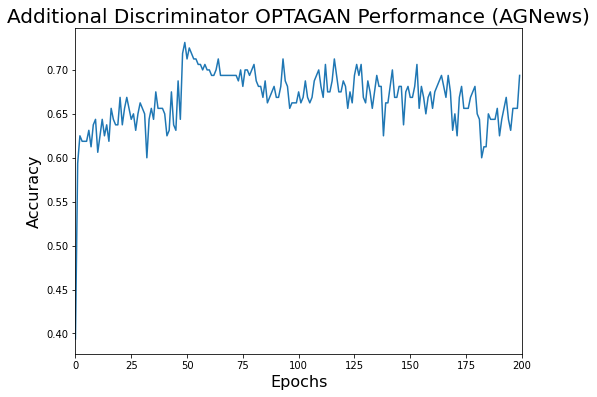

In [19]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_array)
plt.title('Additional Discriminator OPTAGAN Performance (AGNews)', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlim(0,200)
plt.show

In [20]:
df_to_save = pd.DataFrame(accuracy_array)
df_to_save.to_csv('accuracy_array_optagan_AGNews_cls_last.csv')

In [ ]:
# #Generating Sentences
# from __future__ import absolute_import, division, print_function, unicode_literals
# import argparse

# import logging
# import torch
# import torch.nn as nn
# import numpy as np

# from modules.gan import Generator

# import glob
# import os
# import pickle
# import random

# import torch.nn.functional as F
# from tqdm import tqdm, trange

# from func import GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig, BertConfig
# from func import GPT2LMHeadModel, GPT2Tokenizer, GPT2ForLatentConnector, GPT2ForLatentConnectorValueHead
# from func import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
# from func import XLNetLMHeadModel, XLNetTokenizer
# from func import TransfoXLLMHeadModel, TransfoXLTokenizer
# from func import BertForLatentConnector, BertTokenizer

# from collections import defaultdict
# import pdb
# from modules.utils import rollout_test

# MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop

# ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig)), ())

# logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
#                     datefmt = '%m/%d/%Y %H:%M:%S',
#                     level = logging.INFO)
# logger = logging.getLogger(__name__)

# MODEL_CLASSES = {
#     'gpt2': (GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer),
#     'bert': (BertConfig, BertForLatentConnector, BertTokenizer),
#     'gpt2v': (GPT2Config, GPT2ForLatentConnectorValueHead, GPT2Tokenizer)
# }

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--seed', type=int, default=0)
#     parser.add_argument('--new_sent', type=int, default=1, help="Number of sentences to generate")
#     parser.add_argument('--n_layers', type=int, default=20, help="Number of layers of generator")
#     parser.add_argument('--block_dim', type=int, default=100)
#     parser.add_argument('--interval', type=int, default=10)
#     parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available())
#     parser.add_argument('--generator_dir', default=None, type=str, required=True, help="Directory of GAN model checkpoint")
#     parser.add_argument("--checkpoint_dir", default=None, type=str, required=True,
#                         help="The directory where checkpoints are saved.")
#     parser.add_argument("--output_dir", default=None, type=str, required=True,
#                         help="The output directory where the model predictions and checkpoints will be written.")
#     parser.add_argument("--save", default=False, type=bool, help="Save results to file.")
#     parser.add_argument("--latent_size", default=32, type=int, help="Latent space dimension.")
#     parser.add_argument("--output_name", default="results", type=str, help="File name of output")
#     parser.add_argument("--batch_size", default=100, type=int, help="Batch size to generate outputs")
#     ## Encoder options
#     parser.add_argument("--encoder_model_type", default="bert", type=str,
#                         help="The encoder model architecture to be fine-tuned.")
#     parser.add_argument("--encoder_model_name_or_path", default="bert-base-cased", type=str,
#                         help="The encoder model checkpoint for weights initialization.")
#     parser.add_argument("--encoder_config_name", default="", type=str,
#                         help="Optional pretrained config name or path if not the same as model_name_or_path")
#     parser.add_argument("--encoder_tokenizer_name", default="", type=str,
#                         help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
#     ## Decoder options
#     parser.add_argument("--decoder_model_type", default="gpt2", type=str,
#                         help="The decoder model architecture to be fine-tuned.")
#     parser.add_argument("--decoder_model_name_or_path", default="gpt2", type=str,
#                         help="The decoder model checkpoint for weights initialization.")
#     parser.add_argument("--decoder_config_name", default="", type=str,
#                         help="Optional pretrained config name or path if not the same as model_name_or_path")
#     parser.add_argument("--decoder_tokenizer_name", default="", type=str,
#                         help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
#     parser.add_argument("--max_seq_length", default=512, type=int,
#                         help="Optional input sequence length before tokenization. The sequence will be dropped if it is longer the max_seq_length")
#     parser.add_argument("--finetune_decoder", default=False, type=bool,
#                         help="Uses finetuned decoder in output dir if true.")

#     ## Variational auto-encoder(check this)
#     parser.add_argument("--top_k", type=int, default=0)
#     parser.add_argument("--top_p", type=float, default=1.0)
#     parser.add_argument("--prompt", type=str, default="")
#     parser.add_argument("--padding_text", type=str, default="")
#     parser.add_argument("--length", type=int, default=20)
#     parser.add_argument("--block_size", default=-1, type=int,
#                         help="Optional input sequence length after tokenization."
#                              "The training dataset will be truncated in block of this size for training."
#                              "Default to the model max input length for single sentence inputs (take into account special tokens).")
#     parser.add_argument("--do_lower_case", action='store_true',
#                         help="Set this flag if you are using an uncased model.")
#     parser.add_argument("--use_philly", action='store_true',
#                         help="Use Philly for computing.")
#     parser.add_argument('--gloabl_step_eval', type=int, default=508523,
#                         help="Evaluate the results at the given global step")

#     # Load a trained Encoder model and vocabulary that you have fine-tuned
#     args = parser.parse_args("--checkpoint_dir=output_dir_yahoo_768_0 \
#     --output_dir=output_dir_yahoo_768_0 \
#     --generator_dir=output_dir_yahoo_768_0 \
#     --block_size 100 \
#     --max_seq_length 60 \
#     --gloabl_step_eval 24000 \
#     --latent_size 32 \
#     --block_dim 100 \
#     --new_sent 100 \
#     --n_layers 10 \
#     --top_p 0.9 \
#     --output_name=results \
#     --save True".split())
#     global_step = args.gloabl_step_eval

#     np.random.seed(args.seed)
#     torch.manual_seed(args.seed)
#     torch.backends.cudnn.deterministic = True
#     args.device = torch.device("cuda" if args.cuda else "cpu")
#     args.n_gpu = torch.cuda.device_count()
#     if args.n_gpu > 0:
#         torch.cuda.manual_seed_all(args.seed)       
    
#     args.encoder_model_type = args.encoder_model_type.lower()
#     args.decoder_model_type = args.decoder_model_type.lower()

#     output_encoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-encoder-{}'.format(global_step))
#     output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step))
#     if not args.finetune_decoder:
#         output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step))
#     else:
#          output_decoder_dir = os.path.join(args.output_dir, 'checkpoint-decoder-{}'.format(global_step))
#     checkpoints = [ [output_encoder_dir, output_decoder_dir] ]

#     # Load a trained Encoder model and vocabulary that you have fine-tuned
#     encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[args.encoder_model_type]
#     model_encoder = encoder_model_class.from_pretrained(output_encoder_dir, latent_size=args.latent_size)
#     tokenizer_encoder = encoder_tokenizer_class.from_pretrained(args.encoder_tokenizer_name if args.encoder_tokenizer_name else args.encoder_model_name_or_path, do_lower_case=args.do_lower_case)

#     model_encoder.to(args.device)
#     if args.block_size <= 0:
#         args.block_size = tokenizer_encoder.max_len_single_sentence  # Our input block size will be the max possible for the model
#     args.block_size = min(args.block_size, tokenizer_encoder.max_len_single_sentence)

#     # Load a trained Decoder model and vocabulary that you have fine-tuned
#     if not args.finetune_decoder:
#         decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[args.decoder_model_type]
#     else:
#         decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES["gpt2v"]
#     model_decoder = decoder_model_class.from_pretrained(output_decoder_dir, latent_size=args.latent_size)
#     tokenizer_decoder = decoder_tokenizer_class.from_pretrained(args.decoder_tokenizer_name if args.decoder_tokenizer_name else args.decoder_model_name_or_path, do_lower_case=args.do_lower_case)
#     model_decoder.to(args.device)
#     if args.block_size <= 0:
#         args.block_size = tokenizer_decoder.max_len_single_sentence  # Our input block size will be the max possible for the model
#     args.block_size = min(args.block_size, tokenizer_decoder.max_len_single_sentence)

#     # Chunyuan: Add Padding token to GPT2
#     special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
#     num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
#     logger.info('We have added {} tokens to GPT2'.format(num_added_toks))
#     model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
#     assert tokenizer_decoder.pad_token == '<PAD>'
    
#     generator = Generator(args.n_layers, args.block_dim, args.latent_size)

#     if args.cuda:
#         generator = generator.cuda()

#     generator.load_state_dict(torch.load(args.generator_dir+'/generator_'+str(args.gloabl_step_eval)+'.th'))
#     generator.eval()
#     model_decoder.eval()
#     model_encoder.eval()
#     if args.save:
#         if not os.path.exists(args.output_dir+"/{}.txt".format(args.output_name)):
#             with open(args.output_dir+"/{}.txt".format(args.output_name), 'w'): 
#                 pass

#     for i in range(int(args.new_sent/args.batch_size)):
#         # sample noise
#         noise = torch.Tensor(np.random.normal(0, 1, (args.batch_size, args.latent_size))).to(args.device)
#         new_z = generator(noise).data

#         # create new sent
#         sents = rollout_test(model_decoder, new_z, tokenizer_decoder, args.max_seq_length, args.batch_size, args.top_k, args.top_p)

#         if args.save:
#             with open(args.output_dir+"/{}.txt".format(args.output_name), 'a') as file:
#                 for i in sents:
#                     file.write(i+"\n")
#         else:
#             for i in sents:
#                 logger.info(i)
